In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 5000



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-1a'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.34510781]
 [ 0.52336049]
 [ 1.39753435]
 ...
 [ 0.24555738]
 [-0.28121091]
 [-0.14171129]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-1a/config.txt

2024-07-08 16:35:02.439749

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

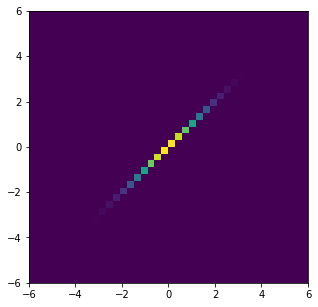

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

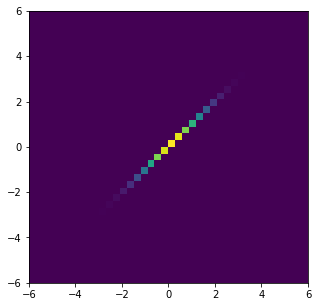

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

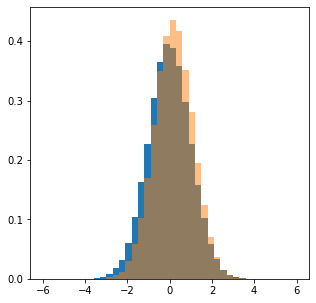

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.34510781]
 [ 0.52336049]
 [ 1.39753435]
 ...
 [ 0.24555738]
 [-0.28121091]
 [-0.14171129]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.54510781]
 [ 0.32336049]
 [ 1.19753435]
 ...
 [ 0.04555738]
 [-0.48121091]
 [-0.34171129]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.53157305 0.49197959 0.21247816 ... 0.54743357 0.54231692 0.55855288]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.52182357 0.587694   0.25865911 ... 0.6260747  0.54338068 0.58328312]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.189
  cov f0f0 :   0.8300
  sigma f0 :   0.9110


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.189
  cov f0f0 :   0.8300
  sigma f0 :   0.9110


In [45]:
test_calc_true_model

{'mean': array([0.18882713]), 'cov': array([[0.83000866]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.98165918, 1.19454955, 1.21734447, ..., 1.1436542 , 1.00196152,
       1.04427557])

In [49]:
pdf_ratio

array([0.98165918, 1.19454955, 1.21734447, ..., 1.1436542 , 1.00196152,
       1.04427557])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([0.98165918, 1.19454955, 1.21734447, ..., 1.1436542 , 1.00196152,
       1.04427557])

In [54]:
calc_weight

array([0.98165918, 1.19454955, 1.21734447, ..., 1.1436542 , 1.00196152,
       1.04427557])

In [55]:
test_hist_pdf_ratio

array([0.99057443, 1.16274548, 1.22128305, ..., 1.13701468, 0.99877236,
       1.03526589])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -0.345   true   0.9817  from hist  0.9906
   1   x   0.523   true   1.1945  from hist  1.1627
   2   x   1.398   true   1.2173  from hist  1.2213
   3   x   1.313   true   1.2246  from hist  1.2401
   4   x  -0.224   true   1.0198  from hist  1.0181
   5   x  -0.774   true   0.8345  from hist  0.8539
   6   x   0.446   true   1.1823  from hist  1.1596
   7   x  -0.297   true   0.9971  from hist  0.9988
   8   x   0.776   true   1.2234  from hist  1.1877
   9   x  -0.009   true   1.0816  from hist  1.0749
  10   x   1.128   true   1.2336  from hist  1.2364
  11   x   0.494   true   1.1900  from hist  1.1668
  12   x   0.539   true   1.1968  from hist  1.1627
  13   x   0.877   true   1.2300  from hist  1.1960
  14   x  -0.117   true   1.0516  from hist  1.0390
  15   x  -0.088   true   1.0598  from hist  1.0481
  16   x   0.814   true   1.2263  from hist  1.1845
  17   x  -0.119   true   1.0510  from hist  1.0390
  18   x  -1.548   true   0.5585  from hist  0.5953
  19   x   1

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.08792776 0.96166374 1.17975366 ... 1.09458175 1.09458175 1.12218964]
  iter 1, step1_output_weights:  shape (100000,)
[1.08792776 0.96166374 1.17975366 ... 1.09458175 1.09458175 1.12218964]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.97234699 1.12131449 1.17617984 ... 1.08572496 0.98520735 1.01439524]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.97234699 1.12131449 1.17617984 ... 1.08572496 0.98520735 1.01439524]
 pdf_ratio_step1:  shape (100000,) 
[1.05810486 0.98975282 1.02354832 ... 1.05688142 1.05688142 1.0573746 ]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

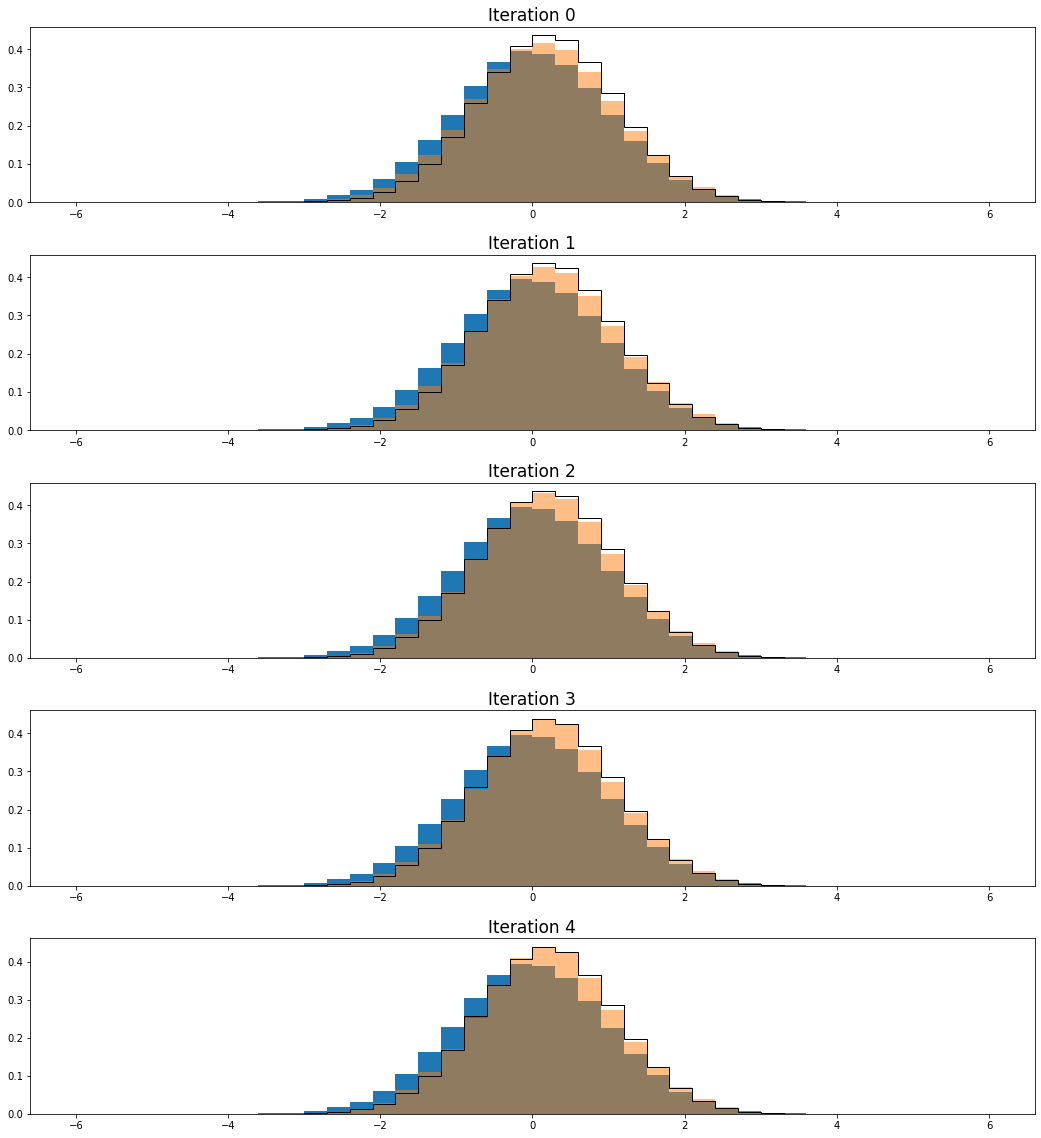

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

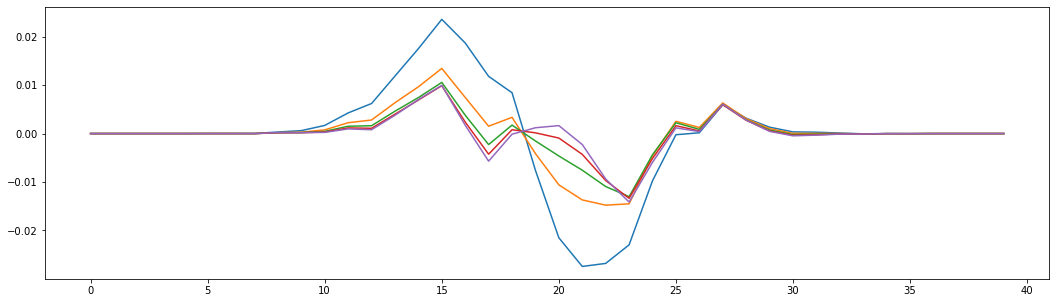

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

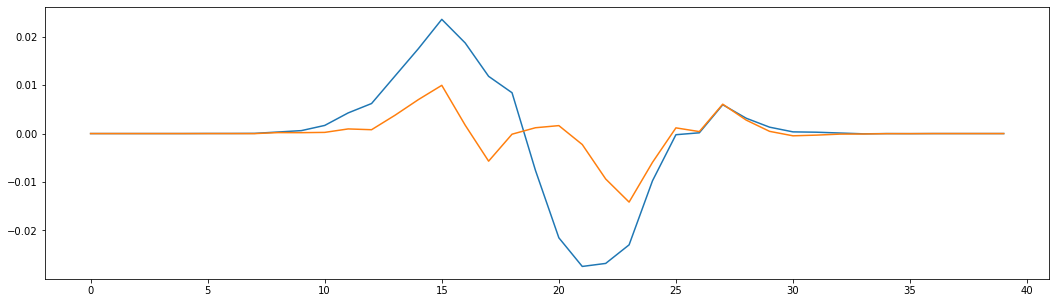

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

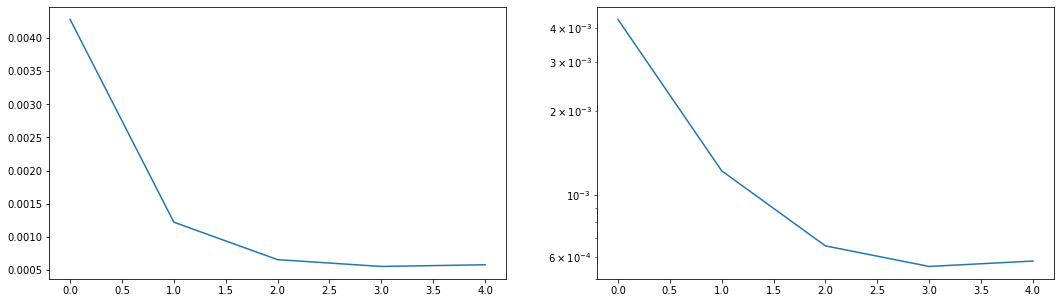

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

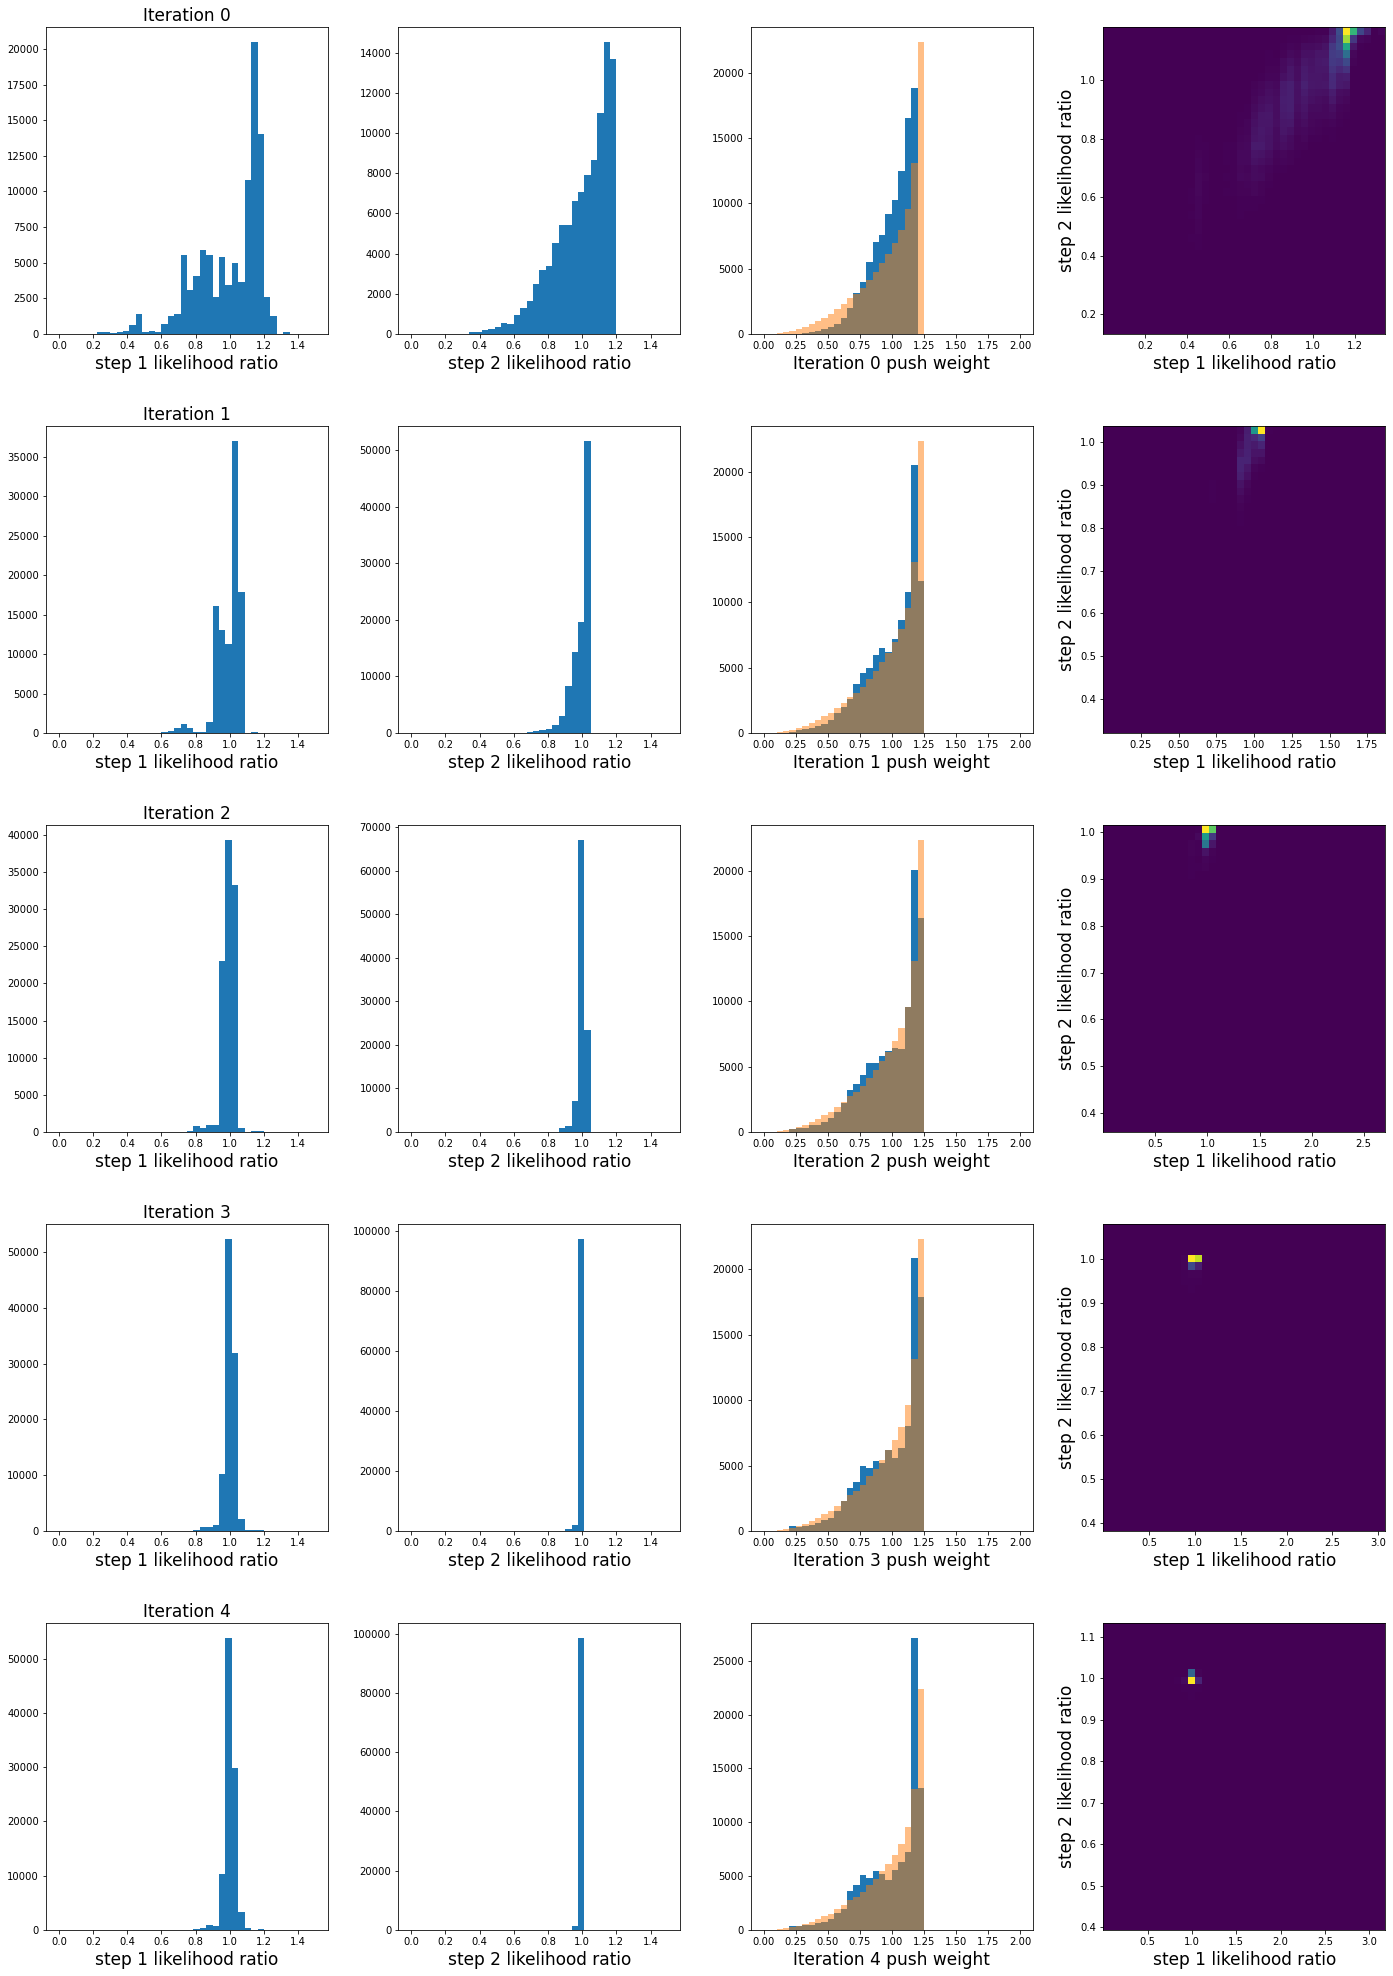

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

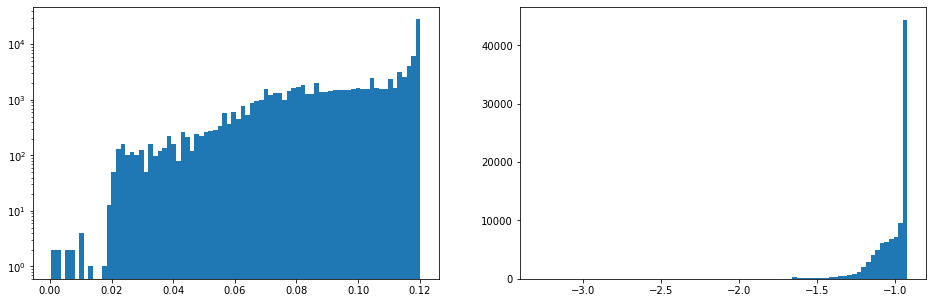

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

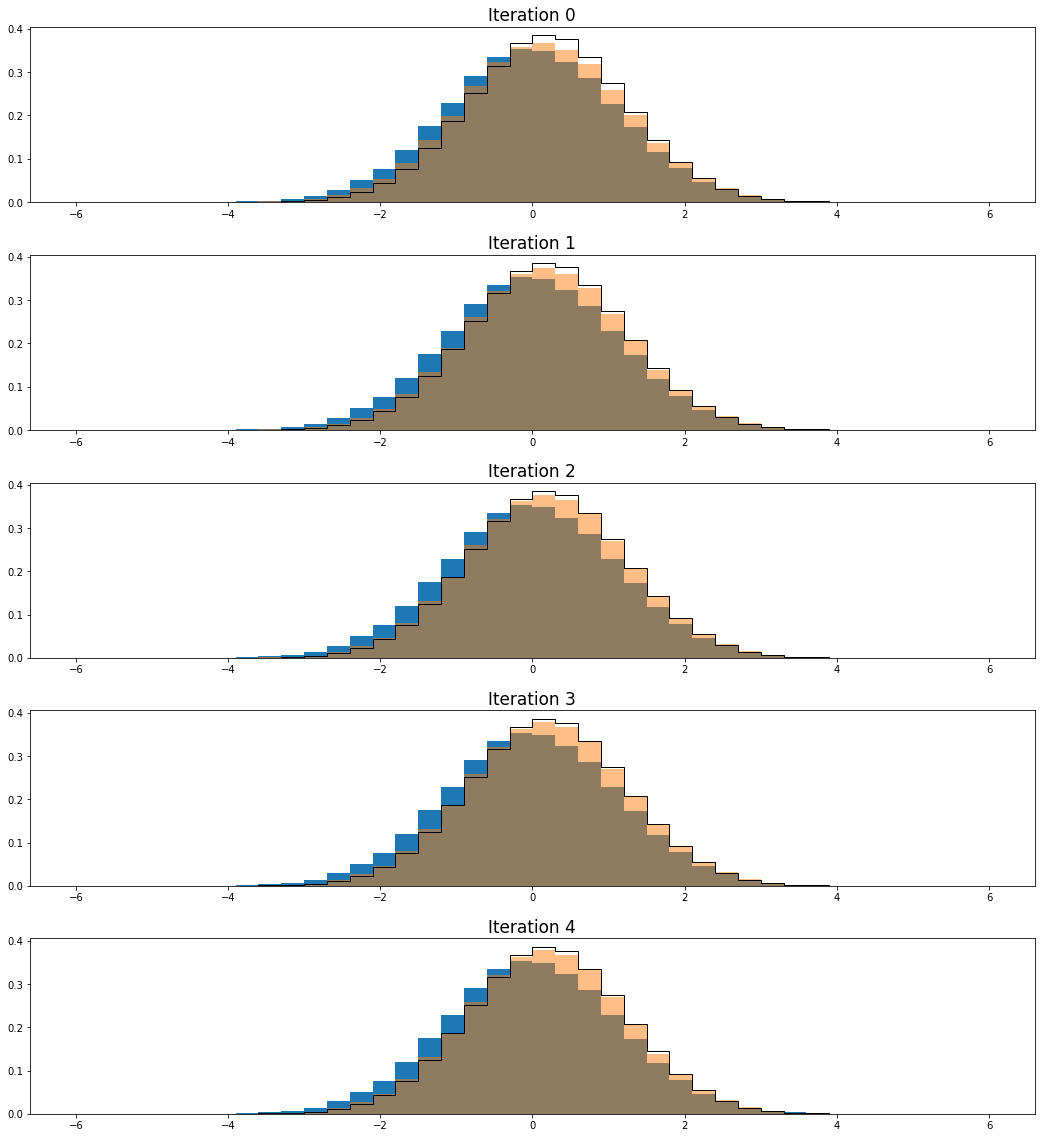

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

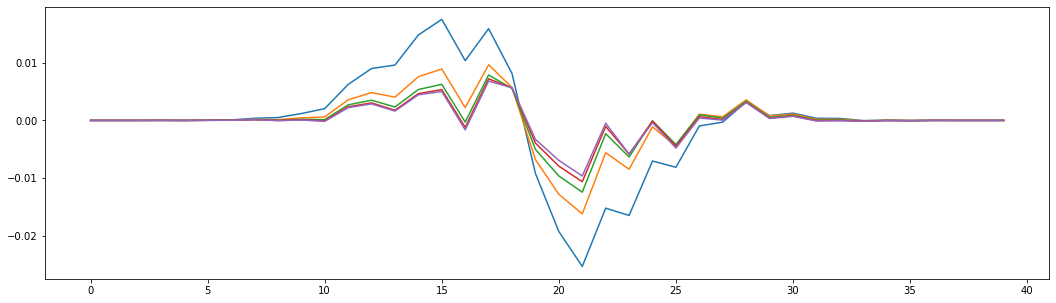

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

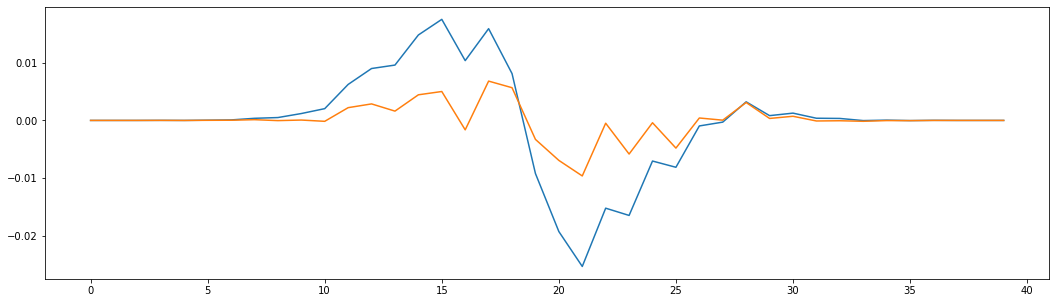

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

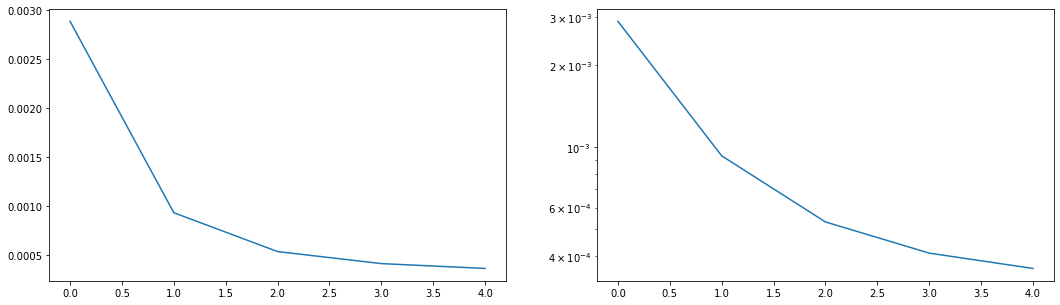

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.190      step 2 mean  1.000  rms 0.161
  iter  1 : step 1 mean  0.992  rms 0.075      step 2 mean  0.992  rms 0.055
  iter  2 : step 1 mean  0.996  rms 0.047      step 2 mean  0.997  rms 0.022
  iter  3 : step 1 mean  0.998  rms 0.042      step 2 mean  0.999  rms 0.011
  iter  4 : step 1 mean  0.999  rms 0.041      step 2 mean  0.999  rms 0.008


<function matplotlib.pyplot.show(close=None, block=None)>

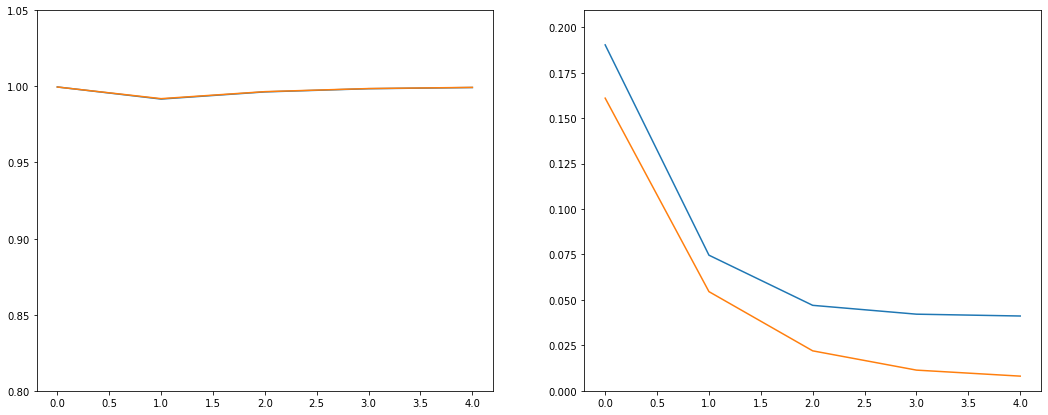

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

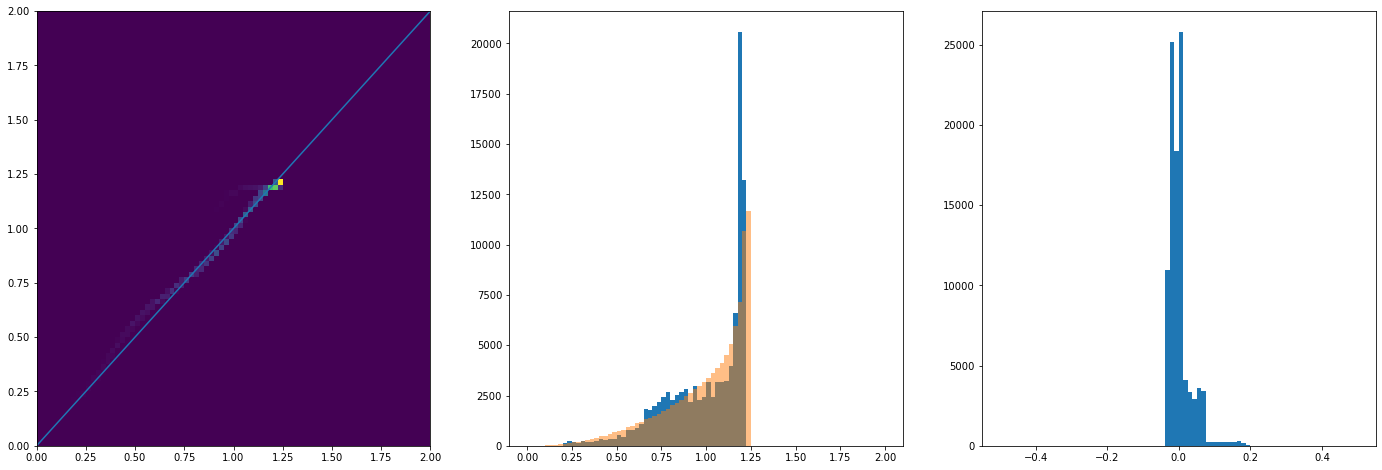

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.03226




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95282973 1.15282623 1.21461138 ... 1.0969658  0.96745264 1.00165302]
 weights_push at the beginning
[0.93519311 1.20867985 1.26206262 ... 1.13178076 0.95455584 1.00045354]
 weights_push at the beginning
[0.92751093 1.23476921 1.26954167 ... 1.14804762 0.94875251 0.99959364]
 weights_push at the beginning
[0.92239945 1.2491579  1.2682816  ... 1.1564699  0.9445066  0.99784748]


 bootstrap 0 final push weights scaled:
[0.09181207 0.12582436 0.12656403 ... 0.11612176 0.09406819 0.0995497 ]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9795364  1.13941896 1.19156909 ... 1.09960575 0.99342244 1.02437125]
 weights_push at the beginning
[0.9775038  1.1856083  1.23198936 ... 1.13645517 0.9962845  1.03798334]
 weights_push at the beginning
[0.98058007 1.20364057 1.23872384 ... 1.15364363 1.00152254 1.0477342 ]
 we


 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97575711 1.14036554 1.19019634 ... 1.09833196 0.98935063 1.02020007]
 weights_push at the beginning
[0.97057638 1.1877096  1.2277683  ... 1.1341369  0.98871906 1.03008781]
 weights_push at the beginning
[0.97065657 1.20734111 1.23190529 ... 1.15074209 0.99066876 1.03642929]
 weights_push at the beginning
[0.97075129 1.21652696 1.22987184 ... 1.15913666 0.99168413 1.03967921]


 bootstrap 14 final push weights scaled:
[0.0970113  0.12212993 0.12274826 ... 0.11637096 0.0991594  0.10409797]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97869217 1.13991949 1.17058598 ... 1.10151879 0.99240312 1.02362052]
 weights_push at the beginning
[0.97524259 1.18973969 1.19381531 ... 1.1415915  0.99371145 1.03610342]
 weights_push at the beginning
[0.97614092 1.21247305 1.18732376 ... 1.16206518 0.99664143 1.04402551]
 w


 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95940224 1.13430237 1.224667   ... 1.08464688 0.97261208 1.00294085]
 weights_push at the beginning
[0.94878077 1.17672385 1.27902251 ... 1.11234581 0.96598455 1.00563177]
 weights_push at the beginning
[0.9473401  1.19307024 1.29182632 ... 1.12414801 0.96597351 1.00896362]
 weights_push at the beginning
[0.94754874 1.19999852 1.29495178 ... 1.12945771 0.9667522  1.01108851]


 bootstrap 29 final push weights scaled:
[0.09477854 0.12030901 0.12959762 ... 0.1131843  0.09672354 0.10121713]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97091864 1.13126983 1.18841071 ... 1.08398815 0.98220486 1.00847711]
 weights_push at the beginning
[0.96308189 1.17549758 1.23324726 ... 1.11073261 0.9772335  1.0105527 ]
 weights_push at the beginning
[0.96139159 1.1935213  1.24462609 ... 1.12026484 0.97599748 1.01074634]
 w


 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98255836 1.12856007 1.16478802 ... 1.09327715 0.99505739 1.0233542 ]
 weights_push at the beginning
[0.98188744 1.17190367 1.18626769 ... 1.12873788 0.99851354 1.03635819]
 weights_push at the beginning
[0.98466705 1.19061147 1.17893013 ... 1.14621023 1.00293934 1.04475311]
 weights_push at the beginning
[0.98638595 1.20033285 1.16772965 ... 1.15583967 1.00541754 1.04925251]


 bootstrap 44 final push weights scaled:
[0.09866996 0.12064049 0.11575148 ... 0.11617167 0.10061312 0.10512191]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96785913 1.12999276 1.18576197 ... 1.08541681 0.98036577 1.00893178]
 weights_push at the beginning
[0.95851193 1.17477428 1.22516317 ... 1.11559433 0.97509095 1.01308936]
 weights_push at the beginning
[0.95580044 1.19411236 1.23060121 ... 1.12913492 0.97402143 1.01581193]
 w


 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97685998 1.12344476 1.1869633  ... 1.08619942 0.98917272 1.01700123]
 weights_push at the beginning
[0.97473102 1.1622805  1.22470574 ... 1.11718619 0.99100039 1.02782346]
 weights_push at the beginning
[0.97783381 1.17693569 1.22921289 ... 1.13159544 0.99563721 1.03595162]
 weights_push at the beginning
[0.98078998 1.18296003 1.22741425 ... 1.13900415 0.99928101 1.04120661]


 bootstrap 58 final push weights scaled:
[0.09828291 0.11855774 0.1225115  ... 0.11431645 0.10016707 0.10444836]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98266001 1.12126306 1.18513391 ... 1.08669468 0.99452828 1.02114601]
 weights_push at the beginning
[0.98402917 1.15784726 1.22349476 ... 1.11724638 0.99950333 1.03414913]
 weights_push at the beginning
[0.98943023 1.17046318 1.23002223 ... 1.13082277 1.00611026 1.04338323]
 w


 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97139306 1.13466816 1.17344115 ... 1.09065546 0.98349262 1.01199517]
 weights_push at the beginning
[0.96333292 1.18333958 1.20394171 ... 1.12390704 0.97894365 1.01651284]
 weights_push at the beginning
[0.96083907 1.20596476 1.2031525  ... 1.13928461 0.977433   1.01824385]
 weights_push at the beginning
[0.95876585 1.21869811 1.19672274 ... 1.14707501 0.97545708 1.01746563]


 bootstrap 72 final push weights scaled:
[0.09563001 0.12271736 0.11901053 ... 0.1151341  0.09727436 0.10151444]

 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97356053 1.13077937 1.19411257 ... 1.09135385 0.98702588 1.01721989]
 weights_push at the beginning
[0.96854799 1.17323818 1.23719361 ... 1.12488965 0.98678068 1.02758964]
 weights_push at the beginning
[0.9694351  1.18962495 1.24614976 ... 1.14079075 0.98987812 1.03544818]
 w


 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97661263 1.14086719 1.17297153 ... 1.10331612 0.99076704 1.02338469]
 weights_push at the beginning
[0.97038522 1.1916644  1.20377768 ... 1.14501323 0.98973889 1.03499815]
 weights_push at the beginning
[0.96879711 1.21437428 1.20447633 ... 1.16663041 0.99057409 1.04215942]
 weights_push at the beginning
[0.96727064 1.22609069 1.20036329 ... 1.17937325 0.99041923 1.04593796]


 bootstrap 86 final push weights scaled:
[0.09651757 0.12329397 0.11966194 ... 0.1187798  0.09892356 0.10476373]

 Creating toy sample  87
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97638476 1.12648649 1.20519455 ... 1.08785995 0.98955101 1.01851923]
 weights_push at the beginning
[0.97642105 1.1634162  1.24839057 ... 1.11830162 0.99395581 1.03205177]
 weights_push at the beginning
[0.98256594 1.17531339 1.25512675 ... 1.13187375 1.00192032 1.04335934]
 w


 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97367974 1.13009947 1.19214264 ... 1.08458727 0.98551065 1.01225365]
 weights_push at the beginning
[0.97010921 1.17213938 1.23297035 ... 1.11193405 0.98518929 1.01915232]
 weights_push at the beginning
[0.97268283 1.18842107 1.23938711 ... 1.12215092 0.98853047 1.02400292]
 weights_push at the beginning
[0.97561047 1.19526981 1.23888074 ... 1.12523962 0.99137353 1.02642698]


 bootstrap 100 final push weights scaled:
[0.09779117 0.11982641 0.12375267 ... 0.1125109  0.09932701 0.10271996]

 Creating toy sample 101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98314504 1.12112438 1.15464318 ... 1.08889321 0.99517896 1.02243371]
 weights_push at the beginning
[0.98195344 1.16219137 1.17664551 ... 1.12334353 0.99809107 1.03489251]
 weights_push at the beginning
[0.9837241  1.17975943 1.17233144 ... 1.14048953 1.00160223 1.04265032]
 


 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96985047 1.1271358  1.19475687 ... 1.08826861 0.98344436 1.0139504 ]
 weights_push at the beginning
[0.96392481 1.16807017 1.23202419 ... 1.12145039 0.98243904 1.02392688]
 weights_push at the beginning
[0.96457846 1.18455462 1.23416265 ... 1.13838524 0.98552267 1.03230184]
 weights_push at the beginning
[0.96569901 1.19216904 1.22976019 ... 1.14832542 0.98818969 1.03826351]


 bootstrap 114 final push weights scaled:
[0.0966281  0.11961347 0.12250434 ... 0.11549012 0.09899465 0.10424861]

 Creating toy sample 115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96521093 1.14012405 1.19062392 ... 1.09643256 0.97973804 1.01282832]
 weights_push at the beginning
[0.95551418 1.18996067 1.222034   ... 1.1343121  0.97534012 1.02074777]
 weights_push at the beginning
[0.95315279 1.21292708 1.21854046 ... 1.15424254 0.97554695 1.02698398]
 


 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98546923 1.13783415 1.16487718 ... 1.10079665 0.99853966 1.0280823 ]
 weights_push at the beginning
[0.98536677 1.18581752 1.19150372 ... 1.13912195 1.00280779 1.04243872]
 weights_push at the beginning
[0.98843437 1.20616297 1.19045621 ... 1.15704113 1.0075433  1.05115598]
 weights_push at the beginning
[0.99063029 1.21584915 1.18582531 ... 1.16594366 1.01039245 1.05572673]


 bootstrap 128 final push weights scaled:
[0.09916354 0.12209251 0.11822525 ... 0.11705003 0.10116207 0.10577346]

 Creating toy sample 129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97248687 1.13203272 1.19513162 ... 1.09078059 0.98560657 1.01530002]
 weights_push at the beginning
[0.96812472 1.17498283 1.23054503 ... 1.12364224 0.9854769  1.0248261 ]
 weights_push at the beginning
[0.96982828 1.19271736 1.23085882 ... 1.13941329 0.98885855 1.03204232]
 


 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96718836 1.12991092 1.19705243 ... 1.08500715 0.97966254 1.00844249]
 weights_push at the beginning
[0.95851746 1.17277231 1.24039584 ... 1.11412216 0.97484358 1.01282602]
 weights_push at the beginning
[0.95676646 1.19036613 1.24797935 ... 1.12687502 0.97450361 1.01603793]
 weights_push at the beginning
[0.95589767 1.19871287 1.2479324  ... 1.13290413 0.97422775 1.01741939]


 bootstrap 142 final push weights scaled:
[0.09548186 0.12032394 0.12466298 ... 0.11359183 0.09734388 0.10175808]

 Creating toy sample 143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96337102 1.13015451 1.20954499 ... 1.08415314 0.97603153 1.00534601]
 weights_push at the beginning
[0.95330003 1.17165821 1.25709542 ... 1.11231404 0.96973508 1.00820316]
 weights_push at the beginning
[0.95088468 1.18813555 1.26664563 ... 1.12465291 0.9686382  1.01057956]
 


 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96281173 1.13880218 1.22250772 ... 1.08974567 0.97574021 1.00602204]
 weights_push at the beginning
[0.9526756  1.18348379 1.27579343 ... 1.11942235 0.96916859 1.00842006]
 weights_push at the beginning
[0.95065338 1.20141772 1.28872799 ... 1.13217446 0.96810661 1.0102832 ]
 weights_push at the beginning
[0.94969709 1.20969347 1.29251589 ... 1.13804701 0.96726096 1.01039849]


 bootstrap 156 final push weights scaled:
[0.09484404 0.12140858 0.12944006 ... 0.11409015 0.09658221 0.10092432]

 Creating toy sample 157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96708846 1.12419438 1.2173969  ... 1.08226606 0.97984347 1.00884569]
 weights_push at the beginning
[0.96055214 1.16057108 1.27252335 ... 1.10958941 0.97734792 1.01559302]
 weights_push at the beginning
[0.96149674 1.17242619 1.28867768 ... 1.12142663 0.97990775 1.02181338]
 


 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97116447 1.12958021 1.19167172 ... 1.0881994  0.98370657 1.01270491]
 weights_push at the beginning
[0.96474463 1.17225808 1.23092177 ... 1.11978504 0.98117587 1.01963588]
 weights_push at the beginning
[0.96435883 1.18983241 1.23598092 ... 1.13452339 0.9821979  1.02443577]
 weights_push at the beginning
[0.96429551 1.19824191 1.23440069 ... 1.14218706 0.98269318 1.02677912]


 bootstrap 170 final push weights scaled:
[0.09636559 0.1202895  0.12321943 ... 0.11466024 0.09822878 0.10274884]

 Creating toy sample 171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96699253 1.13475115 1.19837697 ... 1.08782068 0.97942204 1.00827359]
 weights_push at the beginning
[0.95793877 1.18038033 1.24285419 ... 1.11783686 0.9739686  1.01159977]
 weights_push at the beginning
[0.95593458 1.19965387 1.2511065  ... 1.13070924 0.97303542 1.01357808]
 


 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97336287 1.12437425 1.19629589 ... 1.08692922 0.98621565 1.01526073]
 weights_push at the beginning
[0.96891103 1.16298538 1.23934569 ... 1.11842132 0.98610264 1.02502657]
 weights_push at the beginning
[0.97028551 1.17721256 1.24731086 ... 1.13353611 0.98937478 1.03261874]
 weights_push at the beginning
[0.97179159 1.18276868 1.24810128 ... 1.14180369 0.99193845 1.03762341]


 bootstrap 184 final push weights scaled:
[0.0972534  0.11849189 0.12479077 ... 0.11469319 0.09934108 0.10408244]

 Creating toy sample 185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96153824 1.13439356 1.2039998  ... 1.09042074 0.97534378 1.00736936]
 weights_push at the beginning
[0.95016158 1.17964162 1.24328151 ... 1.12426799 0.96863768 1.01204886]
 weights_push at the beginning
[0.94663681 1.19952949 1.24519918 ... 1.14175893 0.96720342 1.01604705]
 


 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96890469 1.13416708 1.20435744 ... 1.08969961 0.98204708 1.01185434]
 weights_push at the beginning
[0.96209949 1.17757845 1.24829628 ... 1.1208693  0.97940589 1.01869643]
 weights_push at the beginning
[0.96222309 1.19490413 1.25564305 ... 1.13493016 0.98113282 1.02400626]
 weights_push at the beginning
[0.96299267 1.2026732  1.25557282 ... 1.14180872 0.98262875 1.0270771 ]


 bootstrap 198 final push weights scaled:
[0.09633198 0.12065008 0.12545775 ... 0.11453864 0.09833458 0.10286031]

 Creating toy sample 199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98388223 1.12165936 1.16247307 ... 1.09011133 0.99619685 1.02388593]
 weights_push at the beginning
[0.98440985 1.16182693 1.1869343  ... 1.12521819 1.0009755  1.03832171]
 weights_push at the beginning
[0.9882073  1.17829204 1.18305275 ... 1.14295133 1.00661045 1.04820548]
 


 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96978571 1.134882   1.18737179 ... 1.09428272 0.98364709 1.01531263]
 weights_push at the beginning
[0.96159405 1.18130436 1.22357071 ... 1.13046671 0.98043996 1.02383284]
 weights_push at the beginning
[0.95958986 1.20130836 1.22647583 ... 1.14872718 0.98079734 1.02990486]
 weights_push at the beginning
[0.95817683 1.21126398 1.22339988 ... 1.15921197 0.9807967  1.03344159]


 bootstrap 212 final push weights scaled:
[0.09564349 0.12168564 0.12202212 ... 0.11659628 0.0980068  0.10353295]

 Creating toy sample 213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97471965 1.12832867 1.19526577 ... 1.08961196 0.9875249  1.01660225]
 weights_push at the beginning
[0.97153208 1.16897038 1.23653532 ... 1.12201277 0.98843835 1.02696024]
 weights_push at the beginning
[0.97403225 1.1843651  1.24337428 ... 1.13718199 0.99250271 1.03469287]
 


 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96435392 1.12846065 1.21974173 ... 1.07990225 0.97662056 1.00432941]
 weights_push at the beginning
[0.95630313 1.16784151 1.27811389 ... 1.10431325 0.97210557 1.007559  ]
 weights_push at the beginning
[0.95668033 1.18173442 1.29627924 ... 1.11317232 0.97359    1.01111532]
 weights_push at the beginning
[0.95860281 1.18651789 1.30449542 ... 1.11588858 0.97582267 1.01356352]


 bootstrap 226 final push weights scaled:
[0.09605978 0.11876718 0.13100672 ... 0.1115977  0.0977841  0.10151346]

 Creating toy sample 227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96948584 1.11022362 1.20590705 ... 1.06831088 0.97994808 1.00366066]
 weights_push at the beginning
[0.96451594 1.14039897 1.25859535 ... 1.08743287 0.97759312 1.00708796]
 weights_push at the beginning
[0.96622769 1.14929358 1.27453308 ... 1.09346139 0.97985955 1.01039093]
 


 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97424403 1.12667849 1.1876114  ... 1.08635014 0.98629937 1.01398779]
 weights_push at the beginning
[0.96873515 1.16780438 1.22847843 ... 1.11643717 0.98448766 1.02096897]
 weights_push at the beginning
[0.96857201 1.18416636 1.2363417  ... 1.12979169 0.98563799 1.02544491]
 weights_push at the beginning
[0.96856101 1.19153277 1.23761014 ... 1.13625405 0.98614565 1.02746526]


 bootstrap 240 final push weights scaled:
[0.09679646 0.11952492 0.12380583 ... 0.1139651  0.09857812 0.10279584]

 Creating toy sample 241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9617133  1.13334407 1.20553755 ... 1.08677779 0.97493345 1.00543098]
 weights_push at the beginning
[0.95006131 1.17808803 1.25216818 ... 1.11742051 0.96759736 1.00835596]
 weights_push at the beginning
[0.94650224 1.19695466 1.2609514  ... 1.13174411 0.96583427 1.01098022]
 


 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97916408 1.13823725 1.18361982 ... 1.09893369 0.99273253 1.02322448]
 weights_push at the beginning
[0.97765521 1.18469032 1.21254038 ... 1.13613734 0.99576283 1.0364672 ]
 weights_push at the beginning
[0.98087921 1.20436313 1.20961974 ... 1.15424536 1.00082802 1.04562643]
 weights_push at the beginning
[0.98350072 1.21403204 1.20205847 ... 1.16390481 1.0043026  1.05099803]


 bootstrap 254 final push weights scaled:
[0.09848868 0.12195154 0.11952877 ... 0.11694588 0.10061279 0.10538233]

 Creating toy sample 255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96969825 1.12567869 1.17924275 ... 1.08451059 0.98193601 1.01017452]
 weights_push at the beginning
[0.9605592  1.16835735 1.21477182 ... 1.11483713 0.97677794 1.01462414]
 weights_push at the beginning
[0.95707651 1.18683218 1.21846047 ... 1.12897787 0.97493753 1.01701288]
 


 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95788206 1.1309569  1.22567971 ... 1.08076894 0.97056214 0.99979285]
 weights_push at the beginning
[0.94723447 1.17183496 1.27883347 ... 1.1064518  0.96347578 1.00107708]
 weights_push at the beginning
[0.9459727  1.18778826 1.29011431 ... 1.11716691 0.96328956 1.00346413]
 weights_push at the beginning
[0.94628354 1.19494005 1.29175645 ... 1.12182692 0.96386495 1.0047355 ]


 bootstrap 268 final push weights scaled:
[0.09465191 0.11986029 0.12913788 ... 0.1123793  0.09640723 0.10049697]

 Creating toy sample 269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96684161 1.12645416 1.20700696 ... 1.08394485 0.97959399 1.00879719]
 weights_push at the beginning
[0.95912424 1.16586229 1.25663806 ... 1.11281536 0.97594979 1.01468804]
 weights_push at the beginning
[0.95864833 1.18037667 1.26906544 ... 1.12574077 0.97709598 1.01971889]
 


 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97711102 1.13998508 1.19265661 ... 1.10014172 0.99113314 1.0228027 ]
 weights_push at the beginning
[0.97302905 1.18645416 1.23105457 ... 1.13739646 0.99193937 1.03484857]
 weights_push at the beginning
[0.97398153 1.20517299 1.23574823 ... 1.15523728 0.99505124 1.04300633]
 weights_push at the beginning
[0.97471309 1.21349383 1.23430403 ... 1.16469868 0.99696065 1.04776045]


 bootstrap 282 final push weights scaled:
[0.09744964 0.1217479  0.12325676 ... 0.11702181 0.0997527  0.10503004]

 Creating toy sample 283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97145881 1.13751591 1.20932749 ... 1.09432859 0.98504345 1.01587667]
 weights_push at the beginning
[0.96607407 1.18141486 1.25600448 ... 1.1275682  0.98403119 1.02491751]
 weights_push at the beginning
[0.9672548  1.19826732 1.26569665 ... 1.14274379 0.98691938 1.03175206]
 


 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97431981 1.11883338 1.18227491 ... 1.07996214 0.98555173 1.01138554]
 weights_push at the beginning
[0.96984189 1.15643053 1.21799421 ... 1.10729229 0.98425663 1.01773044]
 weights_push at the beginning
[0.97044514 1.17139434 1.22102624 ... 1.11934374 0.98580415 1.02182647]
 weights_push at the beginning
[0.97082478 1.17851905 1.21769017 ... 1.12518353 0.9864091  1.02337863]


 bootstrap 296 final push weights scaled:
[0.09702825 0.11826673 0.12136591 ... 0.1128298  0.09858486 0.10232376]

 Creating toy sample 297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95410793 1.13271905 1.20723962 ... 1.08312474 0.96707101 0.99772224]
 weights_push at the beginning
[0.93794094 1.17860765 1.25430945 ... 1.1123685  0.95493585 0.99586772]
 weights_push at the beginning
[0.93106154 1.19914819 1.26269062 ... 1.12624238 0.94960644 0.99498225]
 


 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97118893 1.1420618  1.21264283 ... 1.09825772 0.98571553 1.01821259]
 weights_push at the beginning
[0.96676005 1.18788945 1.25769581 ... 1.13393821 0.98631795 1.02990851]
 weights_push at the beginning
[0.96945941 1.20561437 1.26459338 ... 1.15083884 0.99124027 1.03948755]
 weights_push at the beginning
[0.97270342 1.21286305 1.2639254  ... 1.15955946 0.99567761 1.04625676]


 bootstrap 310 final push weights scaled:
[0.09752804 0.12157434 0.1262479  ... 0.11643368 0.09990096 0.10509569]

 Creating toy sample 311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97541774 1.13251304 1.18091072 ... 1.09474631 0.98872475 1.0191309 ]
 weights_push at the beginning
[0.97036831 1.17768131 1.21481769 ... 1.13121076 0.9882965  1.02962905]
 weights_push at the beginning
[0.9704087  1.19685713 1.21677118 ... 1.14952365 0.99036904 1.03673637]
 


 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96278037 1.12929479 1.23255801 ... 1.08164165 0.97540977 1.00427262]
 weights_push at the beginning
[0.95485562 1.16660998 1.29197944 ... 1.10645093 0.97099743 1.00794456]
 weights_push at the beginning
[0.95547835 1.17883449 1.309425   ... 1.11594427 0.9726605  1.01197023]
 weights_push at the beginning
[0.95713616 1.18237847 1.3170761  ... 1.1193354  0.97457654 1.0144657 ]


 bootstrap 324 final push weights scaled:
[0.09583629 0.11826294 0.13225138 ... 0.11201197 0.09758045 0.10157028]

 Creating toy sample 325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97437301 1.1442516  1.1796644  ... 1.102438   0.98849783 1.02085393]
 weights_push at the beginning
[0.96650116 1.19642511 1.21656595 ... 1.14215406 0.98574797 1.03025124]
 weights_push at the beginning
[0.9640947  1.2194544  1.22168154 ... 1.16162105 0.98568322 1.03592782]
 


 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96335485 1.12653011 1.20253907 ... 1.08111751 0.97589731 1.00449039]
 weights_push at the beginning
[0.95314176 1.16751131 1.24964973 ... 1.10857397 0.9696696  1.00739335]
 weights_push at the beginning
[0.95076165 1.18384826 1.25954026 ... 1.12063107 0.96888073 1.01016438]
 weights_push at the beginning
[0.94976473 1.19122697 1.26102789 ... 1.12643436 0.96867615 1.01165279]


 bootstrap 338 final push weights scaled:
[0.09488566 0.11949029 0.12608467 ... 0.1129442  0.09682596 0.1012219 ]

 Creating toy sample 339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97223266 1.12878355 1.17721184 ... 1.08993473 0.98529665 1.01510655]
 weights_push at the beginning
[0.96552287 1.17326258 1.21126856 ... 1.12440766 0.98319302 1.02378326]
 weights_push at the beginning
[0.96447794 1.19235381 1.21403306 ... 1.14149749 0.98423884 1.02984659]
 


 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97476702 1.12754031 1.1979045  ... 1.08516364 0.98680136 1.01402031]
 weights_push at the beginning
[0.97226558 1.16716651 1.24250244 ... 1.1133148  0.98773567 1.02265045]
 weights_push at the beginning
[0.97572139 1.18153349 1.25272848 ... 1.12454934 0.99215368 1.02909675]
 weights_push at the beginning
[0.97930364 1.18676469 1.25630969 ... 1.12870941 0.99585035 1.03292048]


 bootstrap 352 final push weights scaled:
[0.09820946 0.11883274 0.12592395 ... 0.11296684 0.09984367 0.10349437]

 Creating toy sample 353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97721382 1.14175611 1.17980344 ... 1.10414292 0.99212346 1.02542774]
 weights_push at the beginning
[0.97455122 1.19102642 1.20414001 ... 1.14616609 0.99510544 1.04103191]
 weights_push at the beginning
[0.97705902 1.21269021 1.19728955 ... 1.16839271 1.00041103 1.05251455]
 


 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98160133 1.12944488 1.1850342  ... 1.09416503 0.99469834 1.02400826]
 weights_push at the beginning
[0.98127553 1.17070958 1.22312714 ... 1.12920074 0.99886211 1.0381899 ]
 weights_push at the beginning
[0.98523837 1.18603431 1.22962981 ... 1.14579448 1.00473641 1.04825401]
 weights_push at the beginning
[0.988626   1.19178928 1.23069405 ... 1.15440235 1.0091005  1.05473895]


 bootstrap 366 final push weights scaled:
[0.09908742 0.11936385 0.12317342 ... 0.1159241  0.10119399 0.10588736]

 Creating toy sample 367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96283805 1.13884314 1.21515681 ... 1.09283174 0.97696394 1.0092298 ]
 weights_push at the beginning
[0.95331607 1.18482069 1.26263645 ... 1.12664751 0.9721923  1.0154747 ]
 weights_push at the beginning
[0.95220068 1.20381115 1.27073524 ... 1.14319038 0.97312612 1.0211653 ]
 


 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98259761 1.13757731 1.16754971 ... 1.10212978 0.99640758 1.02757582]
 weights_push at the beginning
[0.98019238 1.18586966 1.19648379 ... 1.14264075 0.99911628 1.04206406]
 weights_push at the beginning
[0.98146804 1.20648858 1.19666371 ... 1.16299987 1.00279707 1.05138994]
 weights_push at the beginning
[0.98230944 1.2163745  1.19249539 ... 1.17445837 1.00501578 1.05694055]


 bootstrap 380 final push weights scaled:
[0.09822963 0.12215762 0.11888546 ... 0.11816017 0.10059302 0.10601806]

 Creating toy sample 381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97184528 1.12689917 1.20041514 ... 1.08858016 0.98469061 1.01421416]
 weights_push at the beginning
[0.96568453 1.16680763 1.24659902 ... 1.12065949 0.98274336 1.02235886]
 weights_push at the beginning
[0.96545197 1.18192131 1.25718361 ... 1.13616046 0.98426774 1.02836904]
 


 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96644795 1.12331566 1.20077355 ... 1.08256869 0.97897068 1.00778867]
 weights_push at the beginning
[0.95806197 1.16217586 1.24440673 ... 1.11175281 0.97457142 1.01291388]
 weights_push at the beginning
[0.95651872 1.1775148  1.25168688 ... 1.12575086 0.97464976 1.01709144]
 weights_push at the beginning
[0.95556251 1.18458692 1.25137515 ... 1.13352675 0.97453852 1.01931419]


 bootstrap 394 final push weights scaled:
[0.09541255 0.11884164 0.1249941  ... 0.11385105 0.09736637 0.10201356]

 Creating toy sample 395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97606677 1.14525402 1.19188573 ... 1.10409163 0.99057991 1.02342022]
 weights_push at the beginning
[0.97111709 1.19531513 1.23073259 ... 1.14387438 0.99084276 1.0356838 ]
 weights_push at the beginning
[0.97172897 1.21624283 1.23611304 ... 1.16334926 0.99382577 1.04416801]
 


 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97443205 1.11522038 1.18525685 ... 1.07664092 0.98589737 1.01140846]
 weights_push at the beginning
[0.97235297 1.15027466 1.22378372 ... 1.10242703 0.98727875 1.02015101]
 weights_push at the beginning
[0.97605195 1.16280091 1.2297317  ... 1.11319957 0.99216259 1.02720636]
 weights_push at the beginning
[0.97981208 1.16737692 1.22967479 ... 1.11765899 0.99632783 1.03181129]


 bootstrap 408 final push weights scaled:
[0.09827494 0.11688202 0.1229309  ... 0.11191979 0.09993665 0.10346438]

 Creating toy sample 409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96839662 1.13177423 1.18780094 ... 1.09238089 0.98204174 1.01346953]
 weights_push at the beginning
[0.95981749 1.1770233  1.22461005 ... 1.1283857  0.97830603 1.02137295]
 weights_push at the beginning
[0.95763848 1.19662984 1.22831019 ... 1.14706298 0.9783826  1.02715388]
 


 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97598988 1.13101422 1.16631185 ... 1.09294968 0.9886047  1.01781987]
 weights_push at the beginning
[0.96966292 1.17754643 1.19459319 ... 1.12882653 0.98652761 1.0261757 ]
 weights_push at the beginning
[0.96789546 1.19850269 1.19342588 ... 1.146688   0.98651321 1.0308892 ]
 weights_push at the beginning
[0.96618536 1.20973419 1.18731838 ... 1.15681367 0.98566067 1.03271517]


 bootstrap 422 final push weights scaled:
[0.09639661 0.12167653 0.11813436 ... 0.11632886 0.0983932  0.10328153]

 Creating toy sample 423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9709716  1.12810163 1.19497606 ... 1.08885572 0.98410567 1.01405046]
 weights_push at the beginning
[0.96533996 1.16897496 1.23245016 ... 1.12140958 0.9828443  1.02301097]
 weights_push at the beginning
[0.96583725 1.18519618 1.23516331 ... 1.13736779 0.98520489 1.02988481]
 


 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9742851  1.13886787 1.19741244 ... 1.09574158 0.9879357  1.01849646]
 weights_push at the beginning
[0.97084063 1.184658   1.23739371 ... 1.13018836 0.98899684 1.02948242]
 weights_push at the beginning
[0.97360498 1.20277752 1.2422418  ... 1.14578205 0.99353342 1.03768435]
 weights_push at the beginning
[0.97665706 1.21050426 1.24047364 ... 1.15319518 0.99735595 1.04291317]


 bootstrap 436 final push weights scaled:
[0.09789745 0.12138633 0.12382757 ... 0.1156701  0.10000237 0.10460642]

 Creating toy sample 437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95771207 1.11800456 1.21712936 ... 1.07326529 0.96957187 0.99735815]
 weights_push at the beginning
[0.94539151 1.15340923 1.27123304 ... 1.0967577  0.96068016 0.99702574]
 weights_push at the beginning
[0.94170115 1.16659626 1.28547706 ... 1.10715133 0.95820299 0.99795546]
 


 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9680737  1.13605778 1.20012839 ... 1.09486661 0.98235746 1.01473573]
 weights_push at the beginning
[0.95933969 1.1819619  1.24628682 ... 1.13103707 0.97888177 1.02334835]
 weights_push at the beginning
[0.95760222 1.20068036 1.25667814 ... 1.14918333 0.9797228  1.030109  ]
 weights_push at the beginning
[0.95695699 1.20904271 1.25961546 ... 1.15959652 0.98067754 1.03472715]


 bootstrap 450 final push weights scaled:
[0.09562615 0.12129203 0.12615019 ... 0.11663263 0.09811629 0.10379092]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.978223   1.12976114 1.19312821 ... 1.0902056  0.99077587 1.01909748]
 weights_push at the beginning
[0.97656199 1.17053579 1.2349758  ... 1.1216081  0.99302346 1.03017139]
 weights_push at the beginning
[0.98002136 1.18548774 1.24322661 ... 1.13522251 0.99786306 1.03808243]
 


 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97482863 1.12277291 1.1718744  ... 1.09072988 0.98825854 1.01892607]
 weights_push at the beginning
[0.96904927 1.16405014 1.20206663 ... 1.12770377 0.98767544 1.0306471 ]
 weights_push at the beginning
[0.96807739 1.18146683 1.2022019  ... 1.14794701 0.98946146 1.03922463]
 weights_push at the beginning
[0.96708209 1.19000882 1.19754997 ... 1.16087035 0.99033108 1.04488145]


 bootstrap 464 final push weights scaled:
[0.09654565 0.11947822 0.11933172 ... 0.11702227 0.09901793 0.10486422]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9732973  1.139945   1.20052228 ... 1.09773757 0.98689848 1.01811499]
 weights_push at the beginning
[0.96830242 1.1860059  1.24046233 ... 1.13331773 0.98623926 1.02780863]
 weights_push at the beginning
[0.96931853 1.20473067 1.24490928 ... 1.15019903 0.98887558 1.03459429]
 


 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96744067 1.12922682 1.19745441 ... 1.08335223 0.97945604 1.00718758]
 weights_push at the beginning
[0.95904306 1.17149408 1.24249566 ... 1.11087232 0.97447398 1.01038352]
 weights_push at the beginning
[0.95751242 1.18844177 1.25187773 ... 1.12204204 0.97393053 1.01239603]
 weights_push at the beginning
[0.95682584 1.19614699 1.25354458 ... 1.12656235 0.97343005 1.01260036]


 bootstrap 478 final push weights scaled:
[0.09558845 0.12000635 0.12538582 ... 0.1128162  0.09723926 0.10116122]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97601691 1.13775974 1.19532698 ... 1.09761575 0.98971498 1.02066451]
 weights_push at the beginning
[0.97239689 1.18349642 1.2377151  ... 1.13396771 0.99078216 1.03239006]
 weights_push at the beginning
[0.97446007 1.20160245 1.24574533 ... 1.15126945 0.99482173 1.04088442]
 


 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96213986 1.13624976 1.20789236 ... 1.08928549 0.97546381 1.00637797]
 weights_push at the beginning
[0.9505488  1.18163212 1.2519747  ... 1.12057806 0.96806963 1.00921397]
 weights_push at the beginning
[0.94680054 1.20103073 1.2580339  ... 1.13530256 0.96596715 1.01142486]
 weights_push at the beginning
[0.94420518 1.21090335 1.25606855 ... 1.14317385 0.96416817 1.01195779]


 bootstrap 492 final push weights scaled:
[0.09415081 0.12168045 0.12528997 ... 0.11479348 0.09619542 0.10113298]

 Creating toy sample 493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96454036 1.12418868 1.20523818 ... 1.07819816 0.97633761 1.00341837]
 weights_push at the beginning
[0.95632211 1.16311622 1.25142694 ... 1.10323999 0.97137549 1.00605187]
 weights_push at the beginning
[0.95575419 1.17823369 1.25997805 ... 1.11339371 0.97171641 1.00855173]
 


 Creating toy sample 506
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9728503  1.13161721 1.19878861 ... 1.08968595 0.98576942 1.01499422]
 weights_push at the beginning
[0.96805904 1.17360485 1.24177448 ... 1.12099053 0.98510889 1.02369394]
 weights_push at the beginning
[0.96942311 1.18968647 1.24932527 ... 1.13496714 0.98806847 1.03019932]
 weights_push at the beginning
[0.97110632 1.19631973 1.24972216 ... 1.14166955 0.99047145 1.03416289]


 bootstrap 506 final push weights scaled:
[0.09721596 0.11991049 0.12492265 ... 0.11450354 0.09919062 0.10364033]

 Creating toy sample 507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97243399 1.11996738 1.18633803 ... 1.08309935 0.98479919 1.01294558]
 weights_push at the beginning
[0.96727277 1.15783521 1.22404084 ... 1.11346228 0.9837701  1.02151843]
 weights_push at the beginning
[0.96783401 1.17246606 1.22856103 ... 1.12823031 0.98611914 1.02813077]
 


 Creating toy sample 520
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97452787 1.12607501 1.19217165 ... 1.08488604 0.98660715 1.01387344]
 weights_push at the beginning
[0.97047132 1.16595394 1.23430896 ... 1.11360387 0.9861954  1.0216519 ]
 weights_push at the beginning
[0.97200677 1.18107333 1.24236701 ... 1.12570335 0.98896808 1.02710691]
 weights_push at the beginning
[0.9736401  1.18730628 1.24348233 ... 1.13095227 0.99103074 1.03003203]


 bootstrap 520 final push weights scaled:
[0.09745429 0.11900098 0.12436217 ... 0.11331493 0.09920684 0.10312838]

 Creating toy sample 521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97720773 1.13226757 1.19792867 ... 1.09223446 0.99024603 1.0194555 ]
 weights_push at the beginning
[0.97612209 1.17363628 1.23728122 ... 1.12479709 0.99327263 1.03157937]
 weights_push at the beginning
[0.98055482 1.18907177 1.2421753  ... 1.13948284 0.99921187 1.04069749]
 


 Creating toy sample 534
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97880631 1.11688713 1.17722064 ... 1.0812798  0.99042531 1.01647189]
 weights_push at the beginning
[0.97569459 1.15350787 1.219484   ... 1.10962406 0.99114355 1.0256978 ]
 weights_push at the beginning
[0.97695931 1.166528   1.23115685 ... 1.12176827 0.99398382 1.03191202]
 weights_push at the beginning
[0.97812476 1.17101605 1.23659621 ... 1.12727674 0.99596465 1.03555534]


 bootstrap 534 final push weights scaled:
[0.09786174 0.11720884 0.12411202 ... 0.11298637 0.09969943 0.10376298]

 Creating toy sample 535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96694933 1.13720334 1.20691355 ... 1.09181581 0.98074744 1.01191872]
 weights_push at the beginning
[0.9603467  1.18214675 1.24898501 ... 1.12461781 0.97868008 1.02006238]
 weights_push at the beginning
[0.96139148 1.20031345 1.25372964 ... 1.13989126 0.98156633 1.02695574]
 


 Creating toy sample 548
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95971646 1.13387793 1.20629187 ... 1.08864513 0.97321645 1.00482426]
 weights_push at the beginning
[0.94671695 1.17908459 1.24984053 ... 1.12116901 0.9646158  1.00726202]
 weights_push at the beginning
[0.9418388  1.19884305 1.25546305 ... 1.13753372 0.9615795  1.00934605]
 weights_push at the beginning
[0.93829113 1.20923332 1.25312015 ... 1.14714214 0.95900542 1.00986988]


 bootstrap 548 final push weights scaled:
[0.09347502 0.12156788 0.12496427 ... 0.11536181 0.09561014 0.10092654]

 Creating toy sample 549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95970101 1.14484713 1.20671522 ... 1.0988158  0.97504043 1.01028571]
 weights_push at the beginning
[0.94667166 1.19601122 1.2501582  ... 1.13755445 0.9677473  1.0166221 ]
 weights_push at the beginning
[0.94249154 1.21862048 1.25563709 ... 1.15789631 0.96643823 1.02229531]
 


 Creating toy sample 562
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97521325 1.12928976 1.17543167 ... 1.08921141 0.98779848 1.01632302]
 weights_push at the beginning
[0.97195593 1.17294487 1.20243561 ... 1.12210494 0.98857039 1.02630953]
 weights_push at the beginning
[0.97407225 1.19161053 1.19844335 ... 1.13762985 0.99219042 1.03338533]
 weights_push at the beginning
[0.97611226 1.20096057 1.18985504 ... 1.14552804 0.99481694 1.03740806]


 bootstrap 562 final push weights scaled:
[0.09773175 0.12063551 0.11820339 ... 0.11497109 0.09962211 0.1039353 ]

 Creating toy sample 563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98650811 1.13673125 1.15292948 ... 1.10047402 0.99927541 1.02830904]
 weights_push at the beginning
[0.98514231 1.18603092 1.1763288  ... 1.13933911 1.00227497 1.04158892]
 weights_push at the beginning
[0.98633075 1.20787284 1.17379496 ... 1.15777887 1.0052012  1.04885184]
 


 Creating toy sample 576
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97911356 1.13410113 1.19368019 ... 1.09721208 0.99286389 1.02367806]
 weights_push at the beginning
[0.9779022  1.17657127 1.22999396 ... 1.13344795 0.99641234 1.03792365]
 weights_push at the beginning
[0.98159523 1.19273002 1.23234955 ... 1.15116129 1.00220327 1.04840696]
 weights_push at the beginning
[0.9847245  1.19931459 1.22880047 ... 1.16081817 1.00646981 1.05525149]


 bootstrap 576 final push weights scaled:
[0.09865875 0.12020556 0.12252231 ... 0.11666319 0.10090748 0.10595958]

 Creating toy sample 577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96547055 1.13955812 1.21596633 ... 1.09197054 0.97907411 1.01018311]
 weights_push at the beginning
[0.9578195  1.18473502 1.26268919 ... 1.1236045  0.97561273 1.01649312]
 weights_push at the beginning
[0.95812356 1.20285231 1.27033414 ... 1.137778   0.97741693 1.02186156]
 


 Creating toy sample 590
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98171086 1.14158092 1.18316433 ... 1.10675535 0.99658584 1.02987877]
 weights_push at the beginning
[0.98032665 1.18943612 1.21437823 ... 1.14955237 1.00087695 1.04701528]
 weights_push at the beginning
[0.98320496 1.20907239 1.21389793 ... 1.17188304 1.0065818  1.05915017]
 weights_push at the beginning
[0.98548988 1.21794352 1.20855372 ... 1.18504446 1.01060135 1.0671779 ]


 bootstrap 590 final push weights scaled:
[0.09866134 0.12222286 0.12037582 ... 0.1193679  0.10129717 0.10724968]

 Creating toy sample 591
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97371978 1.14013466 1.19161843 ... 1.09778461 0.98734051 1.01845615]
 weights_push at the beginning
[0.96863964 1.1874739  1.22703925 ... 1.13385461 0.9867037  1.02827905]
 weights_push at the beginning
[0.96936525 1.20733755 1.22868069 ... 1.15096236 0.98914745 1.03495262]
 


 Creating toy sample 604
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98008507 1.13040552 1.18800627 ... 1.09493822 0.99367535 1.02390345]
 weights_push at the beginning
[0.97897528 1.17230528 1.22857597 ... 1.13088756 0.99752466 1.03863311]
 weights_push at the beginning
[0.98267829 1.18784193 1.23665463 ... 1.14833649 1.00358073 1.04965584]
 weights_push at the beginning
[0.98620375 1.1935518  1.23876151 ... 1.1577549  1.0084964  1.0573883 ]


 bootstrap 604 final push weights scaled:
[0.09888577 0.11951848 0.12405374 ... 0.11633428 0.10121282 0.1062939 ]

 Creating toy sample 605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95795539 1.14143884 1.19605085 ... 1.0931444  0.97205283 1.004958  ]
 weights_push at the beginning
[0.94375398 1.19266172 1.2318332  ... 1.12863233 0.96262328 1.00730446]
 weights_push at the beginning
[0.93818241 1.21680327 1.23118502 ... 1.14672291 0.95910827 1.00923368]
 


 Creating toy sample 618
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95480952 1.14029992 1.22645083 ... 1.08950465 0.96880785 1.0013272 ]
 weights_push at the beginning
[0.94129449 1.18686431 1.27711396 ... 1.12085438 0.95967451 1.00282638]
 weights_push at the beginning
[0.93768451 1.20673136 1.28563736 ... 1.13591572 0.9577608  1.00527265]
 weights_push at the beginning
[0.93602994 1.21674395 1.28481862 ... 1.14413653 0.95687948 1.0065884 ]


 bootstrap 618 final push weights scaled:
[0.09345942 0.12225883 0.12823605 ... 0.11491437 0.09558489 0.10068878]

 Creating toy sample 619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97436056 1.10467593 1.20119711 ... 1.06869903 0.98517519 1.00909843]
 weights_push at the beginning
[0.97216298 1.13180746 1.25526877 ... 1.08939774 0.98619905 1.01681442]
 weights_push at the beginning
[0.97579467 1.13815889 1.27410797 ... 1.09689644 0.99101198 1.02366653]
 


 Creating toy sample 632
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98091943 1.12002244 1.16978089 ... 1.08373788 0.99237837 1.01817178]
 weights_push at the beginning
[0.9803696  1.15873604 1.20068242 ... 1.11349068 0.9953013  1.02888502]
 weights_push at the beginning
[0.98389857 1.17388683 1.20191982 ... 1.12659333 0.99996431 1.03604684]
 weights_push at the beginning
[0.98683265 1.18055499 1.19818408 ... 1.13263311 1.00321477 1.03999433]


 bootstrap 632 final push weights scaled:
[0.09886522 0.11838404 0.11945576 ... 0.1135402  0.10050299 0.10418271]

 Creating toy sample 633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97534547 1.13763952 1.18792343 ... 1.09941971 0.98966175 1.02178769]
 weights_push at the beginning
[0.97253214 1.18403994 1.21662774 ... 1.1384952  0.99198979 1.03569369]
 weights_push at the beginning
[0.97535528 1.20388494 1.21198459 ... 1.15889916 0.99719981 1.04624153]
 


 Creating toy sample 646
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97132993 1.13415339 1.18646564 ... 1.09155742 0.98444099 1.01438602]
 weights_push at the beginning
[0.96380701 1.18005133 1.22341713 ... 1.12494835 0.98132744 1.02159114]
 weights_push at the beginning
[0.96219433 1.19974587 1.22689616 ... 1.1406545  0.98158849 1.02633961]
 weights_push at the beginning
[0.96107084 1.20962558 1.22388713 ... 1.14889392 0.98145437 1.02865784]


 bootstrap 646 final push weights scaled:
[0.09595698 0.12153477 0.12202719 ... 0.11536813 0.09805956 0.10294461]

 Creating toy sample 647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96663004 1.13975855 1.20531545 ... 1.09567439 0.98086827 1.01337986]
 weights_push at the beginning
[0.95713751 1.18669207 1.25175315 ... 1.13094796 0.97637175 1.02056805]
 weights_push at the beginning
[0.95494664 1.20593429 1.26163825 ... 1.14800934 0.9764703  1.02609995]
 


 Creating toy sample 660
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97256831 1.12797289 1.17050834 ... 1.08776763 0.98454892 1.01264281]
 weights_push at the beginning
[0.96406596 1.17313825 1.20293323 ... 1.12029747 0.97982551 1.01751259]
 weights_push at the beginning
[0.96061658 1.19350289 1.20474411 ... 1.13583365 0.97777602 1.01958315]
 weights_push at the beginning
[0.95752819 1.20459887 1.2007106  ... 1.14431328 0.97527784 1.01932688]


 bootstrap 660 final push weights scaled:
[0.09541314 0.12117672 0.11961579 ... 0.11496004 0.09721673 0.10177332]

 Creating toy sample 661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97038808 1.12946577 1.20469082 ... 1.08665348 0.98327927 1.01232831]
 weights_push at the beginning
[0.96458475 1.16945715 1.24899242 ... 1.11580816 0.98154879 1.01972084]
 weights_push at the beginning
[0.96522414 1.1843656  1.25701254 ... 1.12846104 0.98378893 1.02542376]
 


 Creating toy sample 674
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97620935 1.13634843 1.1638654  ... 1.09791402 0.9899059  1.02104018]
 weights_push at the beginning
[0.97088924 1.18591416 1.18838542 ... 1.13711305 0.98963384 1.03250512]
 weights_push at the beginning
[0.97050963 1.20849552 1.18437702 ... 1.15712544 0.99162612 1.04011184]
 weights_push at the beginning
[0.97040005 1.2204171  1.17655207 ... 1.16853131 0.99285806 1.04459692]


 bootstrap 674 final push weights scaled:
[0.09699128 0.12274876 0.11698444 ... 0.11756359 0.09932411 0.10471471]

 Creating toy sample 675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96371815 1.13451104 1.20964815 ... 1.08939527 0.97740615 1.00866244]
 weights_push at the beginning
[0.95451601 1.17842927 1.25526888 ... 1.12133731 0.97272395 1.01449655]
 weights_push at the beginning
[0.95323903 1.19621017 1.26301535 ... 1.13647595 0.97334465 1.01958217]
 


 Creating toy sample 688
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97605712 1.12080461 1.17619026 ... 1.08434343 0.98860322 1.01651318]
 weights_push at the beginning
[0.97305693 1.16006537 1.2103328  ... 1.1156178  0.99005163 1.02761895]
 weights_push at the beginning
[0.97533769 1.1754363  1.21348639 ... 1.13050106 0.99439439 1.03617518]
 weights_push at the beginning
[0.97775796 1.18198976 1.21124155 ... 1.13830541 0.99801138 1.04205821]


 bootstrap 688 final push weights scaled:
[0.09795635 0.11848548 0.12090203 ... 0.11427154 0.10006431 0.10461367]

 Creating toy sample 689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97408272 1.12897006 1.19270375 ... 1.08977731 0.98730074 1.0168724 ]
 weights_push at the beginning
[0.97063694 1.17048033 1.23161854 ... 1.122699   0.98838897 1.02796461]
 weights_push at the beginning
[0.97313953 1.18665982 1.23642164 ... 1.13842342 0.99288482 1.03666561]
 


 Creating toy sample 702
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98576093 1.13331877 1.17991727 ... 1.09783761 0.99920617 1.02878441]
 weights_push at the beginning
[0.98776972 1.17630513 1.21321093 ... 1.13426388 1.00598855 1.04574748]
 weights_push at the beginning
[0.9934479  1.19254474 1.21586856 ... 1.15130966 1.01380216 1.05779823]
 weights_push at the beginning
[0.99822214 1.19884272 1.21367495 ... 1.15987746 1.01973602 1.0658226 ]


 bootstrap 702 final push weights scaled:
[0.10016611 0.12010635 0.12117989 ... 0.11644065 0.10239234 0.10712271]

 Creating toy sample 703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96331078 1.13363164 1.21041196 ... 1.08612125 0.97617056 1.00584914]
 weights_push at the beginning
[0.9532994  1.17743942 1.26108666 ... 1.11527076 0.97007273 1.0090483 ]
 weights_push at the beginning
[0.95135085 1.1950077  1.27349178 ... 1.12787231 0.96950281 1.01186734]
 


 Creating toy sample 716
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9735917  1.12000079 1.18729123 ... 1.08073147 0.98551382 1.01235729]
 weights_push at the beginning
[0.9685091  1.15742574 1.22898503 ... 1.10816542 0.98427924 1.0196948 ]
 weights_push at the beginning
[0.96895222 1.17133296 1.23777372 ... 1.11997903 0.98630242 1.02508672]
 weights_push at the beginning
[0.96962792 1.17684836 1.2399642  ... 1.12542349 0.9878139  1.02827163]


 bootstrap 716 final push weights scaled:
[0.0969764  0.11790108 0.12413176 ... 0.11280582 0.09885208 0.10300496]

 Creating toy sample 717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96808163 1.1371749  1.20051137 ... 1.09448115 0.98203896 1.01381547]
 weights_push at the beginning
[0.96053883 1.18302562 1.23940325 ... 1.12973374 0.97926782 1.02211963]
 weights_push at the beginning
[0.95989226 1.2023523  1.24219273 ... 1.14727303 0.98072308 1.02852424]
 


 Creating toy sample 730
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96966749 1.12815944 1.19995198 ... 1.08516445 0.98214089 1.01068355]
 weights_push at the beginning
[0.96257057 1.16906206 1.24690191 ... 1.11416126 0.97894249 1.01659252]
 weights_push at the beginning
[0.96209708 1.18468485 1.25783784 ... 1.12670371 0.97992995 1.0210637 ]
 weights_push at the beginning
[0.96236338 1.1911379  1.26083878 ... 1.132524   0.98083906 1.02357678]


 bootstrap 730 final push weights scaled:
[0.09623184 0.11938694 0.12623264 ... 0.1135358  0.09811343 0.10247829]

 Creating toy sample 731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9601867  1.14227544 1.19600461 ... 1.09391597 0.97421264 1.00677724]
 weights_push at the beginning
[0.94780126 1.19310648 1.22834037 ... 1.12916096 0.96645909 1.01032345]
 weights_push at the beginning
[0.94364093 1.21700697 1.22435928 ... 1.14689255 0.96421409 1.01307452]
 


 Creating toy sample 744
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98499952 1.12140374 1.19215497 ... 1.08827432 0.99727413 1.02451967]
 weights_push at the beginning
[0.98713765 1.15632083 1.23802436 ... 1.11892259 1.00342888 1.03938733]
 weights_push at the beginning
[0.99309993 1.16660552 1.25115157 ... 1.13218779 1.01099911 1.05025042]
 weights_push at the beginning
[0.99819314 1.16828639 1.25776377 ... 1.13825654 1.01687777 1.05763302]


 bootstrap 744 final push weights scaled:
[0.10018979 0.11667443 0.12634603 ... 0.11411188 0.10210665 0.10627099]

 Creating toy sample 745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97452962 1.13972003 1.18860437 ... 1.09760383 0.98805504 1.01890591]
 weights_push at the beginning
[0.97039082 1.18721725 1.22183105 ... 1.13378989 0.98828036 1.02934953]
 weights_push at the beginning
[0.97192155 1.20738575 1.22214241 ... 1.1509513  0.9914397  1.03648261]
 


 Creating toy sample 758
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97195636 1.12696985 1.18402123 ... 1.08463559 0.98388465 1.01136761]
 weights_push at the beginning
[0.96482849 1.16929127 1.22450074 ... 1.11383147 0.980373   1.01651874]
 weights_push at the beginning
[0.96342178 1.18652634 1.23208328 ... 1.12628523 0.98019073 1.01948801]
 weights_push at the beginning
[0.96252008 1.1944982  1.23284418 ... 1.13186171 0.97970854 1.02030295]


 bootstrap 758 final push weights scaled:
[0.09612759 0.11986229 0.12325864 ... 0.11343812 0.097859   0.10197988]

 Creating toy sample 759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98097956 1.12836873 1.18859317 ... 1.09422713 0.99471382 1.02497042]
 weights_push at the beginning
[0.98227749 1.16821367 1.22120123 ... 1.1300921  1.00100164 1.04194936]
 weights_push at the beginning
[0.98832054 1.18289948 1.2207613  ... 1.14808228 1.00943088 1.05521793]
 


 Creating toy sample 772
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98197828 1.12910298 1.18409831 ... 1.09139885 0.99426298 1.02198108]
 weights_push at the beginning
[0.98167742 1.17005019 1.22128529 ... 1.12359554 0.99773399 1.03402843]
 weights_push at the beginning
[0.98553639 1.18540391 1.22660162 ... 1.13770968 1.00286068 1.0420671 ]
 weights_push at the beginning
[0.98872558 1.19148169 1.22613303 ... 1.14418011 1.00644587 1.04664017]


 bootstrap 772 final push weights scaled:
[0.09907079 0.11938683 0.12253376 ... 0.1147158  0.10084922 0.10489687]

 Creating toy sample 773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96910592 1.12561929 1.20900779 ... 1.08368437 0.98205475 1.01101835]
 weights_push at the beginning
[0.96502112 1.16376657 1.25578715 ... 1.11255256 0.98217377 1.02025911]
 weights_push at the beginning
[0.96845759 1.17728752 1.26483622 ... 1.12557014 0.98731417 1.02877322]
 


 Creating toy sample 786
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97339086 1.11571962 1.20459322 ... 1.07522881 0.98475775 1.01022139]
 weights_push at the beginning
[0.97026052 1.14797759 1.25762119 ... 1.09790221 0.98491702 1.01748664]
 weights_push at the beginning
[0.97330763 1.15709289 1.27452724 ... 1.10576077 0.98902979 1.02360472]
 weights_push at the beginning
[0.97666059 1.15828647 1.28316143 ... 1.10778576 0.9927466  1.0277517 ]


 bootstrap 786 final push weights scaled:
[0.09793519 0.11565436 0.12899375 ... 0.11073742 0.09955732 0.1030517 ]

 Creating toy sample 787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96848655 1.13158665 1.18980918 ... 1.08652018 0.98062923 1.00888143]
 weights_push at the beginning
[0.96050272 1.1760452  1.22548286 ... 1.11649192 0.97608712 1.01285297]
 weights_push at the beginning
[0.95894371 1.19547352 1.22680302 ... 1.12987414 0.97551028 1.01512207]
 


 Creating toy sample 800
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98049176 1.12944437 1.18867446 ... 1.09262776 0.99349397 1.02262527]
 weights_push at the beginning
[0.97983547 1.17008079 1.2264335  ... 1.12614338 0.99719799 1.03608777]
 weights_push at the beginning
[0.9837202  1.18508904 1.231408   ... 1.14164953 1.00289714 1.04579747]
 weights_push at the beginning
[0.98702754 1.19080834 1.2304892  ... 1.14944451 1.00711715 1.05204101]


 bootstrap 800 final push weights scaled:
[0.09891394 0.11928217 0.12293203 ... 0.11536436 0.10097832 0.10559694]

 Creating toy sample 801
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98412157 1.1145614  1.14654372 ... 1.08319066 0.9952501  1.0205794 ]
 weights_push at the beginning
[0.9825747  1.15333261 1.16834457 ... 1.11480116 0.99742325 1.03149883]
 weights_push at the beginning
[0.98367391 1.16985698 1.16472932 ... 1.1301304  1.0000652  1.03798639]
 


 Creating toy sample 814
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97959959 1.12947321 1.1864792  ... 1.09263653 0.99229814 1.02107477]
 weights_push at the beginning
[0.97889787 1.17113808 1.22181654 ... 1.12689565 0.99563847 1.03372483]
 weights_push at the beginning
[0.98294563 1.18743493 1.2243577  ... 1.14328232 1.00116751 1.04276851]
 weights_push at the beginning
[0.98649034 1.19454037 1.22108671 ... 1.15196368 1.005273   1.04835968]


 bootstrap 814 final push weights scaled:
[0.09888531 0.11979797 0.12176532 ... 0.11570028 0.10078181 0.10515897]

 Creating toy sample 815
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97117993 1.13195644 1.18051883 ... 1.09086221 0.98398855 1.01362975]
 weights_push at the beginning
[0.96401108 1.17780095 1.21470701 ... 1.12504293 0.98100573 1.02081542]
 weights_push at the beginning
[0.96284472 1.19777269 1.21638234 ... 1.1416339  0.98147025 1.02557117]
 


 Creating toy sample 828
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97797137 1.12459832 1.18011697 ... 1.08610365 0.9900089  1.01710027]
 weights_push at the beginning
[0.97507913 1.16482217 1.21590018 ... 1.11641681 0.99094633 1.02660907]
 weights_push at the beginning
[0.97688105 1.1806651  1.21971647 ... 1.12991133 0.99420924 1.03304627]
 weights_push at the beginning
[0.97844989 1.18774396 1.21743419 ... 1.1364146  0.99643321 1.03663745]


 bootstrap 828 final push weights scaled:
[0.09791619 0.11913415 0.12146036 ... 0.11397688 0.09974987 0.10384073]

 Creating toy sample 829
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97955526 1.13560467 1.16617001 ... 1.09706752 0.99249884 1.02206303]
 weights_push at the beginning
[0.97614891 1.18372621 1.19131317 ... 1.13445741 0.99343908 1.03327361]
 weights_push at the beginning
[0.97692243 1.20531208 1.18720115 ... 1.15278916 0.99595043 1.04012012]
 


 Creating toy sample 842
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95959569 1.14403304 1.19375276 ... 1.09434515 0.97349176 1.005905  ]
 weights_push at the beginning
[0.94562027 1.1968899  1.22931954 ... 1.12965816 0.96408212 1.00776539]
 weights_push at the beginning
[0.9398279  1.22212301 1.22891938 ... 1.14703918 0.96013433 1.00874236]
 weights_push at the beginning
[0.93565945 1.23664073 1.22153188 ... 1.15670518 0.9568375  1.00807224]


 bootstrap 842 final push weights scaled:
[0.09317586 0.12463615 0.12136292 ... 0.11626729 0.09534059 0.10062945]

 Creating toy sample 843
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96013814 1.14261117 1.20121952 ... 1.09187426 0.97358358 1.00503747]
 weights_push at the beginning
[0.94716633 1.1929241  1.24138058 ... 1.12431663 0.96471359 1.00638742]
 weights_push at the beginning
[0.94242447 1.21574753 1.24475356 ... 1.13909362 0.96139405 1.00703519]
 


 Creating toy sample 856
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96783324 1.13157688 1.20480188 ... 1.08866182 0.98105281 1.01124178]
 weights_push at the beginning
[0.96090671 1.17383982 1.25012188 ... 1.12019334 0.97840494 1.01855273]
 weights_push at the beginning
[0.96120005 1.19027052 1.2586715  ... 1.13484858 0.98040086 1.02457704]
 weights_push at the beginning
[0.96231508 1.19720698 1.25970253 ... 1.14234956 0.98231324 1.02845168]


 bootstrap 856 final push weights scaled:
[0.09630715 0.12002062 0.12597928 ... 0.11465001 0.09835008 0.10307763]

 Creating toy sample 857
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96757406 1.12432592 1.21495022 ... 1.08458618 0.98109262 1.01137489]
 weights_push at the beginning
[0.96130493 1.16144116 1.26974309 ... 1.11458135 0.9796363  1.02054503]
 weights_push at the beginning
[0.96257942 1.1737434  1.28608309 ... 1.12878006 0.98324456 1.02908558]
 


 Creating toy sample 870
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97788914 1.1305114  1.174746   ... 1.09514255 0.99173388 1.02257181]
 weights_push at the beginning
[0.97511198 1.17491543 1.20244526 ... 1.1329656  0.99423134 1.03674939]
 weights_push at the beginning
[0.97714085 1.19387702 1.19917479 ... 1.15277287 0.99895453 1.04731055]
 weights_push at the beginning
[0.97896504 1.20330478 1.19107163 ... 1.16459955 1.002506   1.05453835]


 bootstrap 870 final push weights scaled:
[0.09799419 0.12086935 0.11834722 ... 0.117249   0.1004778  0.10595354]

 Creating toy sample 871
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98006646 1.13996815 1.17693669 ... 1.10041143 0.99344332 1.02386276]
 weights_push at the beginning
[0.97723042 1.18845538 1.20659183 ... 1.13834733 0.9950608  1.0358936 ]
 weights_push at the beginning
[0.97869209 1.20943058 1.20554977 ... 1.15657102 0.99827674 1.04338993]
 



 bootstrap 884 final push weights scaled:
[0.09534839 0.12071766 0.12557169 ... 0.11548685 0.09768478 0.10299376]

 Creating toy sample 885
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97039704 1.14349752 1.18898778 ... 1.10135981 0.98474132 1.01776742]
 weights_push at the beginning
[0.96211398 1.19437005 1.22347165 ... 1.14088108 0.98150154 1.02669149]
 weights_push at the beginning
[0.95994717 1.2172039  1.22445874 ... 1.16106712 0.98158543 1.03254181]
 weights_push at the beginning
[0.95826724 1.22920842 1.21969052 ... 1.17275774 0.98112697 1.03549163]


 bootstrap 885 final push weights scaled:
[0.09561526 0.12364585 0.12150376 ... 0.11803271 0.09797958 0.10365609]

 Creating toy sample 886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96663671 1.13247225 1.1922717  ... 1.09112265 0.98011789 1.01122574]
 weights_push at the beginning
[0.9567313  1.17803107 1.231309   ... 1.12586425 0.97491275 


 Creating toy sample 900
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96075296 1.14631715 1.18542283 ... 1.09763417 0.97489787 1.00802111]
 weights_push at the beginning
[0.9474077  1.20097815 1.21021584 ... 1.13540322 0.96624827 1.01112768]
 weights_push at the beginning
[0.94177051 1.22833131 1.20080469 ... 1.15499082 0.96255223 1.0127942 ]
 weights_push at the beginning
[0.93731924 1.24506451 1.18602017 ... 1.16654195 0.95904634 1.01231325]


 bootstrap 900 final push weights scaled:
[0.09328637 0.12569935 0.1171917  ... 0.11741179 0.09551148 0.10103916]

 Creating toy sample 901
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97382793 1.12351013 1.17379351 ... 1.08612694 0.98614597 1.01438473]
 weights_push at the beginning
[0.96698539 1.16534316 1.20845706 ... 1.11833082 0.98352224 1.0217843 ]
 weights_push at the beginning
[0.96514231 1.18305858 1.21226081 ... 1.13401591 0.98354778 1.02645945]
 


 Creating toy sample 914
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9735857  1.1360059  1.18650441 ... 1.09220486 0.98630635 1.01536257]
 weights_push at the beginning
[0.96792923 1.18224975 1.22227648 ... 1.12481745 0.98458181 1.02280816]
 weights_push at the beginning
[0.96793759 1.20194458 1.22494957 ... 1.13932005 0.98595878 1.02745858]
 weights_push at the beginning
[0.96818353 1.2116948  1.22153649 ... 1.14614405 0.98668189 1.02941367]


 bootstrap 914 final push weights scaled:
[0.09678523 0.12172413 0.12178232 ... 0.1149417  0.09864842 0.10296604]

 Creating toy sample 915
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96553512 1.14900687 1.1760649  ... 1.10355565 0.98012122 1.01424575]
 weights_push at the beginning
[0.95200983 1.20604679 1.20429132 ... 1.14509425 0.97185191 1.01917035]
 weights_push at the beginning
[0.94502378 1.23410164 1.20065847 ... 1.16676316 0.96728761 1.02123977]
 


 Creating toy sample 928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98714603 1.12802256 1.1754871  ... 1.09447016 1.0000505  1.02855411]
 weights_push at the beginning
[0.98955676 1.16873173 1.21138876 ... 1.12946205 1.00700958 1.0453352 ]
 weights_push at the beginning
[0.99532074 1.1832634  1.21753528 ... 1.14545337 1.01476353 1.05715156]
 weights_push at the beginning
[1.00024499 1.18806707 1.21864193 ... 1.15321277 1.02073132 1.06509933]


 bootstrap 928 final push weights scaled:
[0.10039388 0.11888835 0.12197582 ... 0.11570858 0.10250697 0.10705705]

 Creating toy sample 929
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9766698  1.12141394 1.17838603 ... 1.08527044 0.98902345 1.01688114]
 weights_push at the beginning
[0.97361357 1.16060991 1.21464259 ... 1.11669553 0.99016366 1.02752628]
 weights_push at the beginning
[0.97558821 1.17574489 1.21971395 ... 1.13152789 0.99393677 1.03535322]
 


 Creating toy sample 942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97563939 1.12866476 1.16580218 ... 1.09028667 0.98832778 1.01708788]
 weights_push at the beginning
[0.97134585 1.17354807 1.18677785 ... 1.12495243 0.98832665 1.02695189]
 weights_push at the beginning
[0.97190718 1.19406361 1.1783615  ... 1.14243353 0.99071143 1.03358065]
 weights_push at the beginning
[0.97225618 1.20549074 1.16603301 ... 1.15235509 0.99199094 1.03709099]


 bootstrap 942 final push weights scaled:
[0.09717913 0.12130315 0.11548255 ... 0.11585743 0.09920775 0.10385571]

 Creating toy sample 943
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96292266 1.13143659 1.20935987 ... 1.08442058 0.97561031 1.00502054]
 weights_push at the beginning
[0.95224112 1.17401903 1.25935397 ... 1.11259918 0.96876017 1.00744695]
 weights_push at the beginning
[0.94941198 1.19097529 1.27135579 ... 1.12466121 0.96728925 1.00950314]
 


 Creating toy sample 956
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97205494 1.11788474 1.18392008 ... 1.07725979 0.98315508 1.00855789]
 weights_push at the beginning
[0.96788375 1.15505479 1.21894065 ... 1.10315054 0.98199777 1.01441213]
 weights_push at the beginning
[0.96964201 1.1698113  1.22115962 ... 1.11418914 0.98451532 1.01877799]
 weights_push at the beginning
[0.97152335 1.17669741 1.21740281 ... 1.11905902 0.98640963 1.0208466 ]


 bootstrap 956 final push weights scaled:
[0.09726607 0.1180478  0.12134006 ... 0.11211148 0.0987285  0.10212962]

 Creating toy sample 957
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9734407  1.13767942 1.17853752 ... 1.09607416 0.98687793 1.01760538]
 weights_push at the beginning
[0.96726771 1.18620986 1.20982496 ... 1.13261757 0.98527336 1.02677087]
 weights_push at the beginning
[0.96668647 1.20761064 1.20932054 ... 1.15035784 0.98658783 1.03272949]
 


 Creating toy sample 970
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98721539 1.12965911 1.1833892  ... 1.09375553 0.99994502 1.02770723]
 weights_push at the beginning
[0.99041788 1.16981087 1.2221447  ... 1.12681224 1.0073931  1.04385396]
 weights_push at the beginning
[0.99721384 1.18359335 1.22989559 ... 1.14091723 1.01587886 1.05525974]
 weights_push at the beginning
[1.003112   1.18770137 1.23223022 ... 1.14689886 1.02254488 1.06281539]


 bootstrap 970 final push weights scaled:
[0.10076845 0.11879214 0.12344228 ... 0.11491166 0.1027514  0.10678909]

 Creating toy sample 971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97812498 1.13176447 1.17774168 ... 1.09122503 0.99052855 1.01861918]
 weights_push at the beginning
[0.97462974 1.17599731 1.21148729 ... 1.12365718 0.99089903 1.02786029]
 weights_push at the beginning
[0.97567898 1.19424152 1.21438452 ... 1.13788579 0.99329684 1.03339456]
 


 Creating toy sample 984
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95012533 1.13163532 1.23254914 ... 1.07964024 0.96356507 0.9946137 ]
 weights_push at the beginning
[0.93376979 1.17343603 1.29306677 ... 1.10535823 0.95148581 0.99260866]
 weights_push at the beginning
[0.92815544 1.18992636 1.31038454 ... 1.11664499 0.94767956 0.99304085]
 weights_push at the beginning
[0.9251837  1.1972274  1.31708514 ... 1.12221089 0.94571745 0.9933942 ]


 bootstrap 984 final push weights scaled:
[0.09229677 0.12006719 0.13211754 ... 0.11252612 0.09442181 0.0993481 ]

 Creating toy sample 985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9722911  1.13624398 1.2059003  ... 1.09360521 0.98597633 1.01673935]
 weights_push at the beginning
[0.96733468 1.17964029 1.24951731 ... 1.12673561 0.98563479 1.02669616]
 weights_push at the beginning
[0.96881956 1.19643007 1.25626251 ... 1.14211446 0.98912003 1.03448777]
 


 Creating toy sample 998
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97184725 1.13272851 1.18077272 ... 1.09309473 0.98551245 1.01649544]
 weights_push at the beginning
[0.96632323 1.17823648 1.20928805 ... 1.1291666  0.98484846 1.02702364]
 weights_push at the beginning
[0.96686423 1.19805653 1.20541459 ... 1.14759284 0.98762927 1.03501564]
 weights_push at the beginning
[0.9677489  1.20816424 1.1964642  ... 1.15818197 0.98977799 1.04016654]


 bootstrap 998 final push weights scaled:
[0.09680766 0.12140615 0.11881276 ... 0.11648733 0.09909358 0.10433518]

 Creating toy sample 999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96897049 1.13139403 1.19264205 ... 1.0910306  0.98246311 1.01335474]
 weights_push at the beginning
[0.96196424 1.17569703 1.23133993 ... 1.12573113 0.98010794 1.02198331]
 weights_push at the beginning
[0.96162636 1.19433804 1.23552401 ... 1.14322048 0.98181761 1.02871736]
 


 Creating toy sample 1012
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97033529 1.1260697  1.19461891 ... 1.08784834 0.98357979 1.01360377]
 weights_push at the beginning
[0.96524025 1.1662997  1.23086932 ... 1.12081179 0.98299841 1.02339411]
 weights_push at the beginning
[0.96653669 1.18236996 1.2321645  ... 1.13754413 0.98629826 1.03135725]
 weights_push at the beginning
[0.96800771 1.18976219 1.22718994 ... 1.14724155 0.98888181 1.03661892]


 bootstrap 1012 final push weights scaled:
[0.09686548 0.11936543 0.1222105  ... 0.1153544  0.09902709 0.10398836]

 Creating toy sample 1013
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9684502  1.12397555 1.21825093 ... 1.08049077 0.98057361 1.00800852]
 weights_push at the beginning
[0.96335685 1.16016005 1.27430223 ... 1.10602048 0.97894429 1.0140925 ]
 weights_push at the beginning
[0.96575701 1.17192214 1.29098823 ... 1.11617245 0.98240137 1.01971235


 Creating toy sample 1026
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97848603 1.11826349 1.18153291 ... 1.08277126 0.9904645  1.01732269]
 weights_push at the beginning
[0.97681351 1.15440605 1.21800154 ... 1.11197242 0.99272658 1.02833644]
 weights_push at the beginning
[0.97985062 1.16744732 1.22284345 ... 1.12527103 0.99740105 1.03655742]
 weights_push at the beginning
[0.98254558 1.17232564 1.22198391 ... 1.13190415 1.00095165 1.04192039]


 bootstrap 1026 final push weights scaled:
[0.09842897 0.11739982 0.12209042 ... 0.11354809 0.10032518 0.10453863]

 Creating toy sample 1027
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98110639 1.12946625 1.17772718 ... 1.09510876 0.99459474 1.0246534 ]
 weights_push at the beginning
[0.98039447 1.17177161 1.20826315 ... 1.131779   0.99878321 1.03971971]
 weights_push at the beginning
[0.98386415 1.18855224 1.20792481 ... 1.15013054 1.00457235 1.05057707


 Creating toy sample 1040
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97486866 1.12930999 1.21171118 ... 1.08836859 0.98807153 1.01727219]
 weights_push at the beginning
[0.97417341 1.16719516 1.25842876 ... 1.11819977 0.9916103  1.0297458 ]
 weights_push at the beginning
[0.97995638 1.17955124 1.26804685 ... 1.13099901 0.99904613 1.04023858]
 weights_push at the beginning
[0.98573264 1.18282433 1.27049166 ... 1.13650207 1.00556696 1.04780823]


 bootstrap 1040 final push weights scaled:
[0.09904567 0.11825399 0.12722981 ... 0.11385801 0.10106713 0.10531963]

 Creating toy sample 1041
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96189873 1.12594231 1.21966132 ... 1.07967394 0.97421303 1.00260986]
 weights_push at the beginning
[0.95284664 1.16412078 1.27213908 ... 1.10516983 0.96862027 1.00524008]
 weights_push at the beginning
[0.95207203 1.17821467 1.2846324  ... 1.11584585 0.96889814 1.00817205


 Creating toy sample 1054
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95984767 1.15000689 1.1997891  ... 1.10140665 0.97461817 1.00923289]
 weights_push at the beginning
[0.94621899 1.20469875 1.23305652 ... 1.14060801 0.9659353  1.01301976]
 weights_push at the beginning
[0.94074339 1.23094431 1.22980703 ... 1.16099884 0.96253039 1.01542612]
 weights_push at the beginning
[0.93658361 1.24612605 1.22019612 ... 1.17308909 0.95939696 1.01566262]


 bootstrap 1054 final push weights scaled:
[0.09324265 0.12563427 0.12107479 ... 0.11810971 0.09558241 0.10144056]

 Creating toy sample 1055
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99795379 1.12730981 1.1519389  ... 1.09859339 1.01050574 1.03771011]
 weights_push at the beginning
[1.00686173 1.16878755 1.17306374 ... 1.13664363 1.02381778 1.06007719]
 weights_push at the beginning
[1.0169657  1.18429637 1.16925992 ... 1.15447651 1.03572839 1.07527386


 Creating toy sample 1068
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97238374 1.13586392 1.18628252 ... 1.09453065 0.98604038 1.01703115]
 weights_push at the beginning
[0.96700402 1.18188066 1.21805088 ... 1.12995403 0.98533188 1.02710356]
 weights_push at the beginning
[0.96754252 1.2014457  1.2170529  ... 1.14716977 0.98788025 1.03435703]
 weights_push at the beginning
[0.96823207 1.21100988 1.21091489 ... 1.15635638 0.98960891 1.03859602]


 bootstrap 1068 final push weights scaled:
[0.09681971 0.12162695 0.12053546 ... 0.11616283 0.09902042 0.10407859]

 Creating toy sample 1069
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97802599 1.12611626 1.18935698 ... 1.08741806 0.99020661 1.01769875]
 weights_push at the beginning
[0.97660945 1.16547845 1.22595515 ... 1.11783841 0.99246276 1.02826963]
 weights_push at the beginning
[0.98011812 1.18044642 1.22922552 ... 1.13139541 0.99720616 1.03580557


 Creating toy sample 1082
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97643091 1.13736391 1.1766724  ... 1.09937425 0.99045748 1.02219545]
 weights_push at the beginning
[0.97175063 1.18523077 1.20536743 ... 1.13851299 0.99091586 1.03451222]
 weights_push at the beginning
[0.97197934 1.20613066 1.20291786 ... 1.1585485  0.99358679 1.04291339]
 weights_push at the beginning
[0.972107   1.21672152 1.19561182 ... 1.17013147 0.99514953 1.04793387]


 bootstrap 1082 final push weights scaled:
[0.0971466  0.12228499 0.11888333 ... 0.11775783 0.09955051 0.10507641]

 Creating toy sample 1083
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96941522 1.13463468 1.20116393 ... 1.08978457 0.9823224  1.01182952]
 weights_push at the beginning
[0.96216586 1.17908571 1.24808082 ... 1.12091507 0.97909746 1.01796716]
 weights_push at the beginning
[0.96171122 1.19676622 1.25902761 ... 1.13443302 0.98008918 1.02236028


 Creating toy sample 1096
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96746436 1.13458125 1.2035516  ... 1.0894792  0.98055385 1.01067584]
 weights_push at the beginning
[0.95980906 1.17867688 1.2479706  ... 1.12068118 0.97696992 1.01680154]
 weights_push at the beginning
[0.95930586 1.19638346 1.25569964 ... 1.13461502 0.9779402  1.02149759]
 weights_push at the beginning
[0.9595977  1.20433564 1.2558735  ... 1.14127223 0.97880305 1.02402262]


 bootstrap 1096 final push weights scaled:
[0.09595074 0.12082284 0.12550418 ... 0.11445648 0.09789316 0.10250156]

 Creating toy sample 1097
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96721278 1.12633025 1.19918798 ... 1.08613473 0.98067952 1.01107961]
 weights_push at the beginning
[0.95990743 1.16711285 1.24337394 ... 1.11813978 0.97819588 1.01948136]
 weights_push at the beginning
[0.95991991 1.18300487 1.25145885 ... 1.13399657 0.98052284 1.02692638


 Creating toy sample 1110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98453672 1.13256114 1.15768897 ... 1.09744823 0.99752908 1.02669077]
 weights_push at the beginning
[0.98331304 1.17919902 1.18261714 ... 1.13538171 1.0009371  1.04059828]
 weights_push at the beginning
[0.98519897 1.19928495 1.18080858 ... 1.15375958 1.00486086 1.04915923]
 weights_push at the beginning
[0.98639638 1.2091236  1.17545229 ... 1.16352163 1.00712115 1.05387268]


 bootstrap 1110 final push weights scaled:
[0.09866192 0.12145015 0.11710401 ... 0.11691237 0.10079869 0.10562578]

 Creating toy sample 1111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96547224 1.14503641 1.21769122 ... 1.09880602 0.98022896 1.01381942]
 weights_push at the beginning
[0.95680067 1.19281179 1.26507933 ... 1.13469971 0.9766056  1.02189564]
 weights_push at the beginning
[0.9560096  1.21218148 1.27367983 ... 1.15198908 0.97803845 1.02851696


 Creating toy sample 1124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96945014 1.13671647 1.19605103 ... 1.09251399 0.98256722 1.01281823]
 weights_push at the beginning
[0.96144175 1.18325561 1.23846366 ... 1.12587215 0.97873698 1.01903968]
 weights_push at the beginning
[0.95999961 1.20296628 1.24562596 ... 1.14135736 0.97886616 1.02321026]
 weights_push at the beginning
[0.95931759 1.21261858 1.24553247 ... 1.14932283 0.97884307 1.02512619]


 bootstrap 1124 final push weights scaled:
[0.09583578 0.12180164 0.12444307 ... 0.11538211 0.09781824 0.10255734]

 Creating toy sample 1125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96553056 1.14256847 1.20390567 ... 1.09575892 0.97938991 1.01126252]
 weights_push at the beginning
[0.95597994 1.19146853 1.2444833  ... 1.13056724 0.97430756 1.01682626]
 weights_push at the beginning
[0.95383892 1.2128604  1.24807339 ... 1.14724271 0.9739161  1.02080193


 Creating toy sample 1138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96338458 1.1295549  1.2133452  ... 1.08315663 0.97617966 1.00546668]
 weights_push at the beginning
[0.95347618 1.17048104 1.26645159 ... 1.11063027 0.97028347 1.00887526]
 weights_push at the beginning
[0.95158791 1.18598308 1.28067985 ... 1.12229094 0.96996021 1.01216282]
 weights_push at the beginning
[0.95105693 1.1922869  1.28580894 ... 1.12757893 0.97018809 1.01412112]


 bootstrap 1138 final push weights scaled:
[0.09505562 0.11948605 0.12888857 ... 0.11300867 0.09701541 0.10151308]

 Creating toy sample 1139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95576813 1.13917259 1.22427066 ... 1.08693204 0.96919769 1.00054941]
 weights_push at the beginning
[0.94070564 1.18522053 1.28176009 ... 1.11549382 0.95824519 0.99970974]
 weights_push at the beginning
[0.93504508 1.20406904 1.29791957 ... 1.12760483 0.95411064 0.9996155 


 Creating toy sample 1152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97426474 1.12889681 1.19811721 ... 1.0854104  0.98604158 1.01303481]
 weights_push at the beginning
[0.96995922 1.16947305 1.24567974 ... 1.11305192 0.98495406 1.0195128 ]
 weights_push at the beginning
[0.97145144 1.1843988  1.2586388  ... 1.12361549 0.98722214 1.02373236]
 weights_push at the beginning
[0.97320452 1.19002454 1.26431077 ... 1.12722345 0.98894276 1.02556868]


 bootstrap 1152 final push weights scaled:
[0.097435   0.11919205 0.12687797 ... 0.11278118 0.09897751 0.10258893]

 Creating toy sample 1153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9844277  1.12707504 1.17925056 ... 1.09132966 0.9968301  1.02433805]
 weights_push at the beginning
[0.98625112 1.16708521 1.21241747 ... 1.12413251 1.00265099 1.03876825]
 weights_push at the beginning
[0.99188013 1.18197552 1.21483282 ... 1.13891543 1.00978961 1.04889968


 Creating toy sample 1166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97408118 1.11803689 1.19251788 ... 1.0816328  0.98623728 1.01368676]
 weights_push at the beginning
[0.97117652 1.15371917 1.23321268 ... 1.11068784 0.98725139 1.02356365]
 weights_push at the beginning
[0.97402582 1.16650096 1.23965212 ... 1.12439383 0.9916853  1.03155816]
 weights_push at the beginning
[0.97686535 1.17130462 1.23939591 ... 1.13166974 0.99531198 1.03697986]


 bootstrap 1166 final push weights scaled:
[0.09788259 0.1173045  0.12384642 ... 0.11359785 0.09977475 0.10405467]

 Creating toy sample 1167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97172529 1.12286775 1.19513319 ... 1.08088591 0.98345996 1.01022549]
 weights_push at the beginning
[0.96598269 1.1609059  1.23952227 ... 1.10723281 0.98114539 1.01583232]
 weights_push at the beginning
[0.9661637  1.17497545 1.24929301 ... 1.11785466 0.98244484 1.01974848


 Creating toy sample 1180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97868561 1.1233043  1.17469836 ... 1.08423317 0.99025672 1.01639742]
 weights_push at the beginning
[0.97518048 1.16370048 1.21288351 ... 1.11322171 0.99033631 1.02457234]
 weights_push at the beginning
[0.97614578 1.17946136 1.22066956 ... 1.12524844 0.99256199 1.02957121]
 weights_push at the beginning
[0.97708323 1.18614282 1.22251145 ... 1.13027807 0.99397085 1.03195834]


 bootstrap 1180 final push weights scaled:
[0.09774221 0.11890816 0.12236687 ... 0.11321997 0.09944904 0.10327966]

 Creating toy sample 1181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96298385 1.13666362 1.20647473 ... 1.09038608 0.97647623 1.00764896]
 weights_push at the beginning
[0.95239242 1.18271562 1.25367695 ... 1.12284333 0.9702267  1.01183732]
 weights_push at the beginning
[0.9498679  1.20183164 1.26344429 ... 1.1380154  0.96939127 1.01528209


 Creating toy sample 1194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97448956 1.12294162 1.2178319  ... 1.08654072 0.98780219 1.01737688]
 weights_push at the beginning
[0.97307013 1.15722344 1.2726327  ... 1.11680894 0.99095956 1.03045171]
 weights_push at the beginning
[0.97811271 1.1669538  1.288842   ... 1.13088595 0.99808381 1.04183407]
 weights_push at the beginning
[0.98328011 1.16821168 1.29652083 ... 1.13820681 1.00446814 1.05057631]


 bootstrap 1194 final push weights scaled:
[0.09874874 0.11663273 0.13025288 ... 0.1142438  0.10095492 0.1057306 ]

 Creating toy sample 1195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96944675 1.13829122 1.19877348 ... 1.09388404 0.98312373 1.01417299]
 weights_push at the beginning
[0.96254521 1.1848267  1.24026296 ... 1.12799079 0.98081288 1.02237228]
 weights_push at the beginning
[0.96263281 1.20402694 1.24591497 ... 1.14394927 0.98281404 1.02870543


 Creating toy sample 1208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96917714 1.14622924 1.19112567 ... 1.1026232  0.98404666 1.01785219]
 weights_push at the beginning
[0.96107414 1.19841291 1.22529661 ... 1.14289671 0.98136736 1.02775111]
 weights_push at the beginning
[0.95979174 1.22180012 1.22523091 ... 1.16351389 0.9826359  1.03498765]
 weights_push at the beginning
[0.95939181 1.23389682 1.2193047  ... 1.17536441 0.98369324 1.03949386]


 bootstrap 1208 final push weights scaled:
[0.09587868 0.12409251 0.12135938 ... 0.1182851  0.09840521 0.10421641]

 Creating toy sample 1209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97909503 1.145369   1.17563763 ... 1.10834827 0.99390957 1.02765858]
 weights_push at the beginning
[0.97516779 1.19706429 1.20081525 ... 1.15237888 0.99551348 1.04237276]
 weights_push at the beginning
[0.97560529 1.22026616 1.19559403 ... 1.17569333 0.998609   1.05208789


 Creating toy sample 1222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96739778 1.13236122 1.19661847 ... 1.08878329 0.98039363 1.01034128]
 weights_push at the beginning
[0.95842487 1.17667768 1.24052487 ... 1.12059049 0.97564791 1.01568924]
 weights_push at the beginning
[0.95635773 1.19494044 1.24894765 ... 1.13533244 0.97527634 1.01955379]
 weights_push at the beginning
[0.95526563 1.20348059 1.24989078 ... 1.14294205 0.97500258 1.02148123]


 bootstrap 1222 final push weights scaled:
[0.09540504 0.12079079 0.12496995 ... 0.1147279  0.09742616 0.10221371]

 Creating toy sample 1223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9611575  1.13937739 1.20278242 ... 1.09277744 0.97520769 1.00772463]
 weights_push at the beginning
[0.94887477 1.18784366 1.24734576 ... 1.1272976  0.96772888 1.01185689]
 weights_push at the beginning
[0.94487663 1.2088138  1.25490842 ... 1.14413956 0.96582114 1.01525569


 Creating toy sample 1236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98319384 1.1209568  1.18358613 ... 1.08959742 0.99604044 1.02453399]
 weights_push at the beginning
[0.98418334 1.15746886 1.2214164  ... 1.12311571 1.00164976 1.04024405]
 weights_push at the beginning
[0.98912644 1.16989939 1.22750189 ... 1.13949604 1.00879031 1.05204871]
 weights_push at the beginning
[0.99327392 1.17378862 1.22784381 ... 1.14855026 1.01427322 1.06031836]


 bootstrap 1236 final push weights scaled:
[0.09961294 0.11743763 0.12278912 ... 0.11541782 0.10181119 0.10662122]

 Creating toy sample 1237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98763567 1.12637663 1.16916129 ... 1.09192088 0.99991707 1.02699949]
 weights_push at the beginning
[0.9907993  1.16663368 1.19808705 ... 1.12519003 1.00707913 1.0426876 ]
 weights_push at the beginning
[0.99703335 1.1816631  1.19841016 ... 1.13996945 1.01481427 1.05334157


 Creating toy sample 1250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98639977 1.12769135 1.18071394 ... 1.09510874 0.99938623 1.0282255 ]
 weights_push at the beginning
[0.98831916 1.16736793 1.21623735 ... 1.13041111 1.0058257  1.0446198 ]
 weights_push at the beginning
[0.99342824 1.18153759 1.22114277 ... 1.14713064 1.01292651 1.05601586]
 weights_push at the beginning
[0.99733148 1.18649175 1.22095495 ... 1.1558579  1.01791928 1.0633435 ]


 bootstrap 1250 final push weights scaled:
[0.09996962 0.1187826  0.12208399 ... 0.11608678 0.1021016  0.10680333]

 Creating toy sample 1251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95603225 1.12235065 1.20459081 ... 1.07616824 0.96828392 0.9970223 ]
 weights_push at the beginning
[0.9419228  1.16256843 1.24997874 ... 1.1023148  0.95794184 0.99604663]
 weights_push at the beginning
[0.93654294 1.17995899 1.25773491 ... 1.11474266 0.95404728 0.99617802


 Creating toy sample 1264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96768104 1.13461489 1.19701448 ... 1.09049285 0.98087398 1.01120578]
 weights_push at the beginning
[0.95900182 1.18018077 1.24055438 ... 1.12320976 0.97653304 1.0171447 ]
 weights_push at the beginning
[0.95737371 1.19921369 1.248315   ... 1.13851734 0.9766612  1.02157495]
 weights_push at the beginning
[0.95682284 1.20828237 1.248499   ... 1.14650244 0.97695468 1.02405555]


 bootstrap 1264 final push weights scaled:
[0.0956201  0.12131022 0.12475137 ... 0.11510838 0.0976807  0.10252329]

 Creating toy sample 1265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95882586 1.13767612 1.23267428 ... 1.08608076 0.97176433 1.00189685]
 weights_push at the beginning
[0.94743971 1.18081815 1.29071381 ... 1.11311643 0.96388284 1.00262068]
 weights_push at the beginning
[0.94517045 1.19746883 1.30586914 ... 1.12401988 0.96254005 1.00387615


 Creating toy sample 1279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96977656 1.12102646 1.20193521 ... 1.07936486 0.98188987 1.00922676]
 weights_push at the beginning
[0.96500326 1.15734195 1.24767686 ... 1.10550597 0.98080711 1.01636407]
 weights_push at the beginning
[0.9670545  1.16995506 1.25717992 ... 1.11637674 0.98418811 1.02254801]
 weights_push at the beginning
[0.96960699 1.17423202 1.25910916 ... 1.12095262 0.98728084 1.02666653]


 bootstrap 1279 final push weights scaled:
[0.09715523 0.11752543 0.12599255 ... 0.11226901 0.09894729 0.10292447]

 Creating toy sample 1280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98491507 1.12469724 1.19369455 ... 1.0892422  0.9973267  1.02461047]
 weights_push at the beginning
[0.9881128  1.16086587 1.23636355 ... 1.1196457  1.00443239 1.0399076 ]
 weights_push at the beginning
[0.99537863 1.17192296 1.24574913 ... 1.13228902 1.01310956 1.0511682 


 Creating toy sample 1293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96683487 1.14528421 1.2071389  ... 1.10119071 0.98196794 1.01624356]
 weights_push at the beginning
[0.95882502 1.19488081 1.24837404 ... 1.14009406 0.97946468 1.02635276]
 weights_push at the beginning
[0.95844904 1.21595056 1.25251234 ... 1.15997115 0.98172381 1.03461369]
 weights_push at the beginning
[0.9590989  1.22603575 1.24979629 ... 1.17140084 0.98393172 1.04035041]


 bootstrap 1293 final push weights scaled:
[0.0959512  0.12312883 0.12468653 ... 0.11786394 0.09854227 0.10442737]

 Creating toy sample 1294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97711204 1.1295896  1.17537788 ... 1.09184    0.98997027 1.01913321]
 weights_push at the beginning
[0.97379673 1.17306457 1.20421889 ... 1.12632587 0.99094112 1.03003926]
 weights_push at the beginning
[0.97522565 1.19134002 1.20242371 ... 1.14303746 0.99411763 1.03739877


 Creating toy sample 1307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99043725 1.13419623 1.15542091 ... 1.10002863 1.00308667 1.03144594]
 weights_push at the beginning
[0.99236463 1.1804497  1.1781492  ... 1.13806068 1.0092988  1.04735932]
 weights_push at the beginning
[0.99629889 1.19986794 1.17492526 ... 1.15585302 1.01492516 1.05686263]
 weights_push at the beginning
[0.99885603 1.20906988 1.16851193 ... 1.16478214 1.01821605 1.06191324]


 bootstrap 1307 final push weights scaled:
[0.09999895 0.12139442 0.11631574 ... 0.11695029 0.10196885 0.10642888]

 Creating toy sample 1308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96990236 1.13350569 1.17881301 ... 1.09461828 0.98372143 1.01553095]
 weights_push at the beginning
[0.96162319 1.18074037 1.21086325 ... 1.13239859 0.98049129 1.0244286 ]
 weights_push at the beginning
[0.95944385 1.20187338 1.2114241  ... 1.15226954 0.98072856 1.03076087


 Creating toy sample 1321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9717976  1.13242907 1.18060644 ... 1.09005166 0.98472353 1.01410397]
 weights_push at the beginning
[0.96489627 1.17818737 1.21586399 ... 1.12299295 0.98214228 1.02148311]
 weights_push at the beginning
[0.96387606 1.19777501 1.2189762  ... 1.1381754  0.98289464 1.02633709]
 weights_push at the beginning
[0.96340612 1.20741105 1.21621961 ... 1.1457571  0.9832862  1.02873654]


 bootstrap 1321 final push weights scaled:
[0.09626021 0.12127446 0.12132575 ... 0.11497634 0.09829733 0.10295775]

 Creating toy sample 1322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97222184 1.12610412 1.17679018 ... 1.08523601 0.98454046 1.01251539]
 weights_push at the beginning
[0.96558578 1.16910393 1.21137965 ... 1.11612748 0.98198483 1.01930561]
 weights_push at the beginning
[0.96464097 1.18739126 1.21416834 ... 1.13036211 0.98271956 1.02386177


 Creating toy sample 1335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97867117 1.13228944 1.16959839 ... 1.09548191 0.99231188 1.02268453]
 weights_push at the beginning
[0.97631547 1.1779025  1.19691493 ... 1.13282626 0.99497373 1.0364072 ]
 weights_push at the beginning
[0.97868216 1.19714073 1.19517492 ... 1.15134644 0.99970087 1.04616323]
 weights_push at the beginning
[0.98091462 1.20618177 1.18958753 ... 1.1614033  1.00327243 1.05247051]


 bootstrap 1335 final push weights scaled:
[0.09823784 0.12107291 0.11851202 ... 0.11672434 0.10056116 0.10565183]

 Creating toy sample 1336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9610596  1.13532021 1.23113005 ... 1.08646241 0.97439346 1.00484289]
 weights_push at the beginning
[0.95145583 1.17680117 1.28789591 ... 1.11440888 0.96876773 1.00837344]
 weights_push at the beginning
[0.95071509 1.19214396 1.3023207  ... 1.126283   0.96942816 1.01220889


 Creating toy sample 1349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97951436 1.12700628 1.18296599 ... 1.09117674 0.99246293 1.02151892]
 weights_push at the beginning
[0.97819196 1.16781422 1.2211893  ... 1.12509777 0.99561971 1.03472004]
 weights_push at the beginning
[0.98159793 1.18304073 1.22780489 ... 1.14106863 1.00096175 1.04434059]
 weights_push at the beginning
[0.98476767 1.1887738  1.22879411 ... 1.14926826 1.00513671 1.05072266]


 bootstrap 1349 final push weights scaled:
[0.09870398 0.11905994 0.12296405 ... 0.11537952 0.1008022  0.10549675]

 Creating toy sample 1350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97014988 1.14172585 1.19431633 ... 1.09834967 0.98392557 1.01579379]
 weights_push at the beginning
[0.96264684 1.19041984 1.22982932 ... 1.13510349 0.98088177 1.02365642]
 weights_push at the beginning
[0.96142145 1.21170639 1.23094451 ... 1.15313345 0.98137714 1.02878586


 Creating toy sample 1363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97557747 1.11654259 1.19838581 ... 1.08021473 0.9880008  1.0152879 ]
 weights_push at the beginning
[0.97498512 1.14983204 1.24033639 ... 1.1078975  0.99159532 1.0275799 ]
 weights_push at the beginning
[0.98029708 1.16048833 1.24717953 ... 1.12052358 0.99877935 1.03821117]
 weights_push at the beginning
[0.98548433 1.16339552 1.24727029 ... 1.12681078 1.00504897 1.04619272]


 bootstrap 1363 final push weights scaled:
[0.09896563 0.11633992 0.12467639 ... 0.11301541 0.1009992  0.10521984]

 Creating toy sample 1364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95775353 1.14256496 1.21496402 ... 1.09287572 0.97166093 1.00431236]
 weights_push at the beginning
[0.94341199 1.19162322 1.26233091 ... 1.12610656 0.96173526 1.00549761]
 weights_push at the beginning
[0.93781969 1.21341056 1.26999732 ... 1.14215562 0.95788269 1.00651007


 Creating toy sample 1377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95487054 1.12784893 1.20492894 ... 1.08109013 0.96793667 0.99846627]
 weights_push at the beginning
[0.94010281 1.170928   1.2470804  ... 1.11022046 0.95741693 0.99841448]
 weights_push at the beginning
[0.93441655 1.190135   1.25117184 ... 1.12484479 0.95355896 0.99937364]
 weights_push at the beginning
[0.93055761 1.2006124  1.24733971 ... 1.13343623 0.95071763 0.99943349]


 bootstrap 1377 final push weights scaled:
[0.0927027  0.12073615 0.12425039 ... 0.11392005 0.09478863 0.09987311]

 Creating toy sample 1378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97024948 1.13953153 1.19868096 ... 1.09509489 0.98369251 1.01455824]
 weights_push at the beginning
[0.96230456 1.18689645 1.24290103 ... 1.12932107 0.98012358 1.02138005]
 weights_push at the beginning
[0.96077331 1.20667276 1.25165891 ... 1.14507688 0.98031384 1.02583852


 Creating toy sample 1391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97353953 1.12669057 1.19007996 ... 1.09001105 0.98674704 1.0167515 ]
 weights_push at the beginning
[0.96939579 1.16757464 1.22633354 ... 1.12425753 0.98718214 1.02779964]
 weights_push at the beginning
[0.97094433 1.18394093 1.22875855 ... 1.14170763 0.99079828 1.0363275 ]
 weights_push at the beginning
[0.97247076 1.19143759 1.22511559 ... 1.15189683 0.99349514 1.04193749]


 bootstrap 1391 final push weights scaled:
[0.09731223 0.1195347  0.1221334  ... 0.11586062 0.09949431 0.10454869]

 Creating toy sample 1392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96813339 1.13745903 1.20063168 ... 1.0928048  0.98223379 1.01372071]
 weights_push at the beginning
[0.961249   1.18350609 1.2427886  ... 1.12664788 0.98033216 1.0227122 ]
 weights_push at the beginning
[0.96176739 1.20225678 1.24877527 ... 1.14251198 0.98313449 1.03017956


 Creating toy sample 1405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9685721  1.14456216 1.21418134 ... 1.09755357 0.98270951 1.01476014]
 weights_push at the beginning
[0.96090253 1.19202302 1.26277165 ... 1.13163282 0.97968621 1.02233293]
 weights_push at the beginning
[0.96048255 1.21093086 1.27292096 ... 1.14693107 0.98115704 1.02803647]
 weights_push at the beginning
[0.96087443 1.21915778 1.27490171 ... 1.15430785 0.98247853 1.03137845]


 bootstrap 1405 final push weights scaled:
[0.09608821 0.12229039 0.12755717 ... 0.11580383 0.09830434 0.10331103]

 Creating toy sample 1406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97374875 1.12780281 1.18118005 ... 1.08877157 0.9863935  1.01523725]
 weights_push at the beginning
[0.96872812 1.17058609 1.21488762 ... 1.12173932 0.98553    1.02409935]
 weights_push at the beginning
[0.96915885 1.18851668 1.21643368 ... 1.13765366 0.98763881 1.03027792


 Creating toy sample 1419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97963813 1.12708183 1.19157037 ... 1.08801844 0.99178134 1.01916842]
 weights_push at the beginning
[0.97892486 1.16605573 1.23271627 ... 1.11779176 0.99468275 1.03022279]
 weights_push at the beginning
[0.98297667 1.17979602 1.24076785 ... 1.13010127 0.9998773  1.03796364]
 weights_push at the beginning
[0.98654424 1.18447919 1.24263336 ... 1.13507851 1.00374162 1.04250512]


 bootstrap 1419 final push weights scaled:
[0.0988966  0.11855921 0.12440437 ... 0.11367358 0.10061464 0.10449228]

 Creating toy sample 1420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95737008 1.1318319  1.20945883 ... 1.08251252 0.9702465  1.00021402]
 weights_push at the beginning
[0.94366707 1.17640465 1.26073277 ... 1.11073296 0.96057814 1.00034235]
 weights_push at the beginning
[0.93908662 1.19523215 1.2730948  ... 1.12329772 0.95754092 1.00125289


 Creating toy sample 1433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9582688  1.13024095 1.22210141 ... 1.08078386 0.97090886 1.00021272]
 weights_push at the beginning
[0.94529235 1.17122762 1.28129882 ... 1.10625266 0.96168583 1.00000381]
 weights_push at the beginning
[0.94125793 1.18666551 1.29998216 ... 1.11639539 0.9589779  1.00061637]
 weights_push at the beginning
[0.93908853 1.19286196 1.30871184 ... 1.12052685 0.95736435 1.00049137]


 bootstrap 1433 final push weights scaled:
[0.09372628 0.11952732 0.13149014 ... 0.11221198 0.09558347 0.09998121]

 Creating toy sample 1434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97243086 1.14538537 1.17957416 ... 1.09979337 0.98598595 1.01715731]
 weights_push at the beginning
[0.96434458 1.19795475 1.20924606 ... 1.13680546 0.98233719 1.02412492]
 weights_push at the beginning
[0.96183492 1.22223575 1.2068696  ... 1.15422205 0.98154742 1.02768852


 Creating toy sample 1447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97286533 1.14041548 1.19265207 ... 1.09511051 0.98579387 1.01558754]
 weights_push at the beginning
[0.96684014 1.18857711 1.23158711 ... 1.12883604 0.98368203 1.02284983]
 weights_push at the beginning
[0.96685188 1.20921791 1.23610062 ... 1.14388403 0.98495857 1.02739344]
 weights_push at the beginning
[0.96729115 1.2194912  1.23390416 ... 1.15101995 0.98573208 1.02929722]


 bootstrap 1447 final push weights scaled:
[0.09672363 0.12253724 0.12310396 ... 0.11544981 0.09856477 0.10295091]

 Creating toy sample 1448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97923985 1.13177496 1.18928521 ... 1.09210267 0.9919361  1.02049087]
 weights_push at the beginning
[0.97836394 1.17392229 1.22740752 ... 1.1246242  0.99501379 1.03242882]
 weights_push at the beginning
[0.98242009 1.18988084 1.23266089 ... 1.13886643 1.00043392 1.04083169


 Creating toy sample 1461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96806338 1.127931   1.2041176  ... 1.0868726  0.98119964 1.01110679]
 weights_push at the beginning
[0.96077326 1.1685727  1.24812368 ... 1.11803998 0.978317   1.01839811]
 weights_push at the beginning
[0.96026597 1.18476413 1.25558627 ... 1.1332277  0.97977051 1.0244086 ]
 weights_push at the beginning
[0.96025841 1.19222796 1.25562054 ... 1.14174533 0.98089988 1.02822252]


 bootstrap 1461 final push weights scaled:
[0.09597091 0.11962076 0.12546864 ... 0.11472097 0.09811742 0.1030477 ]

 Creating toy sample 1462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96823255 1.12280616 1.21361058 ... 1.07894793 0.9802225  1.00741821]
 weights_push at the beginning
[0.96214907 1.15876922 1.26785325 ... 1.10340896 0.97759286 1.01257608]
 weights_push at the beginning
[0.96318152 1.1706241  1.28402583 ... 1.1126703  0.97973694 1.01711221


 Creating toy sample 1475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.979404   1.12165488 1.185214   ... 1.0868097  0.99188128 1.01972832]
 weights_push at the beginning
[0.97878806 1.15886468 1.22096676 ... 1.11822598 0.99542201 1.03243215]
 weights_push at the beginning
[0.98273189 1.17241308 1.22492005 ... 1.13308548 1.00112701 1.04189921]
 weights_push at the beginning
[0.98602408 1.17757686 1.22359664 ... 1.14086344 1.00535039 1.04806525]


 bootstrap 1475 final push weights scaled:
[0.09880832 0.11794552 0.12224297 ... 0.11453304 0.10080159 0.10519895]

 Creating toy sample 1476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96745483 1.13534285 1.20254578 ... 1.0919684  0.98105961 1.01212644]
 weights_push at the beginning
[0.96056032 1.17990529 1.24033596 ... 1.12560104 0.97859726 1.0200158 ]
 weights_push at the beginning
[0.96078575 1.1985979  1.24127453 ... 1.1420794  0.98061735 1.02634405


 Creating toy sample 1489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97436164 1.13379447 1.17746024 ... 1.0924491  0.98721646 1.01662375]
 weights_push at the beginning
[0.96925271 1.18008702 1.20752548 ... 1.12676223 0.98627784 1.02552138]
 weights_push at the beginning
[0.9695719  1.20029066 1.20589515 ... 1.14301774 0.98818867 1.03136932]
 weights_push at the beginning
[0.97005403 1.21064577 1.19892874 ... 1.15144944 0.98933127 1.03433338]


 bootstrap 1489 final push weights scaled:
[0.09699235 0.12167834 0.11921546 ... 0.11561405 0.09894749 0.10354248]

 Creating toy sample 1490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97796632 1.12862362 1.18635133 ... 1.08772221 0.98980264 1.01689472]
 weights_push at the beginning
[0.97489747 1.16975942 1.22648206 ... 1.11719934 0.99011261 1.02519051]
 weights_push at the beginning
[0.97650792 1.18539846 1.23423678 ... 1.12909344 0.99266028 1.0301577 


 Creating toy sample 1503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96868944 1.13336952 1.20260971 ... 1.09061957 0.9819628  1.01239479]
 weights_push at the beginning
[0.96078153 1.17674672 1.24600934 ... 1.12293123 0.97839842 1.0191099 ]
 weights_push at the beginning
[0.95947477 1.19433319 1.25288227 ... 1.13822091 0.97889768 1.02406199]
 weights_push at the beginning
[0.95867913 1.20255765 1.25218447 ... 1.14642434 0.97904985 1.02670805]


 bootstrap 1503 final push weights scaled:
[0.09573694 0.12069821 0.12503792 ... 0.11514081 0.09783668 0.10277882]

 Creating toy sample 1504
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98087098 1.12258665 1.18488877 ... 1.08795846 0.99354247 1.0216111 ]
 weights_push at the beginning
[0.98156154 1.15990381 1.22017105 ... 1.11983153 0.99851369 1.03583525]
 weights_push at the beginning
[0.98671567 1.17310735 1.2236585  ... 1.13469844 1.00549472 1.04655218


 Creating toy sample 1517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96903801 1.14095912 1.20062797 ... 1.09770372 0.98296737 1.01520773]
 weights_push at the beginning
[0.95994223 1.18890134 1.24589813 ... 1.13392137 0.97858735 1.02233001]
 weights_push at the beginning
[0.95737585 1.20883247 1.25566641 ... 1.15134042 0.97802076 1.02701058]
 weights_push at the beginning
[0.95557607 1.21809218 1.25823053 ... 1.16076449 0.97725884 1.02927242]


 bootstrap 1517 final push weights scaled:
[0.09535296 0.12227661 0.12599021 ... 0.11664809 0.09758681 0.1030013 ]

 Creating toy sample 1518
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97331856 1.12249561 1.20042868 ... 1.08253988 0.98500605 1.01183126]
 weights_push at the beginning
[0.96908775 1.15951454 1.24605288 ... 1.11001952 0.98405403 1.01866951]
 weights_push at the beginning
[0.97061111 1.17292293 1.25615078 ... 1.12185252 0.98652785 1.02362193


 Creating toy sample 1531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96136926 1.12658042 1.20517056 ... 1.08020587 0.97360002 1.00204986]
 weights_push at the beginning
[0.94980798 1.16803076 1.25469393 ... 1.10718618 0.96573355 1.00314701]
 weights_push at the beginning
[0.94638525 1.18497136 1.26625516 ... 1.11904801 0.96363819 1.00448056]
 weights_push at the beginning
[0.94453302 1.19305337 1.26887019 ... 1.12487559 0.96233769 1.00478221]


 bootstrap 1531 final push weights scaled:
[0.09428808 0.11975049 0.12694208 ... 0.1128064  0.0960955  0.10043252]

 Creating toy sample 1532
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9672148  1.1396572  1.19988422 ... 1.09148676 0.98004143 1.00966298]
 weights_push at the beginning
[0.95916771 1.18694283 1.24001186 ... 1.12280085 0.97561193 1.01394103]
 weights_push at the beginning
[0.95817179 1.20709631 1.24422968 ... 1.13616421 0.97557749 1.01647801


 Creating toy sample 1545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96588741 1.12688755 1.20507958 ... 1.08272508 0.97838095 1.00695906]
 weights_push at the beginning
[0.95845975 1.16729428 1.25255666 ... 1.1110191  0.97475755 1.01215694]
 weights_push at the beginning
[0.95870459 1.1828407  1.2627464  ... 1.12348228 0.97633372 1.01683882]
 weights_push at the beginning
[0.96002937 1.18937562 1.26481193 ... 1.12936579 0.97813584 1.01979398]


 bootstrap 1545 final push weights scaled:
[0.09611234 0.11922368 0.12654623 ... 0.11322278 0.09793693 0.1021423 ]

 Creating toy sample 1546
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97637171 1.14352398 1.17941738 ... 1.10358224 0.9905026  1.02275758]
 weights_push at the beginning
[0.97193595 1.19456954 1.20724094 ... 1.14450365 0.99100087 1.03489444]
 weights_push at the beginning
[0.97265789 1.2175563  1.20321636 ... 1.16547993 0.99384265 1.04296257


 Creating toy sample 1559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96705761 1.12657733 1.20838597 ... 1.08384772 0.9798412  1.00893026]
 weights_push at the beginning
[0.96025836 1.16572259 1.2558739  ... 1.11260051 0.97707405 1.01542032]
 weights_push at the beginning
[0.96082712 1.18025572 1.26577539 ... 1.12558231 0.97921283 1.02115103]
 weights_push at the beginning
[0.96218629 1.18600024 1.26767858 ... 1.13201222 0.98130668 1.0249377 ]


 bootstrap 1559 final push weights scaled:
[0.096313   0.11882294 0.12683137 ... 0.1135445  0.0982663  0.10272684]

 Creating toy sample 1560
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96560486 1.13617068 1.21759115 ... 1.08901692 0.97897561 1.0093743 ]
 weights_push at the beginning
[0.9578374  1.17947566 1.26941806 ... 1.11899479 0.9754024  1.01535456]
 weights_push at the beginning
[0.95806949 1.19603689 1.28194998 ... 1.13195797 0.9772205  1.02068137


 Creating toy sample 1573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97209429 1.14056532 1.1785171  ... 1.09815128 0.98580413 1.01729226]
 weights_push at the beginning
[0.96339207 1.19129018 1.21306028 ... 1.13583135 0.98194741 1.02499823]
 weights_push at the beginning
[0.96038559 1.21412529 1.21586893 ... 1.15433667 0.98110909 1.02955062]
 weights_push at the beginning
[0.95811852 1.22606039 1.21286626 ... 1.16458165 0.98003218 1.03158607]


 bootstrap 1573 final push weights scaled:
[0.09557747 0.12331309 0.12096247 ... 0.11709097 0.09784683 0.10321593]

 Creating toy sample 1574
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97560515 1.12602793 1.19482226 ... 1.09077689 0.98907187 1.01934386]
 weights_push at the beginning
[0.97229063 1.16542019 1.23780485 ... 1.12502141 0.99063939 1.03194938]
 weights_push at the beginning
[0.97441912 1.17978296 1.24670014 ... 1.14212363 0.99513542 1.04178537


 Creating toy sample 1587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96788349 1.14412659 1.18812543 ... 1.09862611 0.98197707 1.01436139]
 weights_push at the beginning
[0.95867326 1.19592051 1.22086858 ... 1.13617933 0.97759532 1.02146816]
 weights_push at the beginning
[0.95627616 1.21969263 1.21948353 ... 1.15478422 0.9772639  1.02624557]
 weights_push at the beginning
[0.95478533 1.23259428 1.2120297  ... 1.16510278 0.97682414 1.02856142]


 bootstrap 1587 final push weights scaled:
[0.09531401 0.12406662 0.12045516 ... 0.11713968 0.0975796  0.10292723]

 Creating toy sample 1588
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9884504  1.12674501 1.18076667 ... 1.09697974 1.00215413 1.0320621 ]
 weights_push at the beginning
[0.99333253 1.16527837 1.21490551 ... 1.13436732 1.01218253 1.05296017]
 weights_push at the beginning
[1.00158045 1.17804032 1.21878612 ... 1.15275379 1.02294224 1.06871482


 Creating toy sample 1601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97808076 1.12543647 1.19942854 ... 1.08871894 0.9909746  1.0196798 ]
 weights_push at the beginning
[0.9777044  1.16255223 1.24123532 ... 1.11994092 0.99481068 1.03271194]
 weights_push at the beginning
[0.98255109 1.17506194 1.24864915 ... 1.13420858 1.00137231 1.04283126]
 weights_push at the beginning
[0.98687612 1.17888952 1.24989908 ... 1.14123346 1.00654568 1.04966648]


 bootstrap 1601 final push weights scaled:
[0.09899265 0.11793595 0.12509337 ... 0.11448844 0.10101073 0.10541893]

 Creating toy sample 1602
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97412085 1.13266773 1.18913086 ... 1.09244107 0.98720962 1.01703554]
 weights_push at the beginning
[0.96839354 1.17702194 1.2304235  ... 1.12637191 0.98590297 1.02603648]
 weights_push at the beginning
[0.96825468 1.19498896 1.23821063 ... 1.1423225  0.98762685 1.03220603


 Creating toy sample 1615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99083505 1.1196227  1.15750449 ... 1.08976895 1.00318216 1.02988388]
 weights_push at the beginning
[0.99558433 1.15764355 1.18233088 ... 1.12374024 1.01244995 1.0483807 ]
 weights_push at the beginning
[1.00273036 1.17170114 1.18038882 ... 1.13982889 1.02172939 1.06155822]
 weights_push at the beginning
[1.00855426 1.17702933 1.17476499 ... 1.14810029 1.0288009  1.07060463]


 bootstrap 1615 final push weights scaled:
[0.10129075 0.1178846  0.11699086 ... 0.11526178 0.10340178 0.10769951]

 Creating toy sample 1616
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97456234 1.14101334 1.19271819 ... 1.10065866 0.98875476 1.02099012]
 weights_push at the beginning
[0.97041907 1.18898405 1.22907346 ... 1.13938583 0.98954794 1.03323086]
 weights_push at the beginning
[0.97218122 1.2090426  1.23134213 ... 1.15871836 0.99343996 1.04216782


 Creating toy sample 1629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96684938 1.13092501 1.20073273 ... 1.08589119 0.97966208 1.00887743]
 weights_push at the beginning
[0.96008187 1.17349744 1.24153104 ... 1.1156266  0.97680352 1.01503862]
 weights_push at the beginning
[0.96067634 1.19071793 1.24620454 ... 1.12886014 0.97875753 1.02014493]
 weights_push at the beginning
[0.96202109 1.19863713 1.24393306 ... 1.13505465 0.98057053 1.02308531]


 bootstrap 1629 final push weights scaled:
[0.09629015 0.12026909 0.12411382 ... 0.11379294 0.09815632 0.10244117]

 Creating toy sample 1630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96833602 1.13809711 1.21769896 ... 1.09340789 0.98231056 1.01380141]
 weights_push at the beginning
[0.96285133 1.18146164 1.2648176  ... 1.12615912 0.98139653 1.0231058 ]
 weights_push at the beginning
[0.96489733 1.1979146  1.27292011 ... 1.14129747 0.98531257 1.03103543


 Creating toy sample 1643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96742264 1.13469583 1.19920959 ... 1.09230128 0.98125102 1.01282764]
 weights_push at the beginning
[0.95961091 1.17928879 1.23704268 ... 1.12653027 0.97818595 1.02087371]
 weights_push at the beginning
[0.95872987 1.1979639  1.23901699 ... 1.14354097 0.97943405 1.02723143]
 weights_push at the beginning
[0.95842108 1.20706136 1.23439283 ... 1.15311884 0.98032942 1.03113049]


 bootstrap 1643 final push weights scaled:
[0.09575989 0.12121409 0.12295326 ... 0.11591392 0.0980334  0.10332845]

 Creating toy sample 1644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97477619 1.1267473  1.18687469 ... 1.08809888 0.98733585 1.01589902]
 weights_push at the beginning
[0.97111253 1.16759674 1.22244753 ... 1.12000296 0.98767073 1.02551414]
 weights_push at the beginning
[0.97281302 1.18390804 1.22539659 ... 1.13503451 0.99089721 1.0324005 


 Creating toy sample 1657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97515202 1.12687493 1.17400408 ... 1.09065658 0.98823811 1.01791006]
 weights_push at the beginning
[0.97000153 1.17019504 1.20502695 ... 1.12605101 0.98783694 1.02847866]
 weights_push at the beginning
[0.96992732 1.1887576  1.20496824 ... 1.1442483  0.99003896 1.03601737]
 weights_push at the beginning
[0.96998094 1.19808855 1.19946955 ... 1.15501508 0.99147055 1.04075255]


 bootstrap 1657 final push weights scaled:
[0.09694666 0.12035193 0.11939403 ... 0.11622186 0.09919503 0.10436711]

 Creating toy sample 1658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98316396 1.11812438 1.16185169 ... 1.08291614 0.99413342 1.0189334 ]
 weights_push at the beginning
[0.98222124 1.15673571 1.1916315  ... 1.11220218 0.9964479  1.02869996]
 weights_push at the beginning
[0.98448952 1.17219948 1.19331714 ... 1.12492487 0.99973577 1.03438637


 Creating toy sample 1671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97252039 1.12809818 1.19683128 ... 1.08691887 0.9850735  1.01362214]
 weights_push at the beginning
[0.96738013 1.16836017 1.24012274 ... 1.11679539 0.98382756 1.02137763]
 weights_push at the beginning
[0.96818946 1.18337629 1.24864141 ... 1.12978534 0.98605344 1.02693937]
 weights_push at the beginning
[0.96918918 1.18925109 1.25022391 ... 1.13572816 0.98762954 1.02995623]


 bootstrap 1671 final push weights scaled:
[0.09694775 0.11914388 0.12510046 ... 0.11384786 0.09881824 0.10312595]

 Creating toy sample 1672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96399819 1.13309106 1.21674674 ... 1.08486746 0.97675346 1.00601684]
 weights_push at the beginning
[0.95572282 1.17501104 1.26996908 ... 1.1123331  0.97217901 1.01006191]
 weights_push at the beginning
[0.9557575  1.19062645 1.28428903 ... 1.12330802 0.97335395 1.01390197


 Creating toy sample 1685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95869661 1.14064286 1.20519639 ... 1.09034062 0.97175709 1.00277527]
 weights_push at the beginning
[0.94404233 1.19004762 1.24981954 ... 1.12205495 0.96095523 1.00201339]
 weights_push at the beginning
[0.93767112 1.21255089 1.25661513 ... 1.13673186 0.95584916 1.00088081]
 weights_push at the beginning
[0.932917   1.22494514 1.25515092 ... 1.1444162  0.95150093 0.99845507]


 bootstrap 1685 final push weights scaled:
[0.09284276 0.12329926 0.12522465 ... 0.1148963  0.09471054 0.0995205 ]

 Creating toy sample 1686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95910649 1.13573301 1.20240421 ... 1.08857135 0.97296429 1.00479055]
 weights_push at the beginning
[0.94710372 1.1826274  1.24113481 ... 1.12141293 0.96569586 1.00864469]
 weights_push at the beginning
[0.94386793 1.20367752 1.24213404 ... 1.13795946 0.96458605 1.01258688


 Creating toy sample 1699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97963351 1.13302291 1.18111681 ... 1.09509314 0.99294946 1.02272786]
 weights_push at the beginning
[0.97764884 1.17722663 1.21645992 ... 1.13055888 0.99562333 1.035744  ]
 weights_push at the beginning
[0.98033828 1.19474926 1.22010282 ... 1.14722232 1.00035202 1.04486072]
 weights_push at the beginning
[0.98280991 1.20224771 1.21813881 ... 1.15573229 1.00389931 1.05063779]


 bootstrap 1699 final push weights scaled:
[0.0984396  0.12055414 0.1216056  ... 0.1160363  0.10061549 0.10542335]

 Creating toy sample 1700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96645586 1.14045755 1.19987695 ... 1.09518554 0.98008234 1.01173477]
 weights_push at the beginning
[0.95577491 1.18905542 1.24406265 ... 1.1300317  0.97388938 1.01655942]
 weights_push at the beginning
[0.95205906 1.2101645  1.25240269 ... 1.14671246 0.97200656 1.01954571


 Creating toy sample 1713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98628718 1.13251842 1.16293531 ... 1.10086037 0.99982847 1.0302832 ]
 weights_push at the beginning
[0.98609683 1.17782611 1.1892848  ... 1.14120008 1.00471156 1.04681565]
 weights_push at the beginning
[0.98868289 1.19667672 1.18833325 ... 1.16184256 1.00975093 1.05762661]
 weights_push at the beginning
[0.99025401 1.20545022 1.1837979  ... 1.17376361 1.01278948 1.06425382]


 bootstrap 1713 final push weights scaled:
[0.0990607  0.12099233 0.11802249 ... 0.11814551 0.10141828 0.10683021]

 Creating toy sample 1714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97252337 1.13461724 1.19334238 ... 1.09381351 0.98607889 1.0168471 ]
 weights_push at the beginning
[0.96711537 1.17942225 1.23270714 ... 1.12864238 0.98528974 1.02672153]
 weights_push at the beginning
[0.96774721 1.19770428 1.23803311 ... 1.14540429 0.98790118 1.03396487


 Creating toy sample 1727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98749499 1.12460168 1.1594359  ... 1.09400042 1.00026853 1.02858901]
 weights_push at the beginning
[0.98969795 1.16583849 1.18360216 ... 1.13087314 1.007114   1.04562909]
 weights_push at the beginning
[0.99464677 1.18233507 1.18097199 ... 1.14929799 1.01421532 1.05735182]
 weights_push at the beginning
[0.99841232 1.18962375 1.17504237 ... 1.15954336 1.01919858 1.0649132 ]


 bootstrap 1727 final push weights scaled:
[0.10007873 0.11930839 0.11702615 ... 0.11657997 0.10223817 0.10698051]

 Creating toy sample 1728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97983275 1.1363867  1.19346495 ... 1.09484425 0.99285948 1.0219582 ]
 weights_push at the beginning
[0.97827095 1.18015167 1.23700836 ... 1.12753842 0.99545924 1.03367766]
 weights_push at the beginning
[0.98168891 1.19622644 1.24736288 ... 1.14103616 1.00039349 1.04168871


 Creating toy sample 1741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96208821 1.14411557 1.21823722 ... 1.09557226 0.97639091 1.00923452]
 weights_push at the beginning
[0.95124715 1.19222177 1.26776054 ... 1.12951472 0.97022139 1.01410439]
 weights_push at the beginning
[0.94880972 1.21211774 1.2779377  ... 1.14535891 0.9696839  1.01817239]
 weights_push at the beginning
[0.94775186 1.22136405 1.27986561 ... 1.15351257 0.96955484 1.020388  ]


 bootstrap 1741 final push weights scaled:
[0.09466543 0.12260397 0.12806572 ... 0.11580674 0.09690007 0.10212753]

 Creating toy sample 1742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96811752 1.1287899  1.19860228 ... 1.08597469 0.98107844 1.01047043]
 weights_push at the beginning
[0.96077724 1.17045668 1.2432411  ... 1.11620279 0.97799055 1.01707524]
 weights_push at the beginning
[0.96038992 1.18667053 1.25236092 ... 1.12981832 0.97934633 1.02234376


 Creating toy sample 1755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96232826 1.14494194 1.18933555 ... 1.09806814 0.97689751 1.01040766]
 weights_push at the beginning
[0.94981328 1.19862101 1.22257644 ... 1.13658879 0.96963278 1.01561128]
 weights_push at the beginning
[0.94523696 1.22424957 1.22066896 ... 1.15660696 0.96752001 1.01948607]
 weights_push at the beginning
[0.94232607 1.23883384 1.21216993 ... 1.1684976  0.96602916 1.02152696]


 bootstrap 1755 final push weights scaled:
[0.09397753 0.12483783 0.12034019 ... 0.11763653 0.09644302 0.102234  ]

 Creating toy sample 1756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97562777 1.1380921  1.18545168 ... 1.10016815 0.99002654 1.02241766]
 weights_push at the beginning
[0.97101366 1.18519175 1.2177287  ... 1.13952    0.99077324 1.03535994]
 weights_push at the beginning
[0.97167355 1.20526165 1.21731055 ... 1.15990351 0.9940746  1.04468262


 Creating toy sample 1769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96801051 1.13179682 1.20154578 ... 1.09046999 0.98145878 1.01225236]
 weights_push at the beginning
[0.95990343 1.17485754 1.24550609 ... 1.12369883 0.9779155  1.01947528]
 weights_push at the beginning
[0.95859414 1.19228186 1.25330841 ... 1.14003326 0.97862233 1.02509819]
 weights_push at the beginning
[0.95798013 1.20030334 1.25370165 ... 1.14925218 0.97914157 1.02851489]


 bootstrap 1769 final push weights scaled:
[0.09569961 0.12044383 0.1253107  ... 0.11551729 0.09789416 0.10304161]

 Creating toy sample 1770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98248822 1.11570096 1.17732254 ... 1.08152026 0.9942214  1.02003834]
 weights_push at the beginning
[0.98366491 1.15054885 1.21589653 ... 1.10998919 0.99930281 1.03328673]
 weights_push at the beginning
[0.98918209 1.1619918  1.22352768 ... 1.12218339 1.00642408 1.0433605 


 Creating toy sample 1783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97738826 1.12771662 1.18198762 ... 1.09031311 0.98998471 1.01867425]
 weights_push at the beginning
[0.97464753 1.16944665 1.21604815 ... 1.12370113 0.99134515 1.02961388]
 weights_push at the beginning
[0.97682066 1.18622002 1.21803688 ... 1.1396911  0.99512567 1.03731048]
 weights_push at the beginning
[0.97874621 1.19387824 1.21438551 ... 1.14822311 0.99777364 1.04189956]


 bootstrap 1783 final push weights scaled:
[0.09797469 0.11978223 0.12106448 ... 0.11532454 0.09991381 0.10444227]

 Creating toy sample 1784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98139657 1.13530601 1.1868288  ... 1.09998178 0.99562146 1.02705439]
 weights_push at the beginning
[0.98239648 1.17866809 1.21580539 ... 1.13848979 1.00174669 1.04431147]
 weights_push at the beginning
[0.98795494 1.19556785 1.21272238 ... 1.15789674 1.00968245 1.05721432


 Creating toy sample 1797
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96698902 1.12482465 1.18923625 ... 1.08339095 0.97963647 1.00860346]
 weights_push at the beginning
[0.95845391 1.16593015 1.22722172 ... 1.1134248  0.97527465 1.01406384]
 weights_push at the beginning
[0.95657368 1.18297072 1.23127454 ... 1.12768944 0.97516236 1.01824659]
 weights_push at the beginning
[0.95536757 1.19120386 1.22889755 ... 1.13530293 0.9749012  1.02039541]


 bootstrap 1797 final push weights scaled:
[0.09538181 0.11957589 0.12261112 ... 0.11398179 0.09739762 0.10211443]

 Creating toy sample 1798
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97389241 1.15105588 1.18523672 ... 1.10862204 0.98888755 1.02313053]
 weights_push at the beginning
[0.96711264 1.20544533 1.21213624 ... 1.15153487 0.98749768 1.03451628]
 weights_push at the beginning
[0.96580256 1.23068989 1.205968   ... 1.17384051 0.98866256 1.04181302


 Creating toy sample 1811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99044275 1.11838885 1.1534679  ... 1.08799444 1.00206103 1.02775953]
 weights_push at the beginning
[0.99359358 1.15678184 1.18117117 ... 1.12076421 1.00918295 1.0434941 ]
 weights_push at the beginning
[0.99882307 1.17115584 1.18294866 ... 1.13562976 1.01605077 1.05375397]
 weights_push at the beginning
[1.00279437 1.17671404 1.18077495 ... 1.14282457 1.02081411 1.06006517]


 bootstrap 1811 final push weights scaled:
[0.10054002 0.11787161 0.11789526 ... 0.11464528 0.10238667 0.10639419]

 Creating toy sample 1812
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96871649 1.13552916 1.20213212 ... 1.09446668 0.98301989 1.01530277]
 weights_push at the beginning
[0.96236817 1.1801168  1.24044884 ... 1.13035838 0.98178674 1.02570876]
 weights_push at the beginning
[0.9630326  1.19852637 1.24227423 ... 1.14876317 0.98488475 1.03432091


 Creating toy sample 1825
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98018655 1.14204474 1.17766826 ... 1.10302966 0.99403427 1.02546323]
 weights_push at the beginning
[0.9771993  1.1914465  1.20885606 ... 1.14257536 0.99584905 1.03846434]
 weights_push at the beginning
[0.97858981 1.21248647 1.20935013 ... 1.1617544  0.99925942 1.04673688]
 weights_push at the beginning
[0.97967248 1.2225738  1.20505785 ... 1.17195916 1.00132134 1.05131379]


 bootstrap 1825 final push weights scaled:
[0.09798738 0.12279021 0.12012566 ... 0.11778289 0.10020581 0.10535723]

 Creating toy sample 1826
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97174716 1.14108952 1.19542501 ... 1.09783012 0.98581607 1.01769104]
 weights_push at the beginning
[0.96546023 1.18921863 1.23532558 ... 1.13422078 0.9844161  1.02747941]
 weights_push at the beginning
[0.96558238 1.20931926 1.24054109 ... 1.15159592 0.98667867 1.03461439


 Creating toy sample 1839
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96818448 1.12809919 1.19667735 ... 1.08634897 0.98135596 1.01105049]
 weights_push at the beginning
[0.96155255 1.16998697 1.23849612 ... 1.11778646 0.97920978 1.01895328]
 weights_push at the beginning
[0.96201465 1.18676627 1.24486077 ... 1.1327836  0.98163734 1.02562942]
 weights_push at the beginning
[0.96333825 1.19427099 1.24416343 ... 1.14074756 0.98402503 1.03020851]


 bootstrap 1839 final push weights scaled:
[0.09643591 0.11978903 0.12427309 ... 0.11453626 0.09857316 0.10332545]

 Creating toy sample 1840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96007069 1.1408604  1.21820206 ... 1.09098122 0.97400542 1.00591762]
 weights_push at the beginning
[0.94899525 1.18752826 1.26602011 ... 1.12245465 0.96736918 1.0096276 ]
 weights_push at the beginning
[0.94675452 1.2069702  1.27389477 ... 1.13680233 0.96687623 1.01322114


 Creating toy sample 1853
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96858965 1.13538582 1.18924498 ... 1.09235718 0.9816805  1.01212372]
 weights_push at the beginning
[0.95803469 1.18264268 1.2321927  ... 1.12640001 0.97550876 1.01673134]
 weights_push at the beginning
[0.95373395 1.20317234 1.24117004 ... 1.14262587 0.97305014 1.0191649 ]
 weights_push at the beginning
[0.95039212 1.21356271 1.24288762 ... 1.15146461 0.97067297 1.0196217 ]


 bootstrap 1853 final push weights scaled:
[0.09470606 0.12195878 0.12433725 ... 0.11569629 0.09679686 0.10189377]

 Creating toy sample 1854
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97642866 1.13203458 1.17172892 ... 1.0949993  0.98986091 1.02035009]
 weights_push at the beginning
[0.9717219  1.17797723 1.19972382 ... 1.13232852 0.99003033 1.0318391 ]
 weights_push at the beginning
[0.97183257 1.19808506 1.19713369 ... 1.15143779 0.99244182 1.03971327


 Creating toy sample 1867
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98695674 1.12692418 1.16711653 ... 1.09314411 0.99929541 1.02690647]
 weights_push at the beginning
[0.98689622 1.16859787 1.20165758 ... 1.12742822 1.0035169  1.04071001]
 weights_push at the beginning
[0.98963836 1.184575   1.20768837 ... 1.14304928 1.00811198 1.04939629]
 weights_push at the beginning
[0.99157599 1.19103243 1.2085671  ... 1.15082674 1.01104463 1.05450579]


 bootstrap 1867 final push weights scaled:
[0.09924662 0.11935945 0.12090805 ... 0.11550473 0.10125974 0.10575049]

 Creating toy sample 1868
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9701017  1.12951068 1.20554704 ... 1.08535639 0.98253149 1.0107078 ]
 weights_push at the beginning
[0.96416593 1.16997068 1.25228765 ... 1.1135254  0.98027216 1.01678551]
 weights_push at the beginning
[0.96483873 1.18525658 1.26230587 ... 1.12528793 0.98216838 1.02138247


 Creating toy sample 1881
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95943068 1.12756494 1.23142778 ... 1.07826327 0.97178308 1.00031413]
 weights_push at the beginning
[0.94851979 1.16508778 1.29559417 ... 1.10132762 0.96431596 1.00101674]
 weights_push at the beginning
[0.94664154 1.17745714 1.31773955 ... 1.10948216 0.96347614 1.00272754]
 weights_push at the beginning
[0.94641029 1.18099119 1.32933584 ... 1.11187232 0.96353499 1.00358812]


 bootstrap 1881 final push weights scaled:
[0.09462546 0.11810781 0.13380699 ... 0.11118921 0.09634303 0.10037232]

 Creating toy sample 1882
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97289208 1.13694563 1.18316993 ... 1.09479974 0.98605627 1.01629513]
 weights_push at the beginning
[0.96565864 1.18453137 1.21853804 ... 1.1298977  0.98317427 1.02380918]
 weights_push at the beginning
[0.96394078 1.20522539 1.22118347 ... 1.14653233 0.98320323 1.02825609


 Creating toy sample 1895
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96549861 1.14536175 1.21032357 ... 1.10521863 0.98146496 1.01797736]
 weights_push at the beginning
[0.95662475 1.19486418 1.24987769 ... 1.14820455 0.97870918 1.02974602]
 weights_push at the beginning
[0.95543397 1.21615609 1.25136721 ... 1.17221374 0.98068683 1.03952432]
 weights_push at the beginning
[0.95510836 1.22667767 1.24596    ... 1.18766003 0.98240327 1.04649338]


 bootstrap 1895 final push weights scaled:
[0.09543541 0.1232516  0.12404618 ... 0.11987607 0.09831722 0.10513555]

 Creating toy sample 1896
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98006075 1.12781015 1.17200999 ... 1.09080111 0.99237414 1.0203546 ]
 weights_push at the beginning
[0.97800478 1.17059264 1.20284988 ... 1.12445555 0.99429457 1.03151005]
 weights_push at the beginning
[0.98013796 1.18817641 1.20363985 ... 1.14021708 0.99792368 1.03874456


 Creating toy sample 1909
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96190277 1.12896287 1.19981734 ... 1.08721025 0.97555861 1.00697719]
 weights_push at the beginning
[0.95042761 1.17212189 1.24066049 ... 1.12032341 0.9689184  1.01185688]
 weights_push at the beginning
[0.94664144 1.19072886 1.24500049 ... 1.13769385 0.96747265 1.01617866]
 weights_push at the beginning
[0.94401298 1.20031739 1.24200905 ... 1.14839134 0.96631937 1.01879281]


 bootstrap 1909 final push weights scaled:
[0.09413173 0.1206104  0.12382287 ... 0.11559285 0.09647461 0.10201643]

 Creating toy sample 1910
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98371381 1.13965534 1.18615159 ... 1.1010818  0.99708577 1.02717238]
 weights_push at the beginning
[0.98485086 1.18509939 1.21707802 ... 1.13804357 1.00247428 1.04220665]
 weights_push at the beginning
[0.99006721 1.20313778 1.21609584 ... 1.15517802 1.00919762 1.05239115


 Creating toy sample 1923
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9642767  1.13533893 1.20262605 ... 1.08622515 0.97660379 1.00540834]
 weights_push at the beginning
[0.95377223 1.18088976 1.24867835 ... 1.1147101  0.96953178 1.00686506]
 weights_push at the beginning
[0.95081691 1.2000673  1.2576377  ... 1.12635551 0.96749799 1.0075066 ]
 weights_push at the beginning
[0.94907082 1.20948998 1.25833885 ... 1.13115654 0.9658433  1.00658158]


 bootstrap 1923 final push weights scaled:
[0.09472939 0.1214836  0.12574462 ... 0.11329429 0.09638635 0.10046287]

 Creating toy sample 1924
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97137255 1.13305793 1.22014444 ... 1.09127903 0.98527877 1.01628565]
 weights_push at the beginning
[0.96791332 1.17279453 1.2739442  ... 1.12294231 0.98653793 1.02783166]
 weights_push at the beginning
[0.97164518 1.18583484 1.28882103 ... 1.13711047 0.9923222  1.037805  


 Creating toy sample 1937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95993119 1.14123644 1.22211329 ... 1.08900476 0.97302891 1.00357174]
 weights_push at the beginning
[0.94801215 1.18786721 1.2774071  ... 1.11792614 0.96479378 1.00440973]
 weights_push at the beginning
[0.94497339 1.20673046 1.29202654 ... 1.12959815 0.96278338 1.00526166]
 weights_push at the beginning
[0.9436405  1.2152672  1.29710371 ... 1.1342465  0.96159153 1.00484646]


 bootstrap 1937 final push weights scaled:
[0.09424593 0.12194665 0.13000518 ... 0.11357876 0.09602305 0.10034988]

 Creating toy sample 1938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96128689 1.13850692 1.20167877 ... 1.09068079 0.97487951 1.00629109]
 weights_push at the beginning
[0.94912752 1.18650448 1.24266189 ... 1.12339083 0.96713219 1.00917082]
 weights_push at the beginning
[0.94497298 1.20790408 1.24686231 ... 1.13900818 0.96476851 1.01134794


 Creating toy sample 1951
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97410768 1.12515007 1.20663126 ... 1.08600271 0.98697364 1.01569541]
 weights_push at the beginning
[0.97235619 1.16217224 1.25257258 ... 1.11570893 0.98937234 1.02713057]
 weights_push at the beginning
[0.97688303 1.1746048  1.26203431 ... 1.12901661 0.99555589 1.03667784]
 weights_push at the beginning
[0.98142689 1.1783782  1.26426845 ... 1.1353744  1.00088929 1.04345878]


 bootstrap 1951 final push weights scaled:
[0.09849818 0.11788092 0.12657124 ... 0.11385028 0.10048902 0.10481859]

 Creating toy sample 1952
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96274461 1.14158728 1.19992336 ... 1.09773585 0.97755445 1.01162584]
 weights_push at the beginning
[0.95165705 1.19125313 1.23740597 ... 1.13616537 0.97182403 1.01871753]
 weights_push at the beginning
[0.94844309 1.21350794 1.23861116 ... 1.15649764 0.97117287 1.02445309


 Creating toy sample 1965
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98347887 1.1398867  1.18351343 ... 1.10180035 0.99712268 1.02766713]
 weights_push at the beginning
[0.98315566 1.18637084 1.21871888 ... 1.13965141 1.00147145 1.04245706]
 weights_push at the beginning
[0.98687125 1.20470934 1.22250466 ... 1.15725011 1.00711781 1.05232785]
 weights_push at the beginning
[0.98996372 1.2123842  1.22107582 ... 1.16601084 1.01112954 1.0583059 ]


 bootstrap 1965 final push weights scaled:
[0.09919113 0.12155671 0.12198011 ... 0.11705701 0.10135763 0.10618021]

 Creating toy sample 1966
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9632104  1.12987547 1.20361041 ... 1.08446796 0.97588992 1.00523041]
 weights_push at the beginning
[0.95483568 1.17201299 1.23977254 ... 1.11388526 0.97117291 1.00938096]
 weights_push at the beginning
[0.95412835 1.19012444 1.2390686  ... 1.12780981 0.97162589 1.01296849


 Creating toy sample 1979
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96967405 1.13842759 1.19667237 ... 1.09573428 0.98377917 1.01566881]
 weights_push at the beginning
[0.96337942 1.1851433  1.23260246 ... 1.13173585 0.98236596 1.02539059]
 weights_push at the beginning
[0.9638521  1.20494261 1.23296715 ... 1.14957839 0.98499618 1.0329215 ]
 weights_push at the beginning
[0.96483607 1.21462865 1.22688698 ... 1.15945258 0.98713984 1.03770475]


 bootstrap 1979 final push weights scaled:
[0.09652468 0.12200213 0.12206687 ... 0.11654476 0.09882831 0.1040533 ]

 Creating toy sample 1980
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97548197 1.12678612 1.17316566 ... 1.0873324  0.9873303  1.01479947]
 weights_push at the beginning
[0.96974595 1.16994181 1.20516606 ... 1.11893576 0.98520901 1.02159298]
 weights_push at the beginning
[0.96870362 1.18853304 1.20617356 ... 1.13354186 0.98539957 1.02526038


 Creating toy sample 1993
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97686053 1.12911484 1.19717392 ... 1.08958207 0.98963647 1.01828422]
 weights_push at the beginning
[0.97526117 1.16922875 1.23913042 ... 1.12097372 0.99210834 1.02975791]
 weights_push at the beginning
[0.9792188  1.18384157 1.24630349 ... 1.13496089 0.99760327 1.03848593]
 weights_push at the beginning
[0.98304101 1.18927432 1.2467372  ... 1.14156262 1.00207291 1.04421066]


 bootstrap 1993 final push weights scaled:
[0.09858766 0.11910633 0.12465253 ... 0.11447382 0.10052034 0.10478428]

 Creating toy sample 1994
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97834684 1.13716048 1.17841046 ... 1.09733424 0.99143206 1.02124893]
 weights_push at the beginning
[0.975016   1.18430804 1.20952779 ... 1.13375128 0.99234535 1.03211957]
 weights_push at the beginning
[0.97628904 1.20446927 1.2094969  ... 1.15101727 0.99520545 1.0388931 


 Creating toy sample 2007
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97121108 1.13626391 1.1920799  ... 1.0956037  0.98512431 1.01676899]
 weights_push at the beginning
[0.96494391 1.18253995 1.22910888 ... 1.13215503 0.98374012 1.02673257]
 weights_push at the beginning
[0.96498951 1.20209072 1.23171821 ... 1.15051341 0.98598008 1.03417086]
 weights_push at the beginning
[0.96551883 1.21155586 1.22798231 ... 1.16092663 0.98771407 1.0388578 ]


 bootstrap 2007 final push weights scaled:
[0.09655364 0.1216714  0.12239706 ... 0.11674868 0.09885092 0.1041648 ]

 Creating toy sample 2008
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95971308 1.14038544 1.22093832 ... 1.09242708 0.973994   1.00676095]
 weights_push at the beginning
[0.94819752 1.18674631 1.27119442 ... 1.12550509 0.96723074 1.01118519]
 weights_push at the beginning
[0.94562577 1.205856   1.28072085 ... 1.14145445 0.96669182 1.01552274


 Creating toy sample 2021
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97619179 1.13418071 1.19095742 ... 1.09676975 0.99017926 1.02152425]
 weights_push at the beginning
[0.97326888 1.17822078 1.22829707 ... 1.13394259 0.99231137 1.03496259]
 weights_push at the beginning
[0.97591853 1.19559214 1.23202463 ... 1.15258415 0.99732856 1.04517318]
 weights_push at the beginning
[0.97862092 1.20296843 1.22980762 ... 1.16307303 1.00139531 1.05218515]


 bootstrap 2021 final push weights scaled:
[0.09805276 0.12061374 0.12275318 ... 0.11695854 0.10042256 0.1056995 ]

 Creating toy sample 2022
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9835866  1.14535062 1.15927935 ... 1.10825574 0.99764365 1.02962732]
 weights_push at the beginning
[0.98063502 1.19898352 1.18047643 ... 1.1520243  0.99981226 1.04386707]
 weights_push at the beginning
[0.98093353 1.22380987 1.17436974 ... 1.17442078 1.00241311 1.05215054


 Creating toy sample 2035
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97242381 1.14092684 1.20604166 ... 1.0978106  0.98628828 1.01781585]
 weights_push at the beginning
[0.96766569 1.18699207 1.24739432 ... 1.13320732 0.98601253 1.02793483]
 weights_push at the beginning
[0.96926245 1.20565735 1.25211598 ... 1.14998817 0.9893515  1.03541013]
 weights_push at the beginning
[0.97098006 1.21421174 1.24989779 ... 1.15873911 0.99183842 1.03984657]


 bootstrap 2035 final push weights scaled:
[0.09718102 0.12186105 0.1247176  ... 0.11636932 0.09930485 0.10421514]

 Creating toy sample 2036
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97692705 1.12650165 1.18720232 ... 1.08864661 0.98930235 1.01741712]
 weights_push at the beginning
[0.97461019 1.1670244  1.22293201 ... 1.12076851 0.99083562 1.02787051]
 weights_push at the beginning
[0.97732697 1.18308704 1.22537884 ... 1.13594238 0.99493477 1.03529925


 Creating toy sample 2049
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96870853 1.1285711  1.18747373 ... 1.08461497 0.98104528 1.00928297]
 weights_push at the beginning
[0.96139658 1.1718546  1.22653508 ... 1.11430763 0.97753583 1.01464881]
 weights_push at the beginning
[0.960835   1.18981683 1.23188243 ... 1.12734206 0.97829364 1.01854702]
 weights_push at the beginning
[0.96114901 1.1982901  1.23061768 ... 1.13332719 0.97905186 1.0204324 ]


 bootstrap 2049 final push weights scaled:
[0.0961252  0.12027135 0.1228739  ... 0.11360216 0.09792466 0.10209469]

 Creating toy sample 2050
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97044175 1.14383901 1.18090498 ... 1.10216329 0.98548282 1.01934972]
 weights_push at the beginning
[0.96246522 1.19622021 1.2122513  ... 1.14344562 0.98335137 1.03046972]
 weights_push at the beginning
[0.9610229  1.21989822 1.21108135 ... 1.16498723 0.98489889 1.03870038


 Creating toy sample 2063
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97242413 1.13691108 1.18699001 ... 1.09615116 0.98626238 1.01767616]
 weights_push at the beginning
[0.96663173 1.18355735 1.21855013 ... 1.13271818 0.98528224 1.02783979]
 weights_push at the beginning
[0.96670243 1.20369435 1.21683509 ... 1.15101224 0.98749683 1.03511065]
 weights_push at the beginning
[0.96692768 1.21385342 1.20963765 ... 1.16128688 0.98889569 1.03937064]


 bootstrap 2063 final push weights scaled:
[0.09664562 0.12197552 0.12027753 ... 0.11676715 0.09891887 0.10416058]

 Creating toy sample 2064
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9685203  1.14112168 1.19037194 ... 1.0998476  0.98341284 1.01716513]
 weights_push at the beginning
[0.96063523 1.19069871 1.22339301 ... 1.13964421 0.98108756 1.02769526]
 weights_push at the beginning
[0.95952343 1.21267654 1.22258778 ... 1.16058764 0.98271354 1.0357253 


 Creating toy sample 2077
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97651108 1.12592536 1.18744722 ... 1.08712329 0.98901421 1.01700926]
 weights_push at the beginning
[0.97332918 1.16606729 1.22741336 ... 1.11795082 0.98995739 1.02705067]
 weights_push at the beginning
[0.97537064 1.18128911 1.2342386  ... 1.13177842 0.9936918  1.03433065]
 weights_push at the beginning
[0.97741254 1.18746985 1.23456677 ... 1.13847981 0.99658467 1.03887393]


 bootstrap 2077 final push weights scaled:
[0.09787013 0.11900025 0.12342047 ... 0.11419222 0.09983979 0.10416171]

 Creating toy sample 2078
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9784024  1.1332364  1.1948782  ... 1.09520203 0.99159538 1.02150773]
 weights_push at the beginning
[0.97577322 1.17595344 1.23806675 ... 1.12991851 0.99334224 1.0333726 ]
 weights_push at the beginning
[0.97802741 1.19216884 1.24745354 ... 1.1461731  0.99737071 1.04161363


 Creating toy sample 2091
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95430811 1.12471729 1.21650242 ... 1.07712266 0.96659156 0.99573128]
 weights_push at the beginning
[0.93859956 1.16441808 1.26854673 ... 1.10241242 0.95446152 0.99289935]
 weights_push at the beginning
[0.93180927 1.1808309  1.28050033 ... 1.11394926 0.94896254 0.99134749]
 weights_push at the beginning
[0.92670112 1.1891308  1.28299721 ... 1.12018404 0.9444597  0.98915823]


 bootstrap 2091 final push weights scaled:
[0.09218108 0.1194226  0.12833196 ... 0.11242168 0.09399641 0.09864444]

 Creating toy sample 2092
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97794058 1.13098368 1.17645939 ... 1.09352728 0.99070111 1.01991121]
 weights_push at the beginning
[0.97357032 1.17507834 1.2084582  ... 1.12854065 0.99056867 1.0298833 ]
 weights_push at the beginning
[0.97354989 1.1935967  1.20943807 ... 1.14551013 0.99227808 1.03600327


 Creating toy sample 2105
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98668815 1.12073371 1.15917639 ... 1.08877672 0.99865675 1.02528898]
 weights_push at the beginning
[0.98864779 1.16001111 1.18330214 ... 1.12212386 1.00463502 1.04012341]
 weights_push at the beginning
[0.99331334 1.17564016 1.18053134 ... 1.13796227 1.01094657 1.04998503]
 weights_push at the beginning
[0.99667388 1.18269246 1.1742815  ... 1.14619312 1.01510132 1.05584119]


 bootstrap 2105 final push weights scaled:
[0.09985337 0.11863006 0.11689798 ... 0.11508162 0.10174085 0.10591268]

 Creating toy sample 2106
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98306475 1.13459125 1.15502664 ... 1.09976253 0.99608213 1.02592944]
 weights_push at the beginning
[0.98024327 1.18314097 1.17548746 ... 1.1396538  0.99781618 1.03864139]
 weights_push at the beginning
[0.98042105 1.20535615 1.16914155 ... 1.16000986 0.99994509 1.04586969


 Creating toy sample 2119
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9624726  1.14231711 1.19787339 ... 1.0957191  0.97653914 1.0092661 ]
 weights_push at the beginning
[0.95066093 1.19270991 1.23501613 ... 1.13181863 0.96940851 1.01368451]
 weights_push at the beginning
[0.94656893 1.21571125 1.2360096  ... 1.14989893 0.96725904 1.01675185]
 weights_push at the beginning
[0.94368008 1.2282294  1.23017138 ... 1.16017706 0.96533133 1.01775918]


 bootstrap 2119 final push weights scaled:
[0.09407365 0.12361461 0.12239739 ... 0.11667012 0.09629425 0.10173481]

 Creating toy sample 2120
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9814758  1.14533627 1.17219001 ... 1.1045905  0.99491344 1.02559868]
 weights_push at the beginning
[0.97928054 1.19710855 1.19620948 ... 1.14446297 0.99701155 1.03788169]
 weights_push at the beginning
[0.98105568 1.22054908 1.19031176 ... 1.16368291 1.00028279 1.04499071


 Creating toy sample 2133
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95155307 1.14886734 1.22645073 ... 1.09491483 0.96628436 1.00074356]
 weights_push at the beginning
[0.93417097 1.20095872 1.28103057 ... 1.12882453 0.95370967 1.00007002]
 weights_push at the beginning
[0.92716814 1.22402801 1.2939799  ... 1.14498664 0.94868097 1.00027291]
 weights_push at the beginning
[0.92277662 1.23585857 1.29757512 ... 1.15367131 0.9452703  0.99971128]


 bootstrap 2133 final push weights scaled:
[0.09191672 0.12426509 0.12995184 ... 0.11588466 0.09422397 0.09985375]

 Creating toy sample 2134
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95324456 1.13517113 1.20493746 ... 1.08287435 0.96650113 0.99718866]
 weights_push at the beginning
[0.9370911  1.18259539 1.24893453 ... 1.1115161  0.95462595 0.99546936]
 weights_push at the beginning
[0.93068555 1.2041261  1.2541202  ... 1.12458955 0.94998371 0.99504044


 Creating toy sample 2147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97442946 1.14398771 1.18465268 ... 1.10274015 0.98874558 1.02134236]
 weights_push at the beginning
[0.96886115 1.19471057 1.21477908 ... 1.14269151 0.98820832 1.03260407]
 weights_push at the beginning
[0.96875515 1.2173978  1.21238556 ... 1.16293461 0.99032736 1.04012623]
 weights_push at the beginning
[0.96868222 1.22930753 1.20489339 ... 1.17443817 0.99143547 1.04427248]


 bootstrap 2147 final push weights scaled:
[0.09678602 0.12365283 0.11979213 ... 0.1181667  0.09913455 0.10462085]

 Creating toy sample 2148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96431602 1.14416449 1.20723428 ... 1.09804142 0.97887307 1.01232211]
 weights_push at the beginning
[0.95464693 1.19320567 1.24609087 ... 1.13451195 0.9741327  1.01934217]
 weights_push at the beginning
[0.95273725 1.21452127 1.24728545 ... 1.15269188 0.97435048 1.02487456


 Creating toy sample 2161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96127759 1.15232867 1.21244959 ... 1.10238317 0.9766655  1.01179234]
 weights_push at the beginning
[0.95008796 1.20544579 1.25064005 ... 1.14058194 0.9708169  1.01840869]
 weights_push at the beginning
[0.94749934 1.22925332 1.24987065 ... 1.15963027 0.97062472 1.02386842]
 weights_push at the beginning
[0.94622474 1.24176671 1.24191068 ... 1.17021567 0.97066798 1.02706463]


 bootstrap 2161 final push weights scaled:
[0.09448064 0.12492902 0.12337696 ... 0.11766275 0.09701065 0.10285843]

 Creating toy sample 2162
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97908432 1.12908187 1.17293833 ... 1.09113813 0.99128079 1.01916558]
 weights_push at the beginning
[0.97692293 1.17261046 1.20211696 ... 1.12487986 0.99286335 1.02958628]
 weights_push at the beginning
[0.97917544 1.19097606 1.20106177 ... 1.14075338 0.99635374 1.03622052


 Creating toy sample 2175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96952132 1.13798542 1.19507088 ... 1.09839508 0.98418777 1.01750549]
 weights_push at the beginning
[0.96211463 1.18506018 1.23204651 ... 1.1373019  0.9822624  1.02831415]
 weights_push at the beginning
[0.96127283 1.20523361 1.23451793 ... 1.15791813 0.98417047 1.03671319]
 weights_push at the beginning
[0.96102374 1.21516769 1.23101629 ... 1.17044413 0.98565678 1.0423805 ]


 bootstrap 2175 final push weights scaled:
[0.09603646 0.12206514 0.12276128 ... 0.11789824 0.09862856 0.10461749]

 Creating toy sample 2176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97317554 1.12535799 1.19604354 ... 1.08714943 0.98620919 1.01547524]
 weights_push at the beginning
[0.96946333 1.16440158 1.23671586 ... 1.1187222  0.98692058 1.02606631]
 weights_push at the beginning
[0.97170804 1.17894427 1.2426586  ... 1.13377678 0.99110744 1.0344909 


 Creating toy sample 2189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97176078 1.13513124 1.18769008 ... 1.09334788 0.9853329  1.01602986]
 weights_push at the beginning
[0.96468856 1.18140478 1.22804856 ... 1.12808131 0.98306558 1.02470033]
 weights_push at the beginning
[0.96379945 1.20058674 1.23509512 ... 1.14452963 0.98435953 1.03089016]
 weights_push at the beginning
[0.96371638 1.20936777 1.23563984 ... 1.15313288 0.98550409 1.03472362]


 bootstrap 2189 final push weights scaled:
[0.09634883 0.1213603  0.12355943 ... 0.11580209 0.09861002 0.10370728]

 Creating toy sample 2190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9731227  1.14255694 1.20417394 ... 1.09832883 0.98681125 1.01798259]
 weights_push at the beginning
[0.96847588 1.18983891 1.24660796 ... 1.1336287  0.98651025 1.02774082]
 weights_push at the beginning
[0.97016315 1.20912094 1.25291781 ... 1.14991247 0.98979317 1.03476823


 Creating toy sample 2203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96912528 1.13262622 1.21706671 ... 1.08792098 0.98211274 1.01156063]
 weights_push at the beginning
[0.9636767  1.17304856 1.27014274 ... 1.11696217 0.98058149 1.01891163]
 weights_push at the beginning
[0.96551567 1.18715891 1.28470691 ... 1.12898916 0.9837571  1.02503101]
 weights_push at the beginning
[0.96801901 1.19176243 1.29090926 ... 1.13394785 0.986719   1.02894649]


 bootstrap 2203 final push weights scaled:
[0.0969971  0.11925541 0.12956406 ... 0.11357175 0.09888005 0.10312555]

 Creating toy sample 2204
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98712792 1.12558448 1.16983016 ... 1.09341031 0.99985644 1.02792495]
 weights_push at the beginning
[0.99041174 1.16572547 1.19615043 ... 1.12885267 1.00755589 1.04510034]
 weights_push at the beginning
[0.99678578 1.18127038 1.1936029  ... 1.14612462 1.01585061 1.05728743


 Creating toy sample 2217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97340351 1.14613332 1.16529011 ... 1.10453544 0.9878715  1.02097697]
 weights_push at the beginning
[0.96589016 1.20078185 1.18092333 ... 1.14678022 0.9855911  1.03118389]
 weights_push at the beginning
[0.96340324 1.22762156 1.16710584 ... 1.16908347 0.98552249 1.03719659]
 weights_push at the beginning
[0.96084787 1.24356516 1.14996294 ... 1.18237665 0.98432296 1.03965782]


 bootstrap 2217 final push weights scaled:
[0.09575867 0.1254611  0.11345324 ... 0.11911539 0.09819504 0.10398698]

 Creating toy sample 2218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95748712 1.13860101 1.21100827 ... 1.08791751 0.970795   1.00192025]
 weights_push at the beginning
[0.94372885 1.18624294 1.25887548 ... 1.11844137 0.96111315 1.00232983]
 weights_push at the beginning
[0.93896659 1.20706426 1.26767278 ... 1.1323017  0.95781337 1.00299894


 Creating toy sample 2231
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96962986 1.14044328 1.20158426 ... 1.09651078 0.98378432 1.01580403]
 weights_push at the beginning
[0.96377621 1.18719887 1.24079667 ... 1.13207293 0.98270857 1.02562039]
 weights_push at the beginning
[0.96504723 1.20623742 1.24371477 ... 1.14905427 0.98596656 1.03336877]
 weights_push at the beginning
[0.96702578 1.21477851 1.2399023  ... 1.15787163 0.98889781 1.03844192]


 bootstrap 2231 final push weights scaled:
[0.09685245 0.12188119 0.12358398 ... 0.11626976 0.09909    0.10415827]

 Creating toy sample 2232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96810087 1.13884041 1.19120124 ... 1.09651577 0.98201516 1.01420027]
 weights_push at the beginning
[0.95929591 1.1870617  1.22524549 ... 1.13352955 0.97795958 1.0217256 ]
 weights_push at the beginning
[0.95701592 1.20857466 1.22516123 ... 1.15243364 0.97774065 1.02692391


 Creating toy sample 2245
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96415153 1.13375057 1.19918143 ... 1.08607316 0.97662636 1.0055446 ]
 weights_push at the beginning
[0.95475505 1.17879746 1.23737361 ... 1.11550775 0.97075403 1.00821866]
 weights_push at the beginning
[0.95281832 1.19852328 1.23893447 ... 1.12857807 0.96982974 1.01002539]
 weights_push at the beginning
[0.95170275 1.20903039 1.23321679 ... 1.13481944 0.96888585 1.00987712]


 bootstrap 2245 final push weights scaled:
[0.09502009 0.12157419 0.12267513 ... 0.11379311 0.0967246  0.10083209]

 Creating toy sample 2246
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97040503 1.13809576 1.18226598 ... 1.0954769  0.98374781 1.01470325]
 weights_push at the beginning
[0.96299801 1.1867458  1.21176959 ... 1.13174475 0.98066795 1.022254  ]
 weights_push at the beginning
[0.96161929 1.20880156 1.20874699 ... 1.14971082 0.98094994 1.02705188


 Creating toy sample 2259
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96807238 1.12346177 1.19382122 ... 1.08404572 0.9809606  1.01020455]
 weights_push at the beginning
[0.96119473 1.16251653 1.22834726 ... 1.11462983 0.97839686 1.01754939]
 weights_push at the beginning
[0.96085296 1.17849153 1.22790899 ... 1.1299963  0.9799848  1.02360616]
 weights_push at the beginning
[0.96075986 1.18636358 1.22127575 ... 1.13891862 0.98101809 1.02730229]


 bootstrap 2259 final push weights scaled:
[0.0959944  0.11910161 0.12146175 ... 0.11448015 0.09810175 0.10292745]

 Creating toy sample 2260
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96598798 1.14462655 1.19699131 ... 1.09630003 0.97984491 1.01168805]
 weights_push at the beginning
[0.95611886 1.19561923 1.23728736 ... 1.13117526 0.97448645 1.01703233]
 weights_push at the beginning
[0.95365934 1.218076   1.24247183 ... 1.14715789 0.97376906 1.02059493


 Creating toy sample 2273
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97338644 1.13164897 1.18532632 ... 1.08726084 0.98534512 1.01276805]
 weights_push at the beginning
[0.96796066 1.17579541 1.22249935 ... 1.11686614 0.98331223 1.0187223 ]
 weights_push at the beginning
[0.96819973 1.19416516 1.22650171 ... 1.12906666 0.98446876 1.02216932]
 weights_push at the beginning
[0.96868026 1.20301303 1.22403358 ... 1.13401406 0.98502442 1.02309394]


 bootstrap 2273 final push weights scaled:
[0.09685688 0.12079286 0.12209144 ... 0.11356947 0.09846774 0.10224128]

 Creating toy sample 2274
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97330917 1.13238494 1.20418324 ... 1.09068015 0.98643606 1.01607796]
 weights_push at the beginning
[0.96799335 1.17414798 1.25345959 ... 1.12204753 0.98544    1.02486895]
 weights_push at the beginning
[0.96870676 1.18955425 1.26679716 ... 1.13584403 0.98793713 1.03134029


 Creating toy sample 2287
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97515314 1.11631835 1.17873113 ... 1.0757683  0.98554775 1.00947246]
 weights_push at the beginning
[0.9709325  1.15310169 1.21610318 ... 1.09999492 0.98394632 1.0141266 ]
 weights_push at the beginning
[0.97170779 1.16752274 1.22131717 ... 1.10929717 0.98519467 1.0167202 ]
 weights_push at the beginning
[0.97240983 1.17421021 1.21984844 ... 1.11269596 0.98570092 1.01706882]


 bootstrap 2287 final push weights scaled:
[0.09723516 0.11779707 0.12172903 ... 0.11136089 0.09852368 0.10159858]

 Creating toy sample 2288
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97479393 1.11996441 1.18685343 ... 1.08472016 0.9873507  1.01570341]
 weights_push at the beginning
[0.97168991 1.1573077  1.22298888 ... 1.11618913 0.98852091 1.02659965]
 weights_push at the beginning
[0.9740379  1.17148011 1.2258053  ... 1.13186205 0.99276747 1.03519032


 Creating toy sample 2301
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96672823 1.13182992 1.20401147 ... 1.08671379 0.97944623 1.00868182]
 weights_push at the beginning
[0.9591778  1.17468707 1.2478371  ... 1.11657868 0.97569159 1.01392183]
 weights_push at the beginning
[0.95886311 1.19208225 1.25512649 ... 1.1298887  0.97664259 1.01803513]
 weights_push at the beginning
[0.95927835 1.20018064 1.2550981  ... 1.13624338 0.9774609  1.02004496]


 bootstrap 2301 final push weights scaled:
[0.09592598 0.12044509 0.12542443 ... 0.11393951 0.09775166 0.10205485]

 Creating toy sample 2302
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96972558 1.14723938 1.20938083 ... 1.10081434 0.98399186 1.01652417]
 weights_push at the beginning
[0.96350267 1.19661554 1.24913447 ... 1.1372994  0.98234153 1.02552345]
 weights_push at the beginning
[0.96435966 1.21754015 1.25092521 ... 1.15466284 0.98493154 1.03224182


 Creating toy sample 2315
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96616889 1.1283595  1.19815345 ... 1.08580372 0.9789748  1.0085834 ]
 weights_push at the beginning
[0.95735465 1.17063589 1.24065431 ... 1.11667721 0.97427745 1.01384159]
 weights_push at the beginning
[0.95560581 1.18816438 1.24721476 ... 1.13146847 0.97417878 1.01801872]
 weights_push at the beginning
[0.95470372 1.19667706 1.24633486 ... 1.13954055 0.97408269 1.02026224]


 bootstrap 2315 final push weights scaled:
[0.09535206 0.12014755 0.12444216 ... 0.11445144 0.09733762 0.10211408]

 Creating toy sample 2316
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97155943 1.11911936 1.19507642 ... 1.0776367  0.98285163 1.00859352]
 weights_push at the beginning
[0.9655978  1.15600514 1.2440062  ... 1.10268436 0.98015826 1.01337934]
 weights_push at the beginning
[0.96569991 1.16943966 1.25829145 ... 1.1125688  0.98130285 1.01686302


 Creating toy sample 2329
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97597058 1.13636529 1.18820804 ... 1.09635784 0.98965373 1.02037779]
 weights_push at the beginning
[0.9723598  1.18206306 1.22451985 ... 1.13243325 0.9907978  1.03217441]
 weights_push at the beginning
[0.97424544 1.20070186 1.22762567 ... 1.14974398 0.99475863 1.04067344]
 weights_push at the beginning
[0.97621808 1.20913593 1.224816   ... 1.15887717 0.99782124 1.04605236]


 bootstrap 2329 final push weights scaled:
[0.09774511 0.12132455 0.12218877 ... 0.11640839 0.0999726  0.10493462]

 Creating toy sample 2330
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97860418 1.11416482 1.19409188 ... 1.075804   0.98945011 1.0136524 ]
 weights_push at the beginning
[0.97805378 1.14643844 1.24234607 ... 1.0989229  0.99185247 1.0223536 ]
 weights_push at the beginning
[0.98249555 1.15601115 1.25717613 ... 1.10691163 0.99705676 1.02887122


 Creating toy sample 2343
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9733625  1.13016513 1.18994476 ... 1.09126058 0.98672667 1.01689009]
 weights_push at the beginning
[0.96923115 1.17269929 1.22658045 ... 1.12537304 0.98717458 1.02774588]
 weights_push at the beginning
[0.97102259 1.18972356 1.23008487 ... 1.1420322  0.99095832 1.03604309]
 weights_push at the beginning
[0.97298023 1.19725622 1.22800329 ... 1.15105878 0.99396881 1.04145524]


 bootstrap 2343 final push weights scaled:
[0.09742213 0.12007881 0.12261048 ... 0.11563932 0.09958651 0.10448746]

 Creating toy sample 2344
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97612366 1.12557419 1.17509556 ... 1.08763891 0.98857174 1.01676385]
 weights_push at the beginning
[0.97347528 1.16754593 1.20539069 ... 1.12043244 0.98999899 1.02751342]
 weights_push at the beginning
[0.97611491 1.18490467 1.20466803 ... 1.13613036 0.99422058 1.03538353


 Creating toy sample 2357
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98124974 1.12514994 1.1949876  ... 1.08778294 0.99352431 1.02083872]
 weights_push at the beginning
[0.9814194  1.16241513 1.24003185 ... 1.11748113 0.99753776 1.03317647]
 weights_push at the beginning
[0.98619564 1.174588   1.25108173 ... 1.12985299 1.00371645 1.04214901]
 weights_push at the beginning
[0.99045675 1.17790317 1.25513968 ... 1.1350624  1.00855046 1.04795147]


 bootstrap 2357 final push weights scaled:
[0.09935418 0.1177842  0.12580954 ... 0.11370912 0.10119043 0.10516395]

 Creating toy sample 2358
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96192321 1.13934138 1.21105099 ... 1.09268425 0.97628915 1.00900611]
 weights_push at the beginning
[0.95074319 1.18594008 1.25703398 ... 1.12630963 0.97015649 1.0145238 ]
 weights_push at the beginning
[0.94784204 1.20536673 1.26448158 ... 1.14259171 0.96962448 1.01943125


 Creating toy sample 2371
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97175712 1.12591851 1.19151381 ... 1.08936008 0.98515816 1.01566134]
 weights_push at the beginning
[0.96570515 1.16628262 1.23172709 ... 1.12327285 0.98391176 1.02564321]
 weights_push at the beginning
[0.96553462 1.18186181 1.23802501 ... 1.14041619 0.98604376 1.03331062]
 weights_push at the beginning
[0.96563124 1.18837799 1.23786704 ... 1.15038543 0.98755511 1.03836093]


 bootstrap 2371 final push weights scaled:
[0.09651073 0.11911711 0.12372301 ... 0.11569674 0.0988082  0.10416201]

 Creating toy sample 2372
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97986048 1.12659136 1.17819125 ... 1.09063498 0.99228479 1.02052755]
 weights_push at the beginning
[0.97792251 1.16803806 1.21401264 ... 1.12426093 0.99441452 1.03212079]
 weights_push at the beginning
[0.98027983 1.1843257  1.21884901 ... 1.14009742 0.99835484 1.0398939 


 Creating toy sample 2385
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95851187 1.14191086 1.25040485 ... 1.09293258 0.97338468 1.00711209]
 weights_push at the beginning
[0.94949353 1.18428567 1.3119265  ... 1.12446203 0.96920816 1.01390414]
 weights_push at the beginning
[0.95054044 1.19917541 1.32780436 ... 1.13918913 0.97229325 1.02146807]
 weights_push at the beginning
[0.95307998 1.20418709 1.33337778 ... 1.14676938 0.97589772 1.02733242]


 bootstrap 2385 final push weights scaled:
[0.09552816 0.12052352 0.13369832 ... 0.11509741 0.09787753 0.103161  ]

 Creating toy sample 2386
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96686945 1.14107203 1.22870286 ... 1.09469161 0.98148332 1.01399069]
 weights_push at the beginning
[0.96157563 1.18458253 1.28072397 ... 1.12753956 0.98114031 1.02432124]
 weights_push at the beginning
[0.96464323 1.20032772 1.2913277  ... 1.14254717 0.98636811 1.0338059 


 Creating toy sample 2399
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98438296 1.1146964  1.17068995 ... 1.07949548 0.99489061 1.01861538]
 weights_push at the beginning
[0.98568234 1.14968909 1.2059239  ... 1.10592428 0.9990282  1.02916475]
 weights_push at the beginning
[0.99041606 1.16195299 1.2116037  ... 1.11629409 1.00439986 1.0359846 ]
 weights_push at the beginning
[0.99428169 1.16629868 1.21179263 ... 1.12010397 1.00817737 1.03962658]


 bootstrap 2399 final push weights scaled:
[0.09968959 0.11676629 0.12115192 ... 0.112105   0.10104518 0.10412481]

 Creating toy sample 2400
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9818546  1.13251044 1.18686061 ... 1.09421081 0.99474298 1.0234377 ]
 weights_push at the beginning
[0.98274968 1.1748398  1.22198144 ... 1.12808903 0.99975042 1.03740286]
 weights_push at the beginning
[0.98817492 1.19092803 1.22485556 ... 1.14335013 1.00666805 1.04735049


 Creating toy sample 2413
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97257782 1.13063032 1.18140547 ... 1.09288078 0.98628595 1.01729172]
 weights_push at the beginning
[0.968045   1.17466236 1.20853656 ... 1.12930727 0.98664361 1.02887818]
 weights_push at the beginning
[0.96940204 1.19362761 1.20331377 ... 1.14836807 0.99027521 1.03780266]
 weights_push at the beginning
[0.97082274 1.20324126 1.19330218 ... 1.15965058 0.9929941  1.04363247]


 bootstrap 2413 final push weights scaled:
[0.09714372 0.12088704 0.1184144  ... 0.11670287 0.09944699 0.10472599]

 Creating toy sample 2414
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97615458 1.1155793  1.19797997 ... 1.07940346 0.9879807  1.01440399]
 weights_push at the beginning
[0.97349426 1.14881827 1.24681201 ... 1.10601166 0.98914548 1.02391748]
 weights_push at the beginning
[0.97618006 1.15932662 1.26080746 ... 1.11756417 0.99343793 1.03150604


 Creating toy sample 2427
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96487008 1.13242361 1.20064488 ... 1.09039043 0.97862881 1.01023896]
 weights_push at the beginning
[0.95490337 1.17676932 1.24392697 ... 1.12440833 0.97348503 1.01657125]
 weights_push at the beginning
[0.95231119 1.19528813 1.25062361 ... 1.1416023  0.97313003 1.02173944]
 weights_push at the beginning
[0.95079033 1.20419384 1.24970565 ... 1.15164208 0.97293036 1.02495541]


 bootstrap 2427 final push weights scaled:
[0.09491414 0.12090505 0.12477564 ... 0.11583166 0.09722251 0.10267971]

 Creating toy sample 2428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98026227 1.11352149 1.19808305 ... 1.07810544 0.99111155 1.01566765]
 weights_push at the beginning
[0.98030778 1.14438638 1.24625116 ... 1.10261751 0.99402604 1.02511397]
 weights_push at the beginning
[0.98470397 1.15309803 1.26008866 ... 1.11208248 0.99911606 1.0318392 


 Creating toy sample 2441
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97615973 1.12068737 1.19241162 ... 1.08574843 0.98887587 1.01743338]
 weights_push at the beginning
[0.97393917 1.15738262 1.23398655 ... 1.11716673 0.99102846 1.02938587]
 weights_push at the beginning
[0.97708857 1.17035285 1.24195367 ... 1.13239361 0.99614559 1.03885312]
 weights_push at the beginning
[0.98009284 1.17489633 1.24354856 ... 1.14073768 1.0002754  1.04546979]


 bootstrap 2441 final push weights scaled:
[0.09821688 0.1176129  0.12446359 ... 0.11458635 0.10031363 0.10500914]

 Creating toy sample 2442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97072429 1.13711892 1.18647832 ... 1.09564906 0.98456038 1.01614418]
 weights_push at the beginning
[0.96288989 1.18470793 1.22215703 ... 1.1320932  0.98162658 1.02471127]
 weights_push at the beginning
[0.96109795 1.20539448 1.22488249 ... 1.15018293 0.9820847  1.03058819


 Creating toy sample 2455
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96709801 1.13449395 1.20991089 ... 1.09141517 0.98083592 1.01213276]
 weights_push at the beginning
[0.9600448  1.17773508 1.25541057 ... 1.12452915 0.97836532 1.02026742]
 weights_push at the beginning
[0.96047274 1.19472179 1.26276875 ... 1.14051597 0.98073446 1.02716809]
 weights_push at the beginning
[0.96172021 1.20209901 1.26219972 ... 1.14920361 0.98298802 1.03182701]


 bootstrap 2455 final push weights scaled:
[0.09625291 0.12055282 0.1260524  ... 0.1154444  0.098442   0.10348094]

 Creating toy sample 2456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97227242 1.12293367 1.20428223 ... 1.08364872 0.98480591 1.01307987]
 weights_push at the beginning
[0.96810926 1.15961327 1.25194932 ... 1.11228941 0.9846637  1.02198052]
 weights_push at the beginning
[0.97020956 1.1721536  1.26320311 ... 1.12507229 0.98838586 1.02926809


 Creating toy sample 2469
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96659074 1.13482302 1.20803231 ... 1.08941681 0.97973475 1.00982827]
 weights_push at the beginning
[0.95904991 1.17882879 1.25196178 ... 1.12070338 0.97624296 1.01581777]
 weights_push at the beginning
[0.95891796 1.19689124 1.25772616 ... 1.13513016 0.97756987 1.02066218]
 weights_push at the beginning
[0.95952886 1.2055733  1.25544056 ... 1.14249777 0.97874884 1.02333385]


 bootstrap 2469 final push weights scaled:
[0.09596357 0.1210473  0.12519129 ... 0.11466122 0.09790786 0.1024388 ]

 Creating toy sample 2470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98412486 1.12862655 1.16551676 ... 1.09529415 0.99684291 1.02557404]
 weights_push at the beginning
[0.98261162 1.17220943 1.19515377 ... 1.13210615 0.99980187 1.03885699]
 weights_push at the beginning
[0.98415286 1.190314   1.19632446 ... 1.15030284 1.00332818 1.04710138


 Creating toy sample 2483
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97547736 1.12808265 1.17582333 ... 1.0874016  0.98765036 1.01535624]
 weights_push at the beginning
[0.97067502 1.17124557 1.20761723 ... 1.11857174 0.9866922  1.02329724]
 weights_push at the beginning
[0.97091975 1.18949822 1.20799398 ... 1.13261718 0.98836199 1.02832888]
 weights_push at the beginning
[0.97119549 1.198566   1.2026975  ... 1.13944728 0.98922719 1.03065679]


 bootstrap 2483 final push weights scaled:
[0.09708222 0.12038166 0.1197192  ... 0.11429528 0.09891208 0.10312818]

 Creating toy sample 2484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97733894 1.1436451  1.18489179 ... 1.10242265 0.99135091 1.02312952]
 weights_push at the beginning
[0.97354648 1.19357589 1.21828094 ... 1.14140358 0.99239091 1.03534477]
 weights_push at the beginning
[0.9749737  1.21495413 1.21901874 ... 1.16027734 0.99584418 1.04356779


 Creating toy sample 2497
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95956797 1.13322811 1.20830769 ... 1.08152797 0.97191369 1.00047109]
 weights_push at the beginning
[0.94785408 1.17752473 1.25599512 ... 1.10748096 0.9636616  1.000431  ]
 weights_push at the beginning
[0.94498098 1.19599972 1.26527836 ... 1.11762949 0.96177563 1.00094398]
 weights_push at the beginning
[0.94393394 1.20489892 1.26596643 ... 1.12134881 0.96089298 1.00050947]


 bootstrap 2497 final push weights scaled:
[0.0943221  0.12097173 0.12650511 ... 0.1122194  0.09600393 0.09993653]

 Creating toy sample 2498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98032567 1.14065894 1.17174562 ... 1.09751739 0.99268869 1.02116501]
 weights_push at the beginning
[0.97615464 1.19035156 1.20220104 ... 1.13226288 0.99217499 1.02951536]
 weights_push at the beginning
[0.97595973 1.21229506 1.20242084 ... 1.14727683 0.99303419 1.03328445


 Creating toy sample 2511
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96336685 1.15150634 1.2131915  ... 1.10181327 0.97803725 1.01197734]
 weights_push at the beginning
[0.9523733  1.20420623 1.25828252 ... 1.13892228 0.97178975 1.01725676]
 weights_push at the beginning
[0.94948246 1.22718996 1.26478617 ... 1.15649992 0.97072237 1.02094337]
 weights_push at the beginning
[0.94786854 1.23870934 1.2635244  ... 1.16563483 0.9698794  1.02240769]


 bootstrap 2511 final push weights scaled:
[0.09461504 0.12452022 0.12614499 ... 0.1170744  0.0968502  0.10223315]

 Creating toy sample 2512
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96190972 1.14725943 1.2160215  ... 1.09946388 0.97670708 1.01083316]
 weights_push at the beginning
[0.94980523 1.19732034 1.26196651 ... 1.13590499 0.96960514 1.01580467]
 weights_push at the beginning
[0.94579677 1.21890997 1.26875247 ... 1.15384511 0.96778008 1.01954023


 Creating toy sample 2525
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95806677 1.14658876 1.21677762 ... 1.09352247 0.97184998 1.0040084 ]
 weights_push at the beginning
[0.94432563 1.19700019 1.26342825 ... 1.12545167 0.96220839 1.00450614]
 weights_push at the beginning
[0.93942083 1.21926963 1.27005463 ... 1.13963175 0.95867259 1.00473186]
 weights_push at the beginning
[0.93609282 1.23097207 1.2680382  ... 1.14642997 0.95579537 1.00345219]


 bootstrap 2525 final push weights scaled:
[0.09328402 0.12381601 0.12646256 ... 0.11498694 0.09526573 0.10011002]

 Creating toy sample 2526
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97562498 1.14419086 1.18571629 ... 1.10360287 0.9901945  1.02304289]
 weights_push at the beginning
[0.97090529 1.19447785 1.21696672 ... 1.14391276 0.99072863 1.03560111]
 weights_push at the beginning
[0.97154177 1.21637039 1.21527811 ... 1.1642115  0.99377769 1.04421769


 Creating toy sample 2539
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9592028  1.15163609 1.2142675  ... 1.10044867 0.97401252 1.00837303]
 weights_push at the beginning
[0.94593108 1.20546415 1.26077707 ... 1.13752248 0.96563871 1.01189224]
 weights_push at the beginning
[0.94163858 1.22951593 1.26795857 ... 1.15541832 0.96332106 1.01464263]
 weights_push at the beginning
[0.93921488 1.24195607 1.26690348 ... 1.16502361 0.96180676 1.01568898]


 bootstrap 2539 final push weights scaled:
[0.09370766 0.12492099 0.12647729 ... 0.11706376 0.0960128  0.10155023]

 Creating toy sample 2540
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9677839  1.1300197  1.20390855 ... 1.08805446 0.98086754 1.01092881]
 weights_push at the beginning
[0.96032196 1.17150809 1.24777773 ... 1.11942728 0.97762116 1.01770029]
 weights_push at the beginning
[0.95971153 1.18787821 1.2552717  ... 1.1343234  0.97871628 1.02305017


 Creating toy sample 2553
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97279092 1.13431418 1.18912406 ... 1.09253087 0.98615452 1.01638402]
 weights_push at the beginning
[0.96729065 1.17929001 1.22780098 ... 1.12631039 0.98517478 1.02571828]
 weights_push at the beginning
[0.96784559 1.19746883 1.23306276 ... 1.1418956  0.98761861 1.03244326]
 weights_push at the beginning
[0.96888928 1.20548225 1.23214955 ... 1.14962639 0.98959654 1.03652574]


 bootstrap 2553 final push weights scaled:
[0.09694921 0.12091276 0.12309602 ... 0.11536254 0.0990736  0.10388688]

 Creating toy sample 2554
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98042926 1.12730664 1.17387556 ... 1.09261369 0.99350671 1.02274107]
 weights_push at the beginning
[0.97927806 1.16957809 1.20545613 ... 1.12838134 0.99704509 1.03671485]
 weights_push at the beginning
[0.98256135 1.18649157 1.20658802 ... 1.14611333 1.00247627 1.04682787


 Creating toy sample 2567
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97306074 1.13497795 1.16648877 ... 1.09433343 0.98636739 1.01670615]
 weights_push at the beginning
[0.96668992 1.18399787 1.18817103 ... 1.13133129 0.98462112 1.02578994]
 weights_push at the beginning
[0.96566527 1.2071004  1.17997119 ... 1.15014852 0.98561095 1.03164619]
 weights_push at the beginning
[0.96482566 1.22024088 1.16756826 ... 1.16089966 0.98581541 1.03450647]


 bootstrap 2567 final push weights scaled:
[0.09634361 0.12289904 0.11561254 ... 0.11676686 0.09850458 0.10354246]

 Creating toy sample 2568
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9669096  1.12877485 1.20470394 ... 1.0861727  0.97998018 1.00981124]
 weights_push at the beginning
[0.95800355 1.17006133 1.25461897 ... 1.11645381 0.97547804 1.0155404 ]
 weights_push at the beginning
[0.95621415 1.185925   1.26763089 ... 1.13040496 0.97563066 1.02023627


 Creating toy sample 2581
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96976719 1.12421139 1.18495058 ... 1.08770032 0.98293603 1.0131538 ]
 weights_push at the beginning
[0.96152435 1.16571226 1.22289339 ... 1.12182671 0.97949613 1.02114721]
 weights_push at the beginning
[0.95919054 1.18318088 1.22792473 ... 1.13979611 0.97955202 1.02712162]
 weights_push at the beginning
[0.95735056 1.19181555 1.22667067 ... 1.15090985 0.97925558 1.03081348]


 bootstrap 2581 final push weights scaled:
[0.09551555 0.11967608 0.12249214 ... 0.11588031 0.09782574 0.103301  ]

 Creating toy sample 2582
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96938411 1.13969101 1.20979604 ... 1.09394063 0.98277005 1.01352296]
 weights_push at the beginning
[0.96260228 1.18524575 1.25695598 ... 1.12652768 0.98011562 1.02065586]
 weights_push at the beginning
[0.96279086 1.20332445 1.26645983 ... 1.14097065 0.98175378 1.02591115


 Creating toy sample 2595
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95576331 1.11994924 1.26038462 ... 1.06668577 0.96729262 0.9932709 ]
 weights_push at the beginning
[0.94599284 1.14939573 1.34260036 ... 1.08081754 0.96023904 0.99186746]
 weights_push at the beginning
[0.94685103 1.15504347 1.37718036 ... 1.0822721  0.9615665  0.99355516]
 weights_push at the beginning
[0.94980111 1.1529894  1.39837303 ... 1.07932662 0.96435709 0.99523942]


 bootstrap 2595 final push weights scaled:
[0.09528883 0.11483178 0.14149904 ... 0.10748832 0.09671323 0.09965642]

 Creating toy sample 2596
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97082054 1.13138974 1.18828243 ... 1.0858133  0.98253799 1.00978433]
 weights_push at the beginning
[0.96287304 1.17543354 1.22820254 ... 1.1141975  0.97777989 1.01290735]
 weights_push at the beginning
[0.96074096 1.1939953  1.2347193  ... 1.1256369  0.97643465 1.01389145


 Creating toy sample 2609
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98599013 1.1135913  1.16914055 ... 1.07889351 0.99657408 1.01996924]
 weights_push at the beginning
[0.98870472 1.14774026 1.20303946 ... 1.10488874 1.00224589 1.03182885]
 weights_push at the beginning
[0.99462854 1.15936681 1.20808236 ... 1.11483973 1.00893431 1.03977085]
 weights_push at the beginning
[0.9994953  1.16315289 1.20812901 ... 1.11817093 1.01383605 1.04434569]


 bootstrap 2609 final push weights scaled:
[0.10029817 0.11639857 0.12080336 ... 0.11185803 0.10170998 0.10467611]

 Creating toy sample 2610
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97656254 1.12520426 1.19068577 ... 1.08452584 0.9882107  1.01476446]
 weights_push at the beginning
[0.97307633 1.16453809 1.23494776 ... 1.11260048 0.98806021 1.02236603]
 weights_push at the beginning
[0.97474268 1.17900411 1.24539325 ... 1.12388645 0.99068312 1.02730541


 Creating toy sample 2623
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95580376 1.14177659 1.2049318  ... 1.0903144  0.96982088 1.00219852]
 weights_push at the beginning
[0.94051243 1.19197342 1.24640823 ... 1.12269727 0.95919793 1.00270053]
 weights_push at the beginning
[0.93436431 1.21492889 1.24967254 ... 1.13807163 0.95505425 1.00343383]
 weights_push at the beginning
[0.93025469 1.2274298  1.24497354 ... 1.1462435  0.95201968 1.00305985]


 bootstrap 2623 final push weights scaled:
[0.09266497 0.12352734 0.12392871 ... 0.11510129 0.09491141 0.10018924]

 Creating toy sample 2624
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95395924 1.12557528 1.21212368 ... 1.07452218 0.96578017 0.99357596]
 weights_push at the beginning
[0.9395433  1.16653257 1.25883047 ... 1.09794064 0.9545259  0.99023953]
 weights_push at the beginning
[0.93458644 1.18425311 1.26539278 ... 1.10780174 0.95043929 0.98867982


 Creating toy sample 2637
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96315344 1.13340945 1.19600865 ... 1.08951326 0.97672575 1.00806323]
 weights_push at the beginning
[0.95280424 1.17937604 1.23447651 ... 1.12330109 0.97098099 1.01337776]
 weights_push at the beginning
[0.95022261 1.19966217 1.23733367 ... 1.1403926  0.9704032  1.01784778]
 weights_push at the beginning
[0.94889419 1.21024475 1.23342424 ... 1.15024926 0.97014074 1.02046213]


 bootstrap 2637 final push weights scaled:
[0.09475523 0.12165961 0.12291342 ... 0.11565875 0.09694628 0.10217268]

 Creating toy sample 2638
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98561526 1.12320118 1.17500263 ... 1.09020664 0.9978199  1.02510963]
 weights_push at the beginning
[0.98794496 1.16152723 1.20704743 ... 1.12322083 1.00411775 1.04023012]
 weights_push at the beginning
[0.99360578 1.17549946 1.20948332 ... 1.13852832 1.01130928 1.05077649


 Creating toy sample 2651
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97737745 1.13116332 1.1983871  ... 1.09399918 0.99063175 1.02065391]
 weights_push at the beginning
[0.97556389 1.17211516 1.23914101 ... 1.12849376 0.99316427 1.03321798]
 weights_push at the beginning
[0.97894797 1.18735955 1.24507655 ... 1.14511342 0.99828737 1.04248359]
 weights_push at the beginning
[0.98187688 1.1933859  1.24452301 ... 1.15406558 1.00203211 1.0483436 ]


 bootstrap 2651 final push weights scaled:
[0.09835633 0.11957984 0.12435362 ... 0.11594238 0.10041662 0.10518207]

 Creating toy sample 2652
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96649125 1.1303554  1.21387725 ... 1.08367768 0.97912711 1.00768931]
 weights_push at the beginning
[0.95918198 1.17053614 1.26441731 ... 1.1104102  0.97558554 1.01255026]
 weights_push at the beginning
[0.95948289 1.18527998 1.27601708 ... 1.12109414 0.97718746 1.01684929


 Creating toy sample 2665
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98361914 1.13250457 1.1657427  ... 1.09625979 0.99649586 1.02533633]
 weights_push at the beginning
[0.98297387 1.17789591 1.19220417 ... 1.13285705 1.00026042 1.03896914]
 weights_push at the beginning
[0.98585045 1.19704597 1.19019171 ... 1.15034777 1.00496801 1.04770777]
 weights_push at the beginning
[0.98800161 1.20627366 1.18407783 ... 1.15947559 1.00799909 1.05264839]


 bootstrap 2665 final push weights scaled:
[0.09890544 0.12112956 0.11786585 ... 0.11645972 0.10095314 0.10552118]

 Creating toy sample 2666
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96259202 1.12212466 1.21562022 ... 1.07707829 0.97424483 1.00145519]
 weights_push at the beginning
[0.95285    1.15887177 1.26719271 ... 1.10132711 0.96758967 1.00248293]
 weights_push at the beginning
[0.95086251 1.17267551 1.27924423 ... 1.11151706 0.96642307 1.00375603


 Creating toy sample 2679
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9751617  1.13223955 1.19105314 ... 1.09581292 0.98935773 1.02111468]
 weights_push at the beginning
[0.97275665 1.17538205 1.22589292 ... 1.13334954 0.99221122 1.03566496]
 weights_push at the beginning
[0.9762454  1.19249583 1.22739475 ... 1.15280806 0.99827261 1.0473196 ]
 weights_push at the beginning
[0.97980242 1.19984279 1.22361231 ... 1.16413979 1.00338038 1.05573862]


 bootstrap 2679 final push weights scaled:
[0.09825314 0.12030334 0.12203757 ... 0.11713866 0.10071919 0.10618413]

 Creating toy sample 2680
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96029037 1.13832526 1.21354039 ... 1.08933351 0.97394565 1.00542759]
 weights_push at the beginning
[0.94876858 1.18463502 1.26276649 ... 1.12049591 0.96679679 1.00867811]
 weights_push at the beginning
[0.94606136 1.20383806 1.27268913 ... 1.13465912 0.9658014  1.01188132


 Creating toy sample 2693
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98065225 1.12328273 1.18876065 ... 1.08416845 0.9921898  1.01801739]
 weights_push at the beginning
[0.98105866 1.16061241 1.23083231 ... 1.11174436 0.99583866 1.02871735]
 weights_push at the beginning
[0.98613262 1.17326536 1.24057242 ... 1.12229615 1.00175568 1.0362314 ]
 weights_push at the beginning
[0.99073332 1.17709575 1.24425538 ... 1.12575628 1.00638383 1.04065599]


 bootstrap 2693 final push weights scaled:
[0.09942142 0.11774721 0.12474568 ... 0.1126049  0.10095945 0.10430387]

 Creating toy sample 2694
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96669569 1.13988885 1.2203009  ... 1.09173234 0.97995238 1.0104026 ]
 weights_push at the beginning
[0.95942294 1.18412204 1.27296149 ... 1.12196781 0.97650438 1.01599272]
 weights_push at the beginning
[0.95991278 1.20071844 1.28633011 ... 1.13438095 0.97812543 1.02042696


 Creating toy sample 2707
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97303161 1.12192286 1.20201993 ... 1.08189687 0.98500171 1.01210643]
 weights_push at the beginning
[0.96912471 1.15833767 1.24770737 ... 1.10906171 0.9846503  1.01981847]
 weights_push at the beginning
[0.97112176 1.17127612 1.25784008 ... 1.12073072 0.98787653 1.02580109]
 weights_push at the beginning
[0.97308645 1.17610949 1.26068493 ... 1.12609037 0.99032164 1.02933305]


 bootstrap 2707 final push weights scaled:
[0.09741462 0.11778866 0.12624616 ... 0.11286852 0.09916066 0.10311565]

 Creating toy sample 2708
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97325859 1.12676051 1.19446937 ... 1.08563612 0.98565923 1.01361292]
 weights_push at the beginning
[0.96903689 1.16712323 1.23665151 ... 1.11535374 0.98533572 1.021996  ]
 weights_push at the beginning
[0.97085676 1.18263755 1.24407842 ... 1.12850383 0.98861318 1.02838388


 Creating toy sample 2721
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97601026 1.1376474  1.18865659 ... 1.09674166 0.98949334 1.02009244]
 weights_push at the beginning
[0.97188291 1.18380316 1.22520749 ... 1.13234508 0.98986196 1.03087904]
 weights_push at the beginning
[0.97308841 1.20271856 1.2285678  ... 1.14902812 0.99288248 1.03820836]
 weights_push at the beginning
[0.97428833 1.2113848  1.22598362 ... 1.15753422 0.99492943 1.04238175]


 bootstrap 2721 final push weights scaled:
[0.09747023 0.12157271 0.12232395 ... 0.11621704 0.09957948 0.10444933]

 Creating toy sample 2722
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96824752 1.13047045 1.19657381 ... 1.08664758 0.98092492 1.00991667]
 weights_push at the beginning
[0.96057299 1.17356302 1.23834682 ... 1.11706864 0.97724145 1.0155349 ]
 weights_push at the beginning
[0.95972578 1.19139413 1.2446961  ... 1.13097432 0.97791411 1.0198027 


 Creating toy sample 2735
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9535188  1.14212596 1.24066935 ... 1.08809453 0.96765441 1.00007147]
 weights_push at the beginning
[0.94101797 1.18694681 1.29721034 ... 1.11662306 0.9593854  1.00163273]
 weights_push at the beginning
[0.93913376 1.20448256 1.30919271 ... 1.12886405 0.95899284 1.00467297]
 weights_push at the beginning
[0.93921636 1.21206844 1.31112943 ... 1.13428935 0.95963699 1.0065902 ]


 bootstrap 2735 final push weights scaled:
[0.09393325 0.12155374 0.13111994 ... 0.11365499 0.09599586 0.10073677]

 Creating toy sample 2736
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98060784 1.11883691 1.18386865 ... 1.08101949 0.99181423 1.01684363]
 weights_push at the beginning
[0.98015012 1.15455458 1.22281896 ... 1.1074315  0.99457215 1.02656325]
 weights_push at the beginning
[0.98400815 1.16704116 1.22976534 ... 1.11786177 0.99939933 1.03325491


 Creating toy sample 2749
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97074576 1.14890734 1.18051339 ... 1.10683224 0.98588062 1.02056646]
 weights_push at the beginning
[0.96192944 1.20406853 1.20939471 ... 1.15031253 0.98273741 1.03095661]
 weights_push at the beginning
[0.95913397 1.23000574 1.20644022 ... 1.17332678 0.98269189 1.03774924]
 weights_push at the beginning
[0.95695425 1.24430847 1.19871591 ... 1.18713272 0.98213733 1.04144567]


 bootstrap 2749 final push weights scaled:
[0.09544867 0.1253311  0.11917619 ... 0.11963376 0.09807867 0.10431682]

 Creating toy sample 2750
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98321028 1.13166022 1.16143226 ... 1.09616231 0.99607086 1.02511221]
 weights_push at the beginning
[0.9809233  1.17762259 1.18949891 ... 1.13321968 0.99832712 1.03782628]
 weights_push at the beginning
[0.98194716 1.19721632 1.18990545 ... 1.15108078 1.0013421  1.04551954


 Creating toy sample 2763
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97413175 1.13689503 1.18929447 ... 1.09848019 0.98836362 1.02056384]
 weights_push at the beginning
[0.97011945 1.18317953 1.22311787 ... 1.13711649 0.98948533 1.03349084]
 weights_push at the beginning
[0.97204278 1.20255318 1.22357795 ... 1.15704952 0.99379295 1.04334626]
 weights_push at the beginning
[0.97417777 1.21169875 1.21860102 ... 1.16862187 0.99726871 1.05002345]


 bootstrap 2763 final push weights scaled:
[0.0975619  0.12164326 0.12140354 ... 0.11760263 0.09995787 0.10544907]

 Creating toy sample 2764
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96299975 1.13207343 1.21385968 ... 1.08207679 0.97519828 1.00329613]
 weights_push at the beginning
[0.95318316 1.17427569 1.26757489 ... 1.10752609 0.96872264 1.0046635 ]
 weights_push at the beginning
[0.95158274 1.19045085 1.2822791  ... 1.11686106 0.96799514 1.00601137


 Creating toy sample 2777
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9633523  1.1429419  1.21733621 ... 1.09433657 0.9770506  1.008763  ]
 weights_push at the beginning
[0.9530977  1.19054809 1.26637051 ... 1.12722662 0.9709589  1.01277109]
 weights_push at the beginning
[0.95089984 1.21046255 1.27593963 ... 1.14228361 0.97020545 1.01581835]
 weights_push at the beginning
[0.94983818 1.22009867 1.27699152 ... 1.14987273 0.96965754 1.0169171 ]


 bootstrap 2777 final push weights scaled:
[0.09485571 0.12254372 0.12766173 ... 0.11540383 0.09685368 0.10166237]

 Creating toy sample 2778
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97647024 1.1504584  1.15871236 ... 1.11083267 0.99129668 1.02547156]
 weights_push at the beginning
[0.9693188  1.20864947 1.17657155 ... 1.15744113 0.98971383 1.03743234]
 weights_push at the beginning
[0.9667382  1.23721778 1.16626039 ... 1.18244838 0.98974666 1.04426711


 Creating toy sample 2791
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97656224 1.12961108 1.18912341 ... 1.08954269 0.98910725 1.01749749]
 weights_push at the beginning
[0.97385003 1.17114    1.22685323 ... 1.12101545 0.99028368 1.02755373]
 weights_push at the beginning
[0.97634686 1.18719042 1.23136998 ... 1.13492901 0.99414696 1.03456055]
 weights_push at the beginning
[0.97861951 1.19397127 1.22984019 ... 1.14138502 0.99690741 1.03850613]


 bootstrap 2791 final push weights scaled:
[0.09799094 0.1197008  0.12280506 ... 0.11443911 0.09983459 0.10403958]

 Creating toy sample 2792
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95485734 1.1435474  1.21441903 ... 1.08937483 0.96810456 0.99939354]
 weights_push at the beginning
[0.93948613 1.19357718 1.25991421 ... 1.11958201 0.95646669 0.99732006]
 weights_push at the beginning
[0.93344813 1.21641303 1.26553795 ... 1.13297179 0.95151784 0.99572219


 Creating toy sample 2806
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98072286 1.13739894 1.16173454 ... 1.09983552 0.99407272 1.02444981]
 weights_push at the beginning
[0.9768919  1.18651926 1.18431919 ... 1.13875588 0.99491813 1.03630907]
 weights_push at the beginning
[0.97665337 1.20868491 1.17886547 ... 1.1580047  0.99670406 1.04310406]
 weights_push at the beginning
[0.97580971 1.22048136 1.16965643 ... 1.16859797 0.99690679 1.04611405]


 bootstrap 2806 final push weights scaled:
[0.09739893 0.12277745 0.11614347 ... 0.11750212 0.09957244 0.10468196]

 Creating toy sample 2807
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96561206 1.12378176 1.20602    ... 1.08020256 0.97779938 1.00571364]
 weights_push at the beginning
[0.95737847 1.16252721 1.25431064 ... 1.10704351 0.97322429 1.00969176]
 weights_push at the beginning
[0.95649916 1.17745389 1.2653193  ... 1.11882911 0.97364785 1.01323326


 Creating toy sample 2820
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97003796 1.13968994 1.19992836 ... 1.09467207 0.98335223 1.01398619]
 weights_push at the beginning
[0.96224448 1.18655079 1.24249958 ... 1.12814342 0.97973069 1.02036032]
 weights_push at the beginning
[0.96081156 1.2060443  1.24937318 ... 1.1432739  0.97982066 1.02435299]
 weights_push at the beginning
[0.95985825 1.21534056 1.24906733 ... 1.15070369 0.97948009 1.02582863]


 bootstrap 2820 final push weights scaled:
[0.09583931 0.12203826 0.12478902 ... 0.11546262 0.09782877 0.10256719]

 Creating toy sample 2821
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9648253  1.13077677 1.19924577 ... 1.08620529 0.97771781 1.00736747]
 weights_push at the beginning
[0.95552774 1.17427327 1.24138238 ... 1.11681388 0.9725113  1.01183188]
 weights_push at the beginning
[0.95366403 1.19255471 1.24773581 ... 1.13113248 0.97224071 1.01544604


 Creating toy sample 2834
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96030451 1.14740123 1.20078869 ... 1.10033876 0.97545858 1.01029884]
 weights_push at the beginning
[0.94709978 1.20077384 1.23757603 ... 1.13968372 0.96773732 1.01564831]
 weights_push at the beginning
[0.94218903 1.2257682  1.23750386 ... 1.16041405 0.96545277 1.01981464]
 weights_push at the beginning
[0.93884095 1.23968296 1.2305551  ... 1.17293887 0.96367393 1.02201473]


 bootstrap 2834 final push weights scaled:
[0.09356878 0.12485986 0.12233593 ... 0.11814063 0.09616254 0.10228431]

 Creating toy sample 2835
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96163119 1.13622544 1.20739996 ... 1.09365605 0.97674853 1.01085664]
 weights_push at the beginning
[0.95131766 1.18154944 1.24695259 ... 1.13006088 0.97219543 1.01940337]
 weights_push at the beginning
[0.94935445 1.20065796 1.24859223 ... 1.14955776 0.97327878 1.02735474


 Creating toy sample 2848
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96587201 1.12709644 1.19724754 ... 1.08310162 0.97810724 1.00652025]
 weights_push at the beginning
[0.95465448 1.16893467 1.24704588 ... 1.11130351 0.97071892 1.00847181]
 weights_push at the beginning
[0.95022667 1.18569184 1.26156183 ... 1.12345896 0.96776642 1.00938072]
 weights_push at the beginning
[0.9469498  1.19322756 1.26794224 ... 1.12923045 0.96520583 1.00888729]


 bootstrap 2848 final push weights scaled:
[0.09437801 0.11969272 0.12725124 ... 0.11322796 0.09624934 0.10076039]

 Creating toy sample 2849
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96895075 1.1344737  1.18384918 ... 1.09205623 0.98192668 1.01218697]
 weights_push at the beginning
[0.95968478 1.18213389 1.22102972 ... 1.12688463 0.9769284  1.01778493]
 weights_push at the beginning
[0.95671291 1.20349201 1.22488645 ... 1.14400408 0.97565129 1.0211662 


 Creating toy sample 2862
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96389166 1.13803672 1.19718141 ... 1.09196393 0.97766222 1.00929395]
 weights_push at the beginning
[0.95368717 1.18585373 1.23706428 ... 1.12588105 0.97209265 1.01468192]
 weights_push at the beginning
[0.95126558 1.20666238 1.24150785 ... 1.14217478 0.97162955 1.01897101]
 weights_push at the beginning
[0.9501853  1.21707964 1.23929902 ... 1.15082658 0.9715384  1.02137391]


 bootstrap 2862 final push weights scaled:
[0.0949178  0.12228817 0.12367969 ... 0.11557856 0.09711092 0.10224726]

 Creating toy sample 2863
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97355217 1.1334899  1.1768516  ... 1.0950156  0.98666181 1.01718624]
 weights_push at the beginning
[0.96633737 1.1800741  1.20793591 ... 1.13180449 0.98386002 1.02542367]
 weights_push at the beginning
[0.96413646 1.20077885 1.20760102 ... 1.1505091  0.98350116 1.03024813


 Creating toy sample 2876
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97513619 1.14316254 1.1699567  ... 1.10465079 0.98975247 1.02316816]
 weights_push at the beginning
[0.97022741 1.19510046 1.18720266 ... 1.14768088 0.9901993  1.03636903]
 weights_push at the beginning
[0.97040049 1.21960704 1.17435722 ... 1.17092883 0.99287998 1.04535567]
 weights_push at the beginning
[0.97032315 1.23346223 1.15817885 ... 1.18509613 0.9942063  1.05051065]


 bootstrap 2876 final push weights scaled:
[0.09693041 0.12425905 0.11438166 ... 0.11946159 0.09940833 0.10530842]

 Creating toy sample 2877
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98134391 1.13480019 1.16738496 ... 1.09665584 0.99426115 1.02332354]
 weights_push at the beginning
[0.9791005  1.18218336 1.19644174 ... 1.13351654 0.99642746 1.03542084]
 weights_push at the beginning
[0.98091843 1.20273669 1.196676   ... 1.15109242 1.00005015 1.04302931


 Creating toy sample 2890
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96902783 1.13594674 1.19764816 ... 1.09537725 0.9835189  1.01615734]
 weights_push at the beginning
[0.96219418 1.18151303 1.23646084 ... 1.13221422 0.98204928 1.02684151]
 weights_push at the beginning
[0.96224438 1.20037658 1.23987312 ... 1.1511174  0.98475335 1.03550053]
 weights_push at the beginning
[0.96299961 1.20914441 1.23679385 ... 1.16211795 0.98715573 1.04157132]


 bootstrap 2890 final push weights scaled:
[0.09633668 0.12135873 0.12335242 ... 0.11692488 0.0988726  0.10458121]

 Creating toy sample 2891
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96674112 1.12796746 1.1905028  ... 1.08267104 0.97906017 1.00714978]
 weights_push at the beginning
[0.95819205 1.17087959 1.23162713 ... 1.11104039 0.9743396  1.01123425]
 weights_push at the beginning
[0.95679946 1.1886107  1.23791792 ... 1.12317767 0.97433317 1.01437143


 Creating toy sample 2904
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98666237 1.12160535 1.17894285 ... 1.08943859 0.99933591 1.02682103]
 weights_push at the beginning
[0.99084172 1.15829626 1.21369127 ... 1.12219415 1.00796181 1.04450094]
 weights_push at the beginning
[0.99868289 1.17049163 1.21778665 ... 1.13725165 1.01777706 1.0578244 ]
 weights_push at the beginning
[1.00551113 1.17390698 1.21680734 ... 1.14461106 1.02566957 1.0672566 ]


 bootstrap 2904 final push weights scaled:
[0.10108704 0.11739036 0.12159692 ... 0.11483112 0.10317048 0.10740387]

 Creating toy sample 2905
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96876267 1.13741953 1.19670556 ... 1.0952089  0.98260642 1.01439241]
 weights_push at the beginning
[0.96045883 1.18406549 1.23722439 ... 1.13099717 0.97904507 1.02213897]
 weights_push at the beginning
[0.95877827 1.20375934 1.24246633 ... 1.14869809 0.9794312  1.02768826


 Creating toy sample 2918
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9663874  1.14179285 1.18799723 ... 1.09770623 0.98053033 1.01328565]
 weights_push at the beginning
[0.95539708 1.19265823 1.22112181 ... 1.13538506 0.97449763 1.01937313]
 weights_push at the beginning
[0.95100093 1.21624549 1.22027064 ... 1.15463934 0.97235799 1.02313948]
 weights_push at the beginning
[0.94738451 1.22936474 1.21335161 ... 1.16591319 0.97003054 1.02447564]


 bootstrap 2918 final push weights scaled:
[0.09435573 0.12378877 0.12063598 ... 0.11733662 0.09670943 0.1024263 ]

 Creating toy sample 2919
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96784863 1.13844392 1.18304751 ... 1.09189311 0.98052435 1.0101108 ]
 weights_push at the beginning
[0.95856389 1.18817108 1.21558803 ... 1.12531018 0.97502535 1.01402271]
 weights_push at the beginning
[0.95585405 1.21119989 1.21467623 ... 1.14080131 0.97349899 1.01587569


 Creating toy sample 2932
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97674276 1.13044747 1.17915031 ... 1.09321754 0.99002418 1.01999714]
 weights_push at the beginning
[0.97280038 1.17427092 1.21262298 ... 1.1287895  0.99080763 1.03155564]
 weights_push at the beginning
[0.97386584 1.19231014 1.21425107 ... 1.14637268 0.99404081 1.0397415 ]
 weights_push at the beginning
[0.97493341 1.20072011 1.21019973 ... 1.15618148 0.99634335 1.04489533]


 bootstrap 2932 final push weights scaled:
[0.0975293  0.12050865 0.12060207 ... 0.11622796 0.09975431 0.10480683]

 Creating toy sample 2933
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97065771 1.12320904 1.21111249 ... 1.08041729 0.98272016 1.0098982 ]
 weights_push at the beginning
[0.96625217 1.15925391 1.26324942 ... 1.10579072 0.98183601 1.01679472]
 weights_push at the beginning
[0.9686515  1.17105568 1.27786215 ... 1.11563328 0.98538686 1.02268327


 Creating toy sample 2946
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98015462 1.12528172 1.1752499  ... 1.08851592 0.99242805 1.02004901]
 weights_push at the beginning
[0.97747015 1.16619714 1.21057692 ... 1.12049993 0.99387281 1.03080808]
 weights_push at the beginning
[0.97897554 1.18231911 1.21537243 ... 1.13512847 0.99712224 1.03794636]
 weights_push at the beginning
[0.98018745 1.18934221 1.2145196  ... 1.14247406 0.99925208 1.04210436]


 bootstrap 2946 final push weights scaled:
[0.09806135 0.11926477 0.12132769 ... 0.11465101 0.10002777 0.10444469]

 Creating toy sample 2947
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97437148 1.11679742 1.18469489 ... 1.08123327 0.98692627 1.01482316]
 weights_push at the beginning
[0.97101052 1.15296183 1.22658325 ... 1.11094164 0.98810201 1.02580994]
 weights_push at the beginning
[0.97352458 1.16557864 1.23596782 ... 1.12491742 0.99280376 1.03495246


 Creating toy sample 2960
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9868919  1.13042194 1.17097283 ... 1.09756269 1.00008276 1.0292904 ]
 weights_push at the beginning
[0.98938473 1.17280794 1.19727298 ... 1.1349815  1.00722719 1.04657328]
 weights_push at the beginning
[0.99497245 1.18945486 1.19440442 ... 1.15336373 1.01487504 1.05855291]
 weights_push at the beginning
[0.99927313 1.19663946 1.18756566 ... 1.16334457 1.02027703 1.06619845]


 bootstrap 2960 final push weights scaled:
[0.10019879 0.11999904 0.11816431 ... 0.11692716 0.10236872 0.10710019]

 Creating toy sample 2961
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97504691 1.124513   1.19738773 ... 1.08452855 0.98741427 1.01510486]
 weights_push at the beginning
[0.97294791 1.1621143  1.23967091 ... 1.11310486 0.98914502 1.02523259]
 weights_push at the beginning
[0.97668205 1.17516896 1.24694973 ... 1.12522017 0.99426525 1.0331868 


 Creating toy sample 2974
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97346366 1.11832259 1.19478452 ... 1.07945106 0.98536597 1.01200738]
 weights_push at the beginning
[0.97032144 1.15365777 1.23917178 ... 1.10613774 0.98591439 1.02058972]
 weights_push at the beginning
[0.97317985 1.16565314 1.24944969 ... 1.11741658 0.99014159 1.02754068]
 weights_push at the beginning
[0.9762323  1.16939937 1.25295357 ... 1.12229674 0.99377938 1.03214711]


 bootstrap 2974 final push weights scaled:
[0.09785682 0.11699048 0.12556761 ... 0.11242794 0.09964049 0.10351004]

 Creating toy sample 2975
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97661273 1.1395872  1.18210624 ... 1.0997729  0.99024038 1.02141295]
 weights_push at the beginning
[0.972475   1.18795064 1.21463931 ... 1.13802955 0.99071953 1.03281132]
 weights_push at the beginning
[0.97342452 1.2087331  1.21536036 ... 1.15681603 0.99355309 1.04032707


 Creating toy sample 2988
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96777433 1.12989327 1.19669642 ... 1.08978497 0.98151687 1.01262051]
 weights_push at the beginning
[0.96019708 1.1727443  1.23597953 ... 1.12378824 0.97886264 1.02120344]
 weights_push at the beginning
[0.95947116 1.19053613 1.24003102 ... 1.14118839 0.98051569 1.02826089]
 weights_push at the beginning
[0.95940954 1.1990808  1.23745438 ... 1.15142316 0.98192655 1.03301151]


 bootstrap 2988 final push weights scaled:
[0.09589508 0.12037417 0.12344849 ... 0.11582154 0.09825592 0.10361223]

 Creating toy sample 2989
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96981306 1.13188963 1.20822618 ... 1.08875919 0.98271184 1.01230748]
 weights_push at the beginning
[0.96262534 1.17332873 1.25932605 ... 1.1189639  0.97955272 1.0187098 ]
 weights_push at the beginning
[0.96205412 1.18860328 1.27340134 ... 1.13206184 0.98048553 1.02340113


 Creating toy sample 3002
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96655293 1.12875742 1.18921638 ... 1.08204719 0.97822037 1.00538509]
 weights_push at the beginning
[0.95777827 1.17256794 1.227839   ... 1.10963102 0.97264034 1.00763811]
 weights_push at the beginning
[0.95597972 1.19163731 1.23187997 ... 1.12121107 0.97164356 1.00891377]
 weights_push at the beginning
[0.95512755 1.20160943 1.22881831 ... 1.12620656 0.97079332 1.0084764 ]


 bootstrap 3002 final push weights scaled:
[0.09541231 0.12077796 0.12248104 ... 0.11282385 0.09694957 0.10068989]

 Creating toy sample 3003
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98144031 1.12633889 1.19511098 ... 1.09109783 0.99424983 1.02287474]
 weights_push at the beginning
[0.98228253 1.16441013 1.23889862 ... 1.12380473 0.99932062 1.03729251]
 weights_push at the beginning
[0.98779083 1.17712687 1.24938378 ... 1.13875877 1.00653    1.04813838


 Creating toy sample 3016
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97431855 1.12907381 1.18818674 ... 1.08930142 0.98703112 1.01593182]
 weights_push at the beginning
[0.97026057 1.17127835 1.22520437 ... 1.12171068 0.98707457 1.02543669]
 weights_push at the beginning
[0.97182857 1.18823708 1.22869323 ... 1.13688025 0.99023089 1.03231381]
 weights_push at the beginning
[0.97346901 1.19596158 1.2259392  ... 1.14469668 0.9925726  1.03638127]


 bootstrap 3016 final push weights scaled:
[0.09743356 0.11999108 0.12228241 ... 0.1149066  0.09937841 0.10385342]

 Creating toy sample 3017
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9772555  1.12934837 1.18682848 ... 1.09120621 0.99011384 1.01911873]
 weights_push at the beginning
[0.97438262 1.17134146 1.22419851 ... 1.12453804 0.99151035 1.03020719]
 weights_push at the beginning
[0.97644855 1.18795153 1.22908421 ... 1.1402216  0.99533119 1.03800784


 Creating toy sample 3030
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97493671 1.1265386  1.1907355  ... 1.08381719 0.98645774 1.01275903]
 weights_push at the beginning
[0.97156548 1.16725221 1.23338862 ... 1.11163002 0.98622713 1.0197744 ]
 weights_push at the beginning
[0.97393744 1.18297764 1.24193243 ... 1.12271221 0.98932411 1.02456952]
 weights_push at the beginning
[0.97654509 1.18968442 1.24329152 ... 1.12691868 0.99183557 1.02692826]


 bootstrap 3030 final push weights scaled:
[0.0978487  0.11927982 0.12434545 ... 0.11280693 0.09933761 0.10276506]

 Creating toy sample 3031
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9758117  1.13682732 1.19303426 ... 1.09275781 0.98846464 1.01720063]
 weights_push at the beginning
[0.97185067 1.18196467 1.23396185 ... 1.12449216 0.98827832 1.02567798]
 weights_push at the beginning
[0.973371   1.1999477  1.2408658  ... 1.13768207 0.9909709  1.03106942


 Creating toy sample 3044
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97930718 1.15449966 1.17829708 ... 1.11468288 0.99510853 1.03055494]
 weights_push at the beginning
[0.9750455  1.21058418 1.20402096 ... 1.16124138 0.9970032  1.0464478 ]
 weights_push at the beginning
[0.97545405 1.23598864 1.19902221 ... 1.18554776 1.00052356 1.05705127]
 weights_push at the beginning
[0.97569783 1.24915409 1.1900402  ... 1.19972174 1.00268462 1.06358651]


 bootstrap 3044 final push weights scaled:
[0.09751622 0.12567799 0.11823435 ... 0.12087992 0.10035197 0.10675563]

 Creating toy sample 3045
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9773441  1.12646855 1.1998982  ... 1.08455745 0.98932949 1.01615396]
 weights_push at the beginning
[0.97566061 1.16433404 1.24872066 ... 1.11130923 0.99113173 1.02553795]
 weights_push at the beginning
[0.97945909 1.17663558 1.26278688 ... 1.12093579 0.9959747  1.03238403


 Creating toy sample 3058
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96504606 1.14760899 1.20982365 ... 1.10225041 0.98018391 1.01484667]
 weights_push at the beginning
[0.95559868 1.19810946 1.24947505 ... 1.14124289 0.9760573  1.0233205 ]
 weights_push at the beginning
[0.95383029 1.2201039  1.2512567  ... 1.161259   0.97672445 1.02996004]
 weights_push at the beginning
[0.95292578 1.23124257 1.24605899 ... 1.17290834 0.97720106 1.03399399]


 bootstrap 3058 final push weights scaled:
[0.09516273 0.12376777 0.12406352 ... 0.11804597 0.09768349 0.10361592]

 Creating toy sample 3059
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96629575 1.12534404 1.19564434 ... 1.08017457 0.97804693 1.00530881]
 weights_push at the beginning
[0.95688145 1.16600083 1.24035017 ... 1.10641856 0.97200159 1.00745789]
 weights_push at the beginning
[0.95436166 1.18231076 1.24947511 ... 1.1171467  0.97052581 1.00878408


 Creating toy sample 3072
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96910938 1.15313724 1.19135879 ... 1.10401187 0.98321395 1.01591615]
 weights_push at the beginning
[0.95944941 1.20854917 1.22431206 ... 1.14206204 0.97798843 1.02157989]
 weights_push at the beginning
[0.95619501 1.23419959 1.22312457 ... 1.15971745 0.97629199 1.02412704]
 weights_push at the beginning
[0.953526   1.24823697 1.21608893 ... 1.16852047 0.9741527  1.02384211]


 bootstrap 3072 final push weights scaled:
[0.09504721 0.12571218 0.12092097 ... 0.11731236 0.09712224 0.10218053]

 Creating toy sample 3073
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97357081 1.13680163 1.1708199  ... 1.0974355  0.98689829 1.01789198]
 weights_push at the beginning
[0.96614325 1.18630888 1.19784709 ... 1.13593921 0.98403598 1.02636897]
 weights_push at the beginning
[0.96373818 1.209358   1.19486953 ... 1.15577969 0.98356618 1.03122735


 Creating toy sample 3087
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9834325  1.14596794 1.16680588 ... 1.10994477 0.99810241 1.03124111]
 weights_push at the beginning
[0.98191252 1.19858158 1.19000193 ... 1.15491605 1.00210905 1.04802335]
 weights_push at the beginning
[0.98411439 1.22199193 1.1846462  ... 1.17828772 1.00692735 1.05903296]
 weights_push at the beginning
[0.98574077 1.23386643 1.17579678 ... 1.19183891 1.01002146 1.0657405 ]


 bootstrap 3087 final push weights scaled:
[0.09863498 0.12406013 0.11682637 ... 0.12004627 0.10115687 0.1069724 ]

 Creating toy sample 3088
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98720816 1.12832402 1.15192495 ... 1.09463678 0.99902321 1.0261421 ]
 weights_push at the beginning
[0.98695711 1.17295698 1.17369496 ... 1.13074731 1.00248507 1.03863434]
 weights_push at the beginning
[0.98889329 1.19238787 1.16947496 ... 1.14798038 1.00567596 1.04533639


 Creating toy sample 3101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97023093 1.14161212 1.20472112 ... 1.09495783 0.98384927 1.01472571]
 weights_push at the beginning
[0.96373617 1.18850446 1.24797072 ... 1.12788625 0.981714   1.02251058]
 weights_push at the beginning
[0.96406082 1.20754226 1.25462592 ... 1.14230574 0.98370574 1.02821165]
 weights_push at the beginning
[0.96499986 1.21614213 1.25399146 ... 1.14886567 0.98536965 1.03142263]


 bootstrap 3101 final push weights scaled:
[0.09654667 0.12203383 0.12525642 ... 0.11517791 0.0986194  0.10329551]

 Creating toy sample 3102
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98323906 1.1302988  1.17304161 ... 1.09787951 0.99700919 1.02764665]
 weights_push at the beginning
[0.98390109 1.17345653 1.19967613 ... 1.13693734 1.00283399 1.04493636]
 weights_push at the beginning
[0.98840409 1.19096081 1.19627789 ... 1.1572701  1.009873   1.05755053


 Creating toy sample 3115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96866935 1.13301105 1.20586702 ... 1.08934942 0.98208334 1.01246996]
 weights_push at the beginning
[0.96091535 1.17589438 1.25586813 ... 1.12058091 0.97890302 1.01968294]
 weights_push at the beginning
[0.96019811 1.19225789 1.26905093 ... 1.1345929  0.98021084 1.02549323]
 weights_push at the beginning
[0.9604846  1.19879011 1.2741034  ... 1.14146167 0.98164144 1.0293889 ]


 bootstrap 3115 final push weights scaled:
[0.09606397 0.12012149 0.12776195 ... 0.1145089  0.09825968 0.10320122]

 Creating toy sample 3116
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98114821 1.12883333 1.17757901 ... 1.091629   0.99360759 1.0217902 ]
 weights_push at the beginning
[0.97917289 1.17080507 1.21250627 ... 1.12463304 0.99568781 1.03320511]
 weights_push at the beginning
[0.98118522 1.18719794 1.21660126 ... 1.13951716 0.99927331 1.04050503


 Creating toy sample 3129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97186056 1.13600418 1.1872384  ... 1.09390718 0.98487973 1.0150626 ]
 weights_push at the beginning
[0.96402359 1.18281194 1.22515122 ... 1.12846743 0.98126427 1.02179423]
 weights_push at the beginning
[0.96189643 1.2030692  1.22973433 ... 1.14495284 0.98079113 1.02576327]
 weights_push at the beginning
[0.96018229 1.2133548  1.22786568 ... 1.15382049 0.97984007 1.02720008]


 bootstrap 3129 final push weights scaled:
[0.09580627 0.12194121 0.12253886 ... 0.11591857 0.09781397 0.10270837]

 Creating toy sample 3130
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9603586  1.13423711 1.2143884  ... 1.08749201 0.97411373 1.00552003]
 weights_push at the beginning
[0.95047719 1.17806741 1.26085264 ... 1.11868809 0.96875373 1.01058885]
 weights_push at the beginning
[0.94954047 1.19592217 1.26786483 ... 1.13360997 0.96970249 1.01584864


 Creating toy sample 3143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98962623 1.11757684 1.17258567 ... 1.08783193 1.00193631 1.02869381]
 weights_push at the beginning
[0.9932536  1.15270614 1.21314594 ... 1.11970114 1.01007807 1.0461827 ]
 weights_push at the beginning
[0.99967757 1.16332983 1.22490602 ... 1.13378407 1.01865632 1.05881282]
 weights_push at the beginning
[1.00515528 1.16505364 1.23133055 ... 1.14033509 1.02543759 1.06778632]


 bootstrap 3143 final push weights scaled:
[0.10094165 0.11632564 0.12372964 ... 0.11434391 0.10306565 0.10744735]

 Creating toy sample 3144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97493577 1.1196131  1.18044961 ... 1.08134771 0.98641588 1.01268437]
 weights_push at the beginning
[0.9697463  1.15815627 1.22067223 ... 1.1096727  0.98475924 1.01932026]
 weights_push at the beginning
[0.9696034  1.17321798 1.22890664 ... 1.12215312 0.98589025 1.02356927


 Creating toy sample 3157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96957557 1.13900549 1.18890803 ... 1.0939742  0.98313562 1.0139596 ]
 weights_push at the beginning
[0.96223163 1.18760578 1.22762233 ... 1.12857871 0.98035606 1.0216363 ]
 weights_push at the beginning
[0.96176046 1.20835601 1.23261251 ... 1.14450638 0.98173475 1.02718536]
 weights_push at the beginning
[0.96234973 1.21825371 1.23130605 ... 1.15229589 0.98316344 1.03044334]


 bootstrap 3157 final push weights scaled:
[0.09628692 0.12233163 0.12297311 ... 0.11561508 0.09840841 0.1032179 ]

 Creating toy sample 3158
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96765012 1.14116698 1.19327865 ... 1.09664635 0.98153799 1.01360594]
 weights_push at the beginning
[0.9580367  1.1905769  1.23064863 ... 1.13290439 0.97665512 1.02014316]
 weights_push at the beginning
[0.95521021 1.21254803 1.23322742 ... 1.15079284 0.97587092 1.0245713 


 Creating toy sample 3171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97318777 1.12969352 1.17837217 ... 1.08979283 0.98615206 1.01545058]
 weights_push at the beginning
[0.96752277 1.17385249 1.20898375 ... 1.12335771 0.98493736 1.02434208]
 weights_push at the beginning
[0.96740678 1.19296508 1.20789482 ... 1.1397455  0.98678496 1.03060049]
 weights_push at the beginning
[0.96750422 1.20273151 1.20151389 ... 1.14872079 0.98796081 1.03416967]


 bootstrap 3171 final push weights scaled:
[0.09670504 0.12085184 0.11953671 ... 0.11541548 0.098822   0.1035989 ]

 Creating toy sample 3172
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9586926  1.13192331 1.22285571 ... 1.08557072 0.97245594 1.00394591]
 weights_push at the beginning
[0.94656962 1.17349873 1.27653128 ... 1.11516082 0.96495503 1.00722318]
 weights_push at the beginning
[0.94334495 1.18968676 1.28937584 ... 1.12922192 0.96383065 1.0110219 


 Creating toy sample 3185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97382473 1.13628102 1.18744062 ... 1.09652721 0.9872733  1.0182264 ]
 weights_push at the beginning
[0.96848294 1.18251839 1.22087795 ... 1.13318162 0.98637749 1.02808209]
 weights_push at the beginning
[0.96860536 1.20232942 1.22106452 ... 1.15145641 0.98828553 1.0346908 ]
 weights_push at the beginning
[0.96867005 1.21229604 1.21554447 ... 1.16174921 0.98917997 1.03813726]


 bootstrap 3185 final push weights scaled:
[0.09678801 0.12181484 0.12101065 ... 0.11682298 0.09888286 0.10394695]

 Creating toy sample 3186
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96922567 1.13933956 1.19828201 ... 1.09824062 0.98345557 1.01622161]
 weights_push at the beginning
[0.96179057 1.18675236 1.2363231  ... 1.13616522 0.98095209 1.02560215]
 weights_push at the beginning
[0.96089819 1.20713511 1.23895938 ... 1.15569804 0.98224463 1.03250451


 Creating toy sample 3199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97943611 1.13174158 1.16792599 ... 1.09344658 0.99213092 1.02091148]
 weights_push at the beginning
[0.97554931 1.17752988 1.1987132  ... 1.12849086 0.99256453 1.03132501]
 weights_push at the beginning
[0.9758553  1.19709749 1.20031893 ... 1.1449295  0.99466281 1.03763895]
 weights_push at the beginning
[0.97601989 1.20665884 1.19705512 ... 1.15336297 0.99570374 1.0408151 ]


 bootstrap 3199 final push weights scaled:
[0.0975534  0.12119062 0.11939269 ... 0.11580297 0.09957176 0.10421085]

 Creating toy sample 3200
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95515781 1.14158569 1.21548407 ... 1.0916178  0.96942399 1.00250167]
 weights_push at the beginning
[0.94054802 1.19025734 1.25835864 ... 1.1249276  0.95950723 1.0039429 ]
 weights_push at the beginning
[0.93531925 1.21234361 1.26121169 ... 1.14170361 0.95629224 1.00583573


 Creating toy sample 3213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97543176 1.13194298 1.19088733 ... 1.09209155 0.98849591 1.01800572]
 weights_push at the beginning
[0.97158134 1.17501156 1.22875006 ... 1.12555325 0.98897907 1.02833693]
 weights_push at the beginning
[0.97318897 1.19229362 1.23250337 ... 1.14133445 0.99237189 1.03576706]
 weights_push at the beginning
[0.97478307 1.20018204 1.22972301 ... 1.14962483 0.99485661 1.04027987]


 bootstrap 3213 final push weights scaled:
[0.09755516 0.12042688 0.12263685 ... 0.11544383 0.09961614 0.10428335]

 Creating toy sample 3214
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97734274 1.13381653 1.17992237 ... 1.09772468 0.99148281 1.0230876 ]
 weights_push at the beginning
[0.97450218 1.17918272 1.20998868 ... 1.13649701 0.99397341 1.03747272]
 weights_push at the beginning
[0.97669251 1.19829491 1.20877947 ... 1.1566731  0.9988273  1.0481712 


 Creating toy sample 3227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9684195  1.12781679 1.19271283 ... 1.08609876 0.98114101 1.01033522]
 weights_push at the beginning
[0.96055805 1.17002211 1.23374991 ... 1.11712404 0.97742583 1.01642283]
 weights_push at the beginning
[0.95936256 1.18732093 1.24010675 ... 1.13177114 0.97791646 1.02105023]
 weights_push at the beginning
[0.9589431  1.19544794 1.2394607  ... 1.13954119 0.97833093 1.02364338]


 bootstrap 3227 final push weights scaled:
[0.09582638 0.11997403 0.12379837 ... 0.11441235 0.0978147  0.10248595]

 Creating toy sample 3228
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99083454 1.1133515  1.17644332 ... 1.08568044 1.00305135 1.0292923 ]
 weights_push at the beginning
[0.99727551 1.14539196 1.21777923 ... 1.11689949 1.01395266 1.04907423]
 weights_push at the beginning
[1.00678659 1.15374785 1.22980943 ... 1.13088463 1.02557236 1.06430904


 Creating toy sample 3241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97416053 1.12869213 1.19524317 ... 1.09053906 0.98735631 1.01725129]
 weights_push at the beginning
[0.96977747 1.16922672 1.23450181 ... 1.12350583 0.98743944 1.02764628]
 weights_push at the beginning
[0.97090285 1.18477692 1.23913397 ... 1.13943603 0.99052388 1.03536016]
 weights_push at the beginning
[0.97187133 1.19137771 1.23719507 ... 1.14815384 0.99258849 1.04013442]


 bootstrap 3241 final push weights scaled:
[0.09718834 0.11944323 0.12347304 ... 0.1153537  0.09933644 0.10428995]

 Creating toy sample 3242
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96100171 1.14869769 1.23154632 ... 1.09853565 0.97587892 1.00982855]
 weights_push at the beginning
[0.95208728 1.19732354 1.28166289 ... 1.13353618 0.9717224  1.01668466]
 weights_push at the beginning
[0.95252695 1.21713238 1.28975113 ... 1.15015559 0.97399394 1.02319371


 Creating toy sample 3255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96453289 1.14529499 1.21503917 ... 1.09642935 0.97833677 1.01030798]
 weights_push at the beginning
[0.95548472 1.19396622 1.26061317 ... 1.130284   0.9734005  1.01539289]
 weights_push at the beginning
[0.95439928 1.21441265 1.26701619 ... 1.14571644 0.97362257 1.01916122]
 weights_push at the beginning
[0.95428348 1.22432345 1.2653368  ... 1.1533011  0.97382864 1.0206566 ]


 bootstrap 3255 final push weights scaled:
[0.09537617 0.12298155 0.12626013 ... 0.1157211  0.09732408 0.10204811]

 Creating toy sample 3256
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97297416 1.14196238 1.18969961 ... 1.09735951 0.98653535 1.01745179]
 weights_push at the beginning
[0.9669177  1.19143577 1.22936217 ... 1.13303511 0.98496074 1.02629723]
 weights_push at the beginning
[0.967095   1.21238337 1.23537605 ... 1.14928231 0.98686795 1.03227954


 Creating toy sample 3269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95542705 1.12969054 1.21461544 ... 1.08097475 0.96806858 0.99780033]
 weights_push at the beginning
[0.94127898 1.17280433 1.26564921 ... 1.10869389 0.95766878 0.99681259]
 weights_push at the beginning
[0.93644242 1.19125483 1.27683062 ... 1.12157186 0.95413768 0.99696364]
 weights_push at the beginning
[0.93358884 1.20074639 1.27877795 ... 1.12845536 0.95178444 0.99638496]


 bootstrap 3269 final push weights scaled:
[0.09311193 0.12065096 0.12787681 ... 0.11326576 0.09495146 0.09951619]

 Creating toy sample 3270
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9753662  1.12998773 1.18084955 ... 1.09060063 0.98812808 1.01713594]
 weights_push at the beginning
[0.97155046 1.17344453 1.21163424 ... 1.12411916 0.98849204 1.02717182]
 weights_push at the beginning
[0.97300682 1.19184409 1.21033222 ... 1.14028239 0.99161991 1.03425687


 Creating toy sample 3283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98099916 1.13415143 1.17003742 ... 1.09935385 0.99502797 1.0262362 ]
 weights_push at the beginning
[0.97898138 1.1804355  1.19763155 ... 1.13909112 0.99840866 1.04156926]
 weights_push at the beginning
[0.98116385 1.20004985 1.19576952 ... 1.15961177 1.00333273 1.05242963]
 weights_push at the beginning
[0.98303242 1.20943748 1.18958615 ... 1.17158018 1.0069302  1.05968991]


 bootstrap 3283 final push weights scaled:
[0.09840808 0.12143898 0.11841076 ... 0.11793373 0.10092517 0.10646601]

 Creating toy sample 3284
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96119796 1.14515611 1.21359453 ... 1.09209596 0.97416204 1.00463223]
 weights_push at the beginning
[0.94941512 1.19490131 1.26090818 ... 1.12258132 0.96582168 1.00503781]
 weights_push at the beginning
[0.94593162 1.21664404 1.26935595 ... 1.13519709 0.96309081 1.00477001


 Creating toy sample 3297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97588395 1.13558165 1.18395506 ... 1.09434178 0.98892651 1.01854276]
 weights_push at the beginning
[0.97161183 1.18162479 1.21929087 ... 1.12889701 0.98889942 1.02831307]
 weights_push at the beginning
[0.97262713 1.20087076 1.22206336 ... 1.14487704 0.99153708 1.0347526 ]
 weights_push at the beginning
[0.97370736 1.21003442 1.21893459 ... 1.15287263 0.99329593 1.03817747]


 bootstrap 3297 final push weights scaled:
[0.09740753 0.12149413 0.12155757 ... 0.1157109  0.09939583 0.10396474]

 Creating toy sample 3298
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97877392 1.13091072 1.19132358 ... 1.08987074 0.99144671 1.0195316 ]
 weights_push at the beginning
[0.97830637 1.17229125 1.2309561  ... 1.12076344 0.99499303 1.03157098]
 weights_push at the beginning
[0.983193   1.18748801 1.23715064 ... 1.13366201 1.00133535 1.04056138


 Creating toy sample 3311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98351871 1.11203573 1.16724241 ... 1.08029826 0.99451876 1.01929787]
 weights_push at the beginning
[0.98281435 1.14651005 1.20174281 ... 1.10877299 0.99732584 1.03006356]
 weights_push at the beginning
[0.98522384 1.15907532 1.20746658 ... 1.12167294 1.00112391 1.03704145]
 weights_push at the beginning
[0.98674525 1.16406096 1.20784075 ... 1.128244   1.003344   1.04092782]


 bootstrap 3311 final push weights scaled:
[0.09871058 0.11662077 0.12077173 ... 0.11320652 0.10041658 0.1042914 ]

 Creating toy sample 3312
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97038752 1.12665892 1.20056333 ... 1.08613631 0.98282112 1.01154476]
 weights_push at the beginning
[0.96391658 1.1664243  1.24439519 ... 1.11625903 0.98013924 1.01806361]
 weights_push at the beginning
[0.96360314 1.18180236 1.25234747 ... 1.13023419 0.98119179 1.02277853


 Creating toy sample 3325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97172666 1.14715383 1.20574716 ... 1.10481158 0.9868205  1.02103575]
 weights_push at the beginning
[0.96538775 1.196938   1.24793858 ... 1.14493473 0.98593365 1.03275655]
 weights_push at the beginning
[0.96557248 1.21761137 1.25384671 ... 1.16514814 0.98867414 1.04148027]
 weights_push at the beginning
[0.96622439 1.22714077 1.25303038 ... 1.17660113 0.99080804 1.04715543]


 bootstrap 3325 final push weights scaled:
[0.09663041 0.12318621 0.12518971 ... 0.11838016 0.09919096 0.10507604]

 Creating toy sample 3326
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96115248 1.12550965 1.22203093 ... 1.07870809 0.97332502 1.00152845]
 weights_push at the beginning
[0.9520837  1.16302168 1.27456305 ... 1.10338772 0.9675384  1.00367834]
 weights_push at the beginning
[0.95142149 1.1767223  1.28679168 ... 1.11351297 0.96776517 1.00631233


 Creating toy sample 3339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96714981 1.13339714 1.21183512 ... 1.08977452 0.98061244 1.01130363]
 weights_push at the beginning
[0.95899155 1.1761799  1.26415285 ... 1.12144548 0.97694042 1.01802421]
 weights_push at the beginning
[0.95824675 1.19250553 1.27818452 ... 1.13605533 0.97810061 1.02361716]
 weights_push at the beginning
[0.95857158 1.19912954 1.28349893 ... 1.14360509 0.97943771 1.0273337 ]


 bootstrap 3339 final push weights scaled:
[0.0958714  0.12017695 0.12869779 ... 0.11479485 0.09802427 0.10297203]

 Creating toy sample 3340
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96685767 1.14862194 1.20162202 ... 1.10359719 0.98219662 1.01695281]
 weights_push at the beginning
[0.9585053  1.20061805 1.23722444 ... 1.14383438 0.97941922 1.02700482]
 weights_push at the beginning
[0.95762387 1.22364839 1.23677804 ... 1.16452784 0.98118211 1.03486213


 Creating toy sample 3353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97083086 1.13219523 1.18229452 ... 1.0915234  0.9841688  1.01453777]
 weights_push at the beginning
[0.96417141 1.17765936 1.21298059 ... 1.12632754 0.98211467 1.02318764]
 weights_push at the beginning
[0.96359093 1.19765969 1.21071233 ... 1.1437875  0.98357502 1.02948236]
 weights_push at the beginning
[0.96340161 1.20812883 1.20277586 ... 1.15370027 0.98449894 1.03313138]


 bootstrap 3353 final push weights scaled:
[0.09626951 0.12145311 0.11949685 ... 0.11599557 0.09845121 0.1034979 ]

 Creating toy sample 3354
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97550345 1.1388685  1.17857991 ... 1.09646484 0.98855667 1.0185486 ]
 weights_push at the beginning
[0.96982937 1.18733233 1.20967779 ... 1.13193758 0.98707786 1.02711462]
 weights_push at the beginning
[0.96919981 1.20862945 1.20927342 ... 1.14844713 0.98801126 1.03206408


 Creating toy sample 3367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9785972  1.13395099 1.18996248 ... 1.09194205 0.99106587 1.01920201]
 weights_push at the beginning
[0.97661439 1.17745518 1.23157272 ... 1.12350029 0.99283236 1.02938609]
 weights_push at the beginning
[0.97974067 1.19397897 1.24022121 ... 1.13643279 0.99711934 1.03616685]
 weights_push at the beginning
[0.98280011 1.20044006 1.24259    ... 1.14147874 1.00042435 1.03990418]


 bootstrap 3367 final push weights scaled:
[0.09850338 0.12027267 0.12444264 ... 0.11429097 0.10025477 0.10416779]

 Creating toy sample 3368
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97074524 1.12099101 1.17473942 ... 1.0798774  0.98246819 1.00916957]
 weights_push at the beginning
[0.96344054 1.16183103 1.20926539 ... 1.10804236 0.9789266  1.01426795]
 weights_push at the beginning
[0.96204922 1.17911267 1.2120124  ... 1.12061756 0.97901797 1.01773387


 Creating toy sample 3381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98191862 1.13313121 1.19271659 ... 1.09718944 0.99542565 1.02553799]
 weights_push at the beginning
[0.98231257 1.17504581 1.23153529 ... 1.13323185 1.00045259 1.04080367]
 weights_push at the beginning
[0.98717869 1.19051023 1.2369985  ... 1.15048038 1.00730244 1.05191636]
 weights_push at the beginning
[0.99134569 1.1963352  1.23653822 ... 1.15958377 1.01249315 1.05926136]


 bootstrap 3381 final push weights scaled:
[0.09941843 0.11983084 0.1235897  ... 0.11648319 0.10159609 0.10640527]

 Creating toy sample 3382
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96470369 1.13375569 1.20228005 ... 1.0863112  0.97747297 1.00680538]
 weights_push at the beginning
[0.9547016  1.17848306 1.24728906 ... 1.1156879  0.97142894 1.0100392 ]
 weights_push at the beginning
[0.95230112 1.1972428  1.2549866  ... 1.12852677 0.97049575 1.01258244


 Creating toy sample 3395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97398539 1.11559117 1.19723333 ... 1.07841435 0.98575732 1.01221933]
 weights_push at the beginning
[0.9711215  1.14911882 1.24010718 ... 1.10480459 0.9865372  1.02108012]
 weights_push at the beginning
[0.97391469 1.16057975 1.24802627 ... 1.11659937 0.99074632 1.02831007]
 weights_push at the beginning
[0.97651124 1.16463158 1.24890496 ... 1.12246162 0.9940447  1.0330564 ]


 bootstrap 3395 final push weights scaled:
[0.09780885 0.11659971 0.12488476 ... 0.11257101 0.09960763 0.10360189]

 Creating toy sample 3396
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98075676 1.1343381  1.16344847 ... 1.09475178 0.99309547 1.021421  ]
 weights_push at the beginning
[0.97706836 1.18205309 1.19346399 ... 1.12995937 0.99335419 1.03114317]
 weights_push at the beginning
[0.97739056 1.20269823 1.19483938 ... 1.1458511  0.99504748 1.03641236


 Creating toy sample 3409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95456982 1.14092364 1.21139127 ... 1.08776589 0.96798494 0.99943966]
 weights_push at the beginning
[0.93810938 1.19061308 1.26145226 ... 1.11799788 0.95572729 0.99759494]
 weights_push at the beginning
[0.93118331 1.21292774 1.27184915 ... 1.13154801 0.9504023  0.99653272]
 weights_push at the beginning
[0.92670899 1.22480955 1.27286019 ... 1.13830386 0.94664707 0.99490599]


 bootstrap 3409 final push weights scaled:
[0.09230327 0.12320981 0.12717727 ... 0.11419966 0.0943351  0.09928844]

 Creating toy sample 3410
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97017082 1.12743396 1.18966293 ... 1.08425001 0.98220685 1.00996316]
 weights_push at the beginning
[0.96270145 1.1696227  1.23164186 ... 1.11321767 0.97837489 1.01483891]
 weights_push at the beginning
[0.96150328 1.18684549 1.23943061 ... 1.12577077 0.97841899 1.01805916


 Creating toy sample 3423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97479912 1.12439972 1.19519098 ... 1.08599221 0.98732858 1.01567775]
 weights_push at the beginning
[0.97061104 1.1628571  1.2406296  ... 1.11610474 0.98727656 1.02505597]
 weights_push at the beginning
[0.97201377 1.17661316 1.25154567 ... 1.12966575 0.99040959 1.03212665]
 weights_push at the beginning
[0.97359982 1.18151769 1.25515693 ... 1.13640392 0.99291041 1.03672705]


 bootstrap 3423 final push weights scaled:
[0.09745383 0.11829145 0.12575324 ... 0.11400902 0.09944574 0.10396962]

 Creating toy sample 3424
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96384611 1.11547814 1.19822475 ... 1.07143835 0.9747516  1.0001423 ]
 weights_push at the beginning
[0.95510963 1.15120931 1.24304465 ... 1.09394109 0.96884179 1.00116642]
 weights_push at the beginning
[0.9538356  1.16506671 1.25138449 ... 1.1029798  0.96821894 1.00244329


 Creating toy sample 3437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97389023 1.12432261 1.1992656  ... 1.08232107 0.98604352 1.01297736]
 weights_push at the beginning
[0.9716299  1.16175732 1.24090402 ... 1.10911759 0.98739657 1.02191444]
 weights_push at the beginning
[0.97550375 1.17500149 1.24688444 ... 1.11989173 0.99247196 1.02907034]
 weights_push at the beginning
[0.97938666 1.17977339 1.24579416 ... 1.1240006  0.99674422 1.03362095]


 bootstrap 3437 final push weights scaled:
[0.09823202 0.11812845 0.12439151 ... 0.11250883 0.09997649 0.10362817]

 Creating toy sample 3438
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96485681 1.13119148 1.224579   ... 1.08490901 0.97766431 1.00707608]
 weights_push at the beginning
[0.95748301 1.1703678  1.27835301 ... 1.11206888 0.97393313 1.01195304]
 weights_push at the beginning
[0.95798723 1.18418751 1.29176361 ... 1.12324366 0.97555406 1.01637414


 Creating toy sample 3451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95939758 1.12311019 1.22520051 ... 1.0777267  0.97220473 1.00128038]
 weights_push at the beginning
[0.94919811 1.15986215 1.28511939 ... 1.10314448 0.96609569 1.00435328]
 weights_push at the beginning
[0.9481442  1.17252686 1.30385939 ... 1.11423337 0.96674508 1.00861561]
 weights_push at the beginning
[0.94883333 1.17670907 1.31259563 ... 1.11959519 0.96835225 1.01200928]


 bootstrap 3451 final push weights scaled:
[0.09496533 0.11775363 0.13188705 ... 0.11224318 0.09697971 0.10145649]

 Creating toy sample 3452
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96074838 1.13337599 1.18302147 ... 1.08900334 0.97387687 1.00489699]
 weights_push at the beginning
[0.94838535 1.18179079 1.20797905 ... 1.12368725 0.96570282 1.00752364]
 weights_push at the beginning
[0.94341593 1.20587957 1.19932361 ... 1.14228072 0.9623814  1.00914335


 Creating toy sample 3465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95624056 1.12151438 1.24553862 ... 1.07412839 0.96863825 0.99721593]
 weights_push at the beginning
[0.94550072 1.15456706 1.31520498 ... 1.09587142 0.96138576 0.99815117]
 weights_push at the beginning
[0.94468799 1.16412981 1.3399201  ... 1.10429614 0.96172155 1.00122044]
 weights_push at the beginning
[0.94564163 1.16585723 1.35307278 ... 1.10766898 0.96311221 1.00370196]


 bootstrap 3465 final push weights scaled:
[0.09465885 0.11647443 0.13629142 ... 0.11089933 0.09642703 0.1005442 ]

 Creating toy sample 3466
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96176782 1.12339618 1.19954216 ... 1.07702795 0.97370528 1.00124726]
 weights_push at the beginning
[0.95085088 1.16321018 1.24480215 ... 1.10210012 0.96630944 1.00219449]
 weights_push at the beginning
[0.94779916 1.17924216 1.2537125  ... 1.11246022 0.9644677  1.00331   


 Creating toy sample 3479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97823303 1.13795206 1.19215145 ... 1.10169978 0.99288495 1.02561893]
 weights_push at the beginning
[0.97744825 1.18330071 1.22588015 ... 1.14190194 0.99752833 1.04238941]
 weights_push at the beginning
[0.98212253 1.201303   1.22602324 ... 1.16275005 1.00480827 1.05542119]
 weights_push at the beginning
[0.98656175 1.20898895 1.22090919 ... 1.17484107 1.01076229 1.06471395]


 bootstrap 3479 final push weights scaled:
[0.09899179 0.12123105 0.12163729 ... 0.11825231 0.10151318 0.10713462]

 Creating toy sample 3480
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96743649 1.13410171 1.19179329 ... 1.09175638 0.98115874 1.01238151]
 weights_push at the beginning
[0.95901338 1.18012951 1.22965522 ... 1.12652137 0.97758865 1.02000377]
 weights_push at the beginning
[0.95758614 1.19999127 1.2329924  ... 1.14392009 0.97841125 1.02601094


 Creating toy sample 3493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9590771  1.13039215 1.21374918 ... 1.08237991 0.9717968  1.00137372]
 weights_push at the beginning
[0.94629451 1.17288183 1.26666661 ... 1.10989824 0.96289454 1.00188976]
 weights_push at the beginning
[0.94213866 1.19011791 1.28045161 ... 1.1219683  0.96017927 1.00288042]
 weights_push at the beginning
[0.93971507 1.19814626 1.28507757 ... 1.12784251 0.95840029 1.00292224]


 bootstrap 3493 final push weights scaled:
[0.09375787 0.12023492 0.12876633 ... 0.11310015 0.0956622  0.10022678]

 Creating toy sample 3494
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96016599 1.15349401 1.20259996 ... 1.10219859 0.97518011 1.00985263]
 weights_push at the beginning
[0.94620487 1.21009329 1.24306429 ... 1.14087513 0.96644036 1.01363559]
 weights_push at the beginning
[0.94080256 1.236624   1.24632169 ... 1.15993995 0.96334033 1.01623585


 Creating toy sample 3507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97129683 1.12820338 1.20337099 ... 1.08584033 0.98412618 1.01286396]
 weights_push at the beginning
[0.96740001 1.16808854 1.24703758 ... 1.11530167 0.98430722 1.02195643]
 weights_push at the beginning
[0.97022795 1.18294851 1.25432167 ... 1.12828808 0.98871004 1.02953435]
 weights_push at the beginning
[0.97343989 1.18882183 1.25432655 ... 1.1343083  0.9926269  1.03467181]


 bootstrap 3507 final push weights scaled:
[0.09759494 0.11911006 0.12534912 ... 0.1137088  0.09954962 0.10380115]

 Creating toy sample 3508
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95913633 1.1412469  1.22535866 ... 1.09235199 0.97360004 1.00664059]
 weights_push at the beginning
[0.94718872 1.18720968 1.27896678 ... 1.12467785 0.96655664 1.01095585]
 weights_push at the beginning
[0.94434238 1.20559584 1.29184506 ... 1.13982349 0.96590996 1.01536622


 Creating toy sample 3521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97001525 1.14442975 1.19952056 ... 1.09869546 0.98426903 1.01642101]
 weights_push at the beginning
[0.96299409 1.19365841 1.23795515 ... 1.13468941 0.98212564 1.02526166]
 weights_push at the beginning
[0.96278907 1.2145439  1.24060345 ... 1.15162872 0.98402835 1.03175854]
 weights_push at the beginning
[0.96327203 1.22461728 1.23658609 ... 1.16029993 0.98561638 1.0356324 ]


 bootstrap 3521 final push weights scaled:
[0.09633692 0.12300078 0.12322533 ... 0.11650117 0.09864017 0.10377444]

 Creating toy sample 3522
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96566057 1.13485257 1.20270911 ... 1.08989147 0.97896733 1.00956339]
 weights_push at the beginning
[0.95566604 1.17998274 1.24984147 ... 1.12189096 0.97334774 1.01431165]
 weights_push at the beginning
[0.95301277 1.19850539 1.26023712 ... 1.13665701 0.97249471 1.01785494


 Creating toy sample 3535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97348155 1.12709765 1.1857943  ... 1.08645676 0.98583202 1.01383661]
 weights_push at the beginning
[0.96759281 1.16921282 1.22763566 ... 1.117174   0.98396537 1.02114635]
 weights_push at the beginning
[0.96739699 1.18609827 1.23652034 ... 1.13095524 0.98536888 1.0261515 ]
 weights_push at the beginning
[0.96771555 1.19363606 1.23859207 ... 1.13770283 0.98644859 1.02890879]


 bootstrap 3535 final push weights scaled:
[0.09677055 0.11972778 0.12396538 ... 0.11412661 0.09868738 0.10302635]

 Creating toy sample 3536
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98095882 1.14061222 1.18264197 ... 1.09964635 0.99428702 1.024286  ]
 weights_push at the beginning
[0.98007453 1.18817098 1.21588489 ... 1.13613172 0.99770775 1.03740946]
 weights_push at the beginning
[0.98389589 1.20753467 1.21742311 ... 1.1525697  1.00307354 1.04619092


 Creating toy sample 3549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98386282 1.12236716 1.17394903 ... 1.08702553 0.99557639 1.02187125]
 weights_push at the beginning
[0.9849596  1.16095864 1.20685815 ... 1.11785615 1.00025224 1.03455495]
 weights_push at the beginning
[0.98966098 1.17535134 1.20967574 ... 1.13135578 1.0061391  1.04306182]
 weights_push at the beginning
[0.99342706 1.18109386 1.20735271 ... 1.13751696 1.01025568 1.04797858]


 bootstrap 3549 final push weights scaled:
[0.09958247 0.11834635 0.12049935 ... 0.11403136 0.1012683  0.10505427]

 Creating toy sample 3550
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97010739 1.13294655 1.20401873 ... 1.08897928 0.9829877  1.01231715]
 weights_push at the beginning
[0.96452555 1.17530499 1.2472982  ... 1.11949466 0.98129856 1.01962023]
 weights_push at the beginning
[0.96560891 1.19177279 1.25416716 ... 1.13287273 0.98370598 1.02513112


 Creating toy sample 3563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96547832 1.12550806 1.21310786 ... 1.07914389 0.97727843 1.00451535]
 weights_push at the beginning
[0.95694559 1.16413664 1.2709918  ... 1.10365764 0.97200994 1.00699255]
 weights_push at the beginning
[0.95609137 1.17772376 1.29043653 ... 1.11262827 0.9720449  1.0092471 ]
 weights_push at the beginning
[0.95647977 1.18236682 1.30044893 ... 1.11549817 0.97255826 1.0102086 ]


 bootstrap 3563 final push weights scaled:
[0.09567914 0.11834705 0.13079811 ... 0.11158131 0.09727374 0.10102426]

 Creating toy sample 3564
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97799904 1.14124903 1.19174339 ... 1.1022958  0.99250509 1.02489859]
 weights_push at the beginning
[0.97630991 1.18846582 1.2266499  ... 1.14168849 0.99604283 1.04004527]
 weights_push at the beginning
[0.9800686  1.20752675 1.22788972 ... 1.16123912 1.00218609 1.05134451

 weights_push at the beginning
[0.94962603 1.23032973 1.25608676 ... 1.14789884 0.96858388 1.01380275]


 bootstrap 3576 final push weights scaled:
[0.09482252 0.12366205 0.12543616 ... 0.11504007 0.09670992 0.10124838]

 Creating toy sample 3577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97829081 1.11852101 1.2024493  ... 1.08203662 0.99067084 1.01779578]
 weights_push at the beginning
[0.97875559 1.15155295 1.25044634 ... 1.10938973 0.99521074 1.03071754]
 weights_push at the beginning
[0.98475129 1.16087393 1.26303243 ... 1.12084999 1.00291816 1.04144397]
 weights_push at the beginning
[0.99053324 1.16201162 1.26829516 ... 1.1257124  1.00960752 1.04938487]


 bootstrap 3577 final push weights scaled:
[0.09952554 0.11600986 0.12724512 ... 0.11275976 0.10149301 0.10553235]

 Creating toy sample 3578
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9702552  1.12959861 1.18398548 ... 1.08547415 0.98214

 weights_push at the beginning
[0.97256398 1.14301833 1.19345684 ... 1.09802262 0.98648555 1.01784861]
 weights_push at the beginning
[0.96697899 1.19221326 1.23206764 ... 1.13376309 0.98559567 1.02749404]
 weights_push at the beginning
[0.96775564 1.21287517 1.23644715 ... 1.15006405 0.98828925 1.03432421]
 weights_push at the beginning
[0.96912892 1.22252354 1.23461417 ... 1.15788274 0.99055326 1.03837154]


 bootstrap 3591 final push weights scaled:
[0.09700874 0.12273516 0.12326334 ... 0.1161621  0.09919665 0.1040575 ]

 Creating toy sample 3592
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.00198723 1.11292127 1.13658042 ... 1.08818816 1.012662   1.03589871]
 weights_push at the beginning
[1.01071421 1.14825427 1.15834974 ... 1.12062479 1.02486489 1.05536538]
 weights_push at the beginning
[1.01892344 1.16057756 1.15846825 ... 1.13474985 1.03434349 1.06725963]
 weights_push at the beginning
[1.0245921  1.16466481 1.1562279  ... 1.14108334 


 Creating toy sample 3605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97431542 1.13042683 1.19245134 ... 1.09005071 0.98691398 1.01576563]
 weights_push at the beginning
[0.97030656 1.17209159 1.22800881 ... 1.1219208  0.98673363 1.02466233]
 weights_push at the beginning
[0.97179854 1.18881276 1.2297501  ... 1.13672271 0.98955556 1.03087671]
 weights_push at the beginning
[0.9730299  1.19656917 1.22561478 ... 1.14426984 0.99126844 1.03408713]


 bootstrap 3605 final push weights scaled:
[0.09732307 0.12007295 0.12214694 ... 0.11484512 0.09916343 0.1035258 ]

 Creating toy sample 3606
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96948299 1.14097964 1.19872146 ... 1.09784733 0.98355359 1.01576076]
 weights_push at the beginning
[0.96294241 1.18871015 1.23317813 ... 1.1346556  0.98169604 1.02496939]
 weights_push at the beginning
[0.96307926 1.20942847 1.23190567 ... 1.15312064 0.98376722 1.03181856


 Creating toy sample 3619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97239356 1.13996188 1.17439932 ... 1.10108937 0.98699968 1.02012461]
 weights_push at the beginning
[0.96574971 1.19068147 1.19856775 ... 1.14261452 0.98591089 1.03190521]
 weights_push at the beginning
[0.96486328 1.2142809  1.19152822 ... 1.1650871  0.98780998 1.04035308]
 weights_push at the beginning
[0.96434806 1.22730827 1.18004259 ... 1.17893685 0.98901036 1.04566607]


 bootstrap 3619 final push weights scaled:
[0.09633732 0.12356    0.11695509 ... 0.11884109 0.09892536 0.10488899]

 Creating toy sample 3620
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96601096 1.13365905 1.20427148 ... 1.09253784 0.98018764 1.01255233]
 weights_push at the beginning
[0.95598224 1.17766533 1.25114875 ... 1.12725447 0.97531042 1.01978903]
 weights_push at the beginning
[0.95301797 1.19534084 1.26144764 ... 1.14470802 0.97488553 1.02548331


 Creating toy sample 3633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96950911 1.13799545 1.20289236 ... 1.09230639 0.982567   1.01264493]
 weights_push at the beginning
[0.96235172 1.1832145  1.24511628 ... 1.12396713 0.97929164 1.01871742]
 weights_push at the beginning
[0.96171477 1.20161602 1.25132098 ... 1.13775681 0.97991137 1.02266053]
 weights_push at the beginning
[0.96142456 1.21014495 1.25052422 ... 1.14403752 0.9799891  1.02403972]


 bootstrap 3633 final push weights scaled:
[0.09604658 0.12146036 0.12490673 ... 0.11468996 0.09790755 0.10236976]

 Creating toy sample 3634
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97848141 1.11884695 1.17802256 ... 1.08203127 0.989852   1.01573484]
 weights_push at the beginning
[0.97554776 1.15633011 1.21613429 ... 1.11045063 0.99039838 1.02434578]
 weights_push at the beginning
[0.97706938 1.17049436 1.22313017 ... 1.12286011 0.99315515 1.03005151


 Creating toy sample 3647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97128224 1.12820701 1.16950575 ... 1.08705209 0.98335027 1.01144042]
 weights_push at the beginning
[0.96313847 1.17380327 1.19770466 ... 1.11951066 0.97900937 1.01649555]
 weights_push at the beginning
[0.96044305 1.19491242 1.19530131 ... 1.13523979 0.97772272 1.01908983]
 weights_push at the beginning
[0.95814858 1.20684798 1.18756711 ... 1.14388466 0.97600729 1.01933569]


 bootstrap 3647 final push weights scaled:
[0.09555182 0.12148511 0.11798359 ... 0.11492224 0.09736292 0.10181482]

 Creating toy sample 3648
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97452088 1.13706399 1.18699049 ... 1.09384629 0.98741509 1.01675939]
 weights_push at the beginning
[0.9706607  1.18320014 1.21769137 ... 1.12745018 0.98744977 1.02582499]
 weights_push at the beginning
[0.97239174 1.20297971 1.21515749 ... 1.14282567 0.99044534 1.0318492 


 Creating toy sample 3661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97643997 1.13454421 1.19599367 ... 1.09406906 0.98976699 1.01974885]
 weights_push at the beginning
[0.9740022  1.17822241 1.2396202  ... 1.12813104 0.99176472 1.03167833]
 weights_push at the beginning
[0.97738828 1.19471971 1.24870124 ... 1.14357845 0.99691123 1.04064328]
 weights_push at the beginning
[0.98101925 1.20104658 1.25096489 ... 1.15100479 1.00131831 1.04665694]


 bootstrap 3661 final push weights scaled:
[0.09839328 0.12031346 0.12524981 ... 0.11546285 0.10045919 0.105063  ]

 Creating toy sample 3662
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97481305 1.11800165 1.20327075 ... 1.07717101 0.98582695 1.01074103]
 weights_push at the beginning
[0.97268756 1.15167563 1.25150332 ... 1.10067525 0.98651203 1.01768243]
 weights_push at the beginning
[0.97635717 1.16247918 1.26356261 ... 1.10925535 0.99075367 1.02307079


 Creating toy sample 3675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96246666 1.14816152 1.20520802 ... 1.10024828 0.97704128 1.01094   ]
 weights_push at the beginning
[0.95068343 1.20076405 1.24683555 ... 1.13812656 0.97015241 1.016073  ]
 weights_push at the beginning
[0.94695615 1.22445861 1.25139516 ... 1.15698335 0.96846099 1.01976619]
 weights_push at the beginning
[0.94464191 1.23692109 1.24882883 ... 1.16756136 0.96714159 1.02139658]


 bootstrap 3675 final push weights scaled:
[0.0942399  0.12443827 0.12457984 ... 0.11741409 0.0965455  0.10216208]

 Creating toy sample 3676
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97005443 1.10655555 1.19890976 ... 1.06457042 0.97959299 1.00159765]
 weights_push at the beginning
[0.96517886 1.135832   1.24807487 ... 1.08171688 0.97666491 1.00328861]
 weights_push at the beginning
[0.96656445 1.14488315 1.26166008 ... 1.08640859 0.9780421  1.00479017


 Creating toy sample 3689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96984908 1.14363197 1.18265756 ... 1.1018121  0.9846331  1.01838039]
 weights_push at the beginning
[0.96072219 1.19559046 1.21517962 ... 1.14238849 0.98106812 1.02792105]
 weights_push at the beginning
[0.95785911 1.21916269 1.21533167 ... 1.16341574 0.98094846 1.03443843]
 weights_push at the beginning
[0.95582922 1.23151743 1.21014227 ... 1.1757536  0.98059155 1.0382461 ]


 bootstrap 3689 final push weights scaled:
[0.09536936 0.12387782 0.12053242 ... 0.11837929 0.09796487 0.10403472]

 Creating toy sample 3690
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97003932 1.13894566 1.19301776 ... 1.09476924 0.98322004 1.01383413]
 weights_push at the beginning
[0.96107653 1.1868603  1.23453943 ... 1.1290894  0.97846391 1.01945154]
 weights_push at the beginning
[0.95824925 1.20746708 1.24164884 ... 1.14502454 0.97722395 1.02254556


 Creating toy sample 3703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97264608 1.13296028 1.19317875 ... 1.09051433 0.98563684 1.01500691]
 weights_push at the beginning
[0.96765673 1.17694049 1.2330115  ... 1.12287915 0.98486661 1.02376745]
 weights_push at the beginning
[0.96886513 1.1947588  1.23817804 ... 1.13765061 0.98772831 1.03026385]
 weights_push at the beginning
[0.970515   1.202883   1.2365134  ... 1.14494722 0.99012228 1.03422328]


 bootstrap 3703 final push weights scaled:
[0.09716358 0.12069721 0.12341371 ... 0.11487508 0.09916195 0.10364605]

 Creating toy sample 3704
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97780816 1.12193538 1.18355825 ... 1.08479253 0.99001765 1.01722619]
 weights_push at the beginning
[0.97728392 1.15989875 1.21567329 ... 1.11506057 0.99337967 1.02901142]
 weights_push at the beginning
[0.98188717 1.17435574 1.21509407 ... 1.12908118 0.99946768 1.03808178


 Creating toy sample 3717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96149291 1.13316069 1.20765461 ... 1.08467185 0.97413663 1.0035226 ]
 weights_push at the beginning
[0.95054096 1.17731436 1.25233267 ... 1.1132122  0.9668796  1.00525939]
 weights_push at the beginning
[0.94771349 1.19615363 1.2588486  ... 1.12586292 0.96526605 1.00686488]
 weights_push at the beginning
[0.9461428  1.205795   1.2571545  ... 1.13200164 0.96409187 1.0070024 ]


 bootstrap 3717 final push weights scaled:
[0.09445004 0.12116427 0.12540971 ... 0.11352157 0.0962549  0.1006069 ]

 Creating toy sample 3718
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9723945  1.1257108  1.17995934 ... 1.09160837 0.98592768 1.0169049 ]
 weights_push at the beginning
[0.96616366 1.16822871 1.21205859 ... 1.12880621 0.9847433  1.02770467]
 weights_push at the beginning
[0.96543467 1.18650969 1.21190558 ... 1.14924067 0.98655721 1.03582234


 Creating toy sample 3731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98625014 1.1332188  1.17959292 ... 1.09596255 0.99885622 1.02695168]
 weights_push at the beginning
[0.9876401  1.17611646 1.21468416 ... 1.12998665 1.00425298 1.0411589 ]
 weights_push at the beginning
[0.99227394 1.19241638 1.21961664 ... 1.14470914 1.01032304 1.05024217]
 weights_push at the beginning
[0.99579346 1.19892271 1.21967619 ... 1.15118379 1.01437323 1.05531383]


 bootstrap 3731 final push weights scaled:
[0.09978544 0.12014693 0.12199237 ... 0.11538699 0.1016622  0.10578584]

 Creating toy sample 3732
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96262472 1.12923277 1.20474456 ... 1.08601614 0.97613234 1.00705208]
 weights_push at the beginning
[0.95168978 1.17134019 1.24901821 ... 1.11717245 0.96988825 1.01181325]
 weights_push at the beginning
[0.94850793 1.18864058 1.25557016 ... 1.13260259 0.96892427 1.01614499


 Creating toy sample 3745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97928145 1.12041259 1.1769211  ... 1.08640435 0.99175534 1.01964619]
 weights_push at the beginning
[0.97749614 1.15905942 1.21504176 ... 1.11887617 0.99440476 1.03211544]
 weights_push at the beginning
[0.98041531 1.1734524  1.22208952 ... 1.13448667 0.99936107 1.04144229]
 weights_push at the beginning
[0.98330401 1.17894338 1.22317104 ... 1.14290977 1.00341815 1.04792543]


 bootstrap 3745 final push weights scaled:
[0.09854855 0.11807919 0.12237018 ... 0.11479556 0.10064017 0.10525343]

 Creating toy sample 3746
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97126679 1.11631989 1.19383654 ... 1.07551684 0.98271879 1.00843588]
 weights_push at the beginning
[0.96796898 1.15104732 1.23321117 ... 1.10004155 0.98269935 1.01557794]
 weights_push at the beginning
[0.97112701 1.16350487 1.23763722 ... 1.11011563 0.98686881 1.02173495


 Creating toy sample 3759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99135291 1.13071922 1.17875531 ... 1.10094385 1.00507692 1.03505776]
 weights_push at the beginning
[0.99744277 1.1710224  1.20787245 ... 1.13988164 1.01619445 1.05681842]
 weights_push at the beginning
[1.00614341 1.18535618 1.20710864 ... 1.15926676 1.02726422 1.07262838]
 weights_push at the beginning
[1.01302668 1.19029003 1.20237609 ... 1.16992238 1.03551713 1.0834895 ]


 bootstrap 3759 final push weights scaled:
[0.10178629 0.11915349 0.11986203 ... 0.11763204 0.10412907 0.10910029]

 Creating toy sample 3760
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97296959 1.12132589 1.20055221 ... 1.08356529 0.98581523 1.01443995]
 weights_push at the beginning
[0.96981381 1.15765184 1.24540957 ... 1.11314816 0.98705495 1.02525396]
 weights_push at the beginning
[0.97294138 1.17010764 1.25442242 ... 1.12695334 0.9921658  1.03444583


 Creating toy sample 3773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96577065 1.13166542 1.20826491 ... 1.0863525  0.97860389 1.0080932 ]
 weights_push at the beginning
[0.95803304 1.1737054  1.25400454 ... 1.11581718 0.97470433 1.01327885]
 weights_push at the beginning
[0.95785649 1.19018923 1.2620756  ... 1.12883791 0.97581865 1.01760665]
 weights_push at the beginning
[0.9585303  1.19739614 1.26231485 ... 1.13497715 0.97691462 1.01993396]


 bootstrap 3773 final push weights scaled:
[0.09588009 0.12008153 0.12614708 ... 0.11379528 0.09772753 0.1020779 ]

 Creating toy sample 3774
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97852012 1.1227663  1.16922937 ... 1.08785757 0.99094575 1.01898611]
 weights_push at the beginning
[0.9755019  1.16398717 1.1996348  ... 1.12152593 0.99228882 1.0302544 ]
 weights_push at the beginning
[0.9769491  1.18118776 1.20003377 ... 1.13831907 0.99570934 1.03817473


 Creating toy sample 3787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97011846 1.11938622 1.19234248 ... 1.07775584 0.98135141 1.00726211]
 weights_push at the beginning
[0.96468975 1.15682616 1.23291677 ... 1.1035781  0.97895873 1.01213016]
 weights_push at the beginning
[0.96553959 1.17148986 1.23889753 ... 1.11454341 0.98057658 1.01580499]
 weights_push at the beginning
[0.96666705 1.17822279 1.2378767  ... 1.11945422 0.98173652 1.01736728]


 bootstrap 3787 final push weights scaled:
[0.09671113 0.11819027 0.12359472 ... 0.11216876 0.09819555 0.10174253]

 Creating toy sample 3788
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9712714  1.13221015 1.18781625 ... 1.08891219 0.98395919 1.01295093]
 weights_push at the beginning
[0.96404414 1.17690121 1.22647963 ... 1.12041536 0.98082042 1.0193489 ]
 weights_push at the beginning
[0.96285943 1.19573771 1.23128738 ... 1.13463406 0.98123756 1.0235695 


 Creating toy sample 3801
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96163806 1.14221293 1.20803345 ... 1.09633591 0.9762582  1.00982098]
 weights_push at the beginning
[0.95057126 1.19114565 1.24777876 ... 1.13290127 0.97025633 1.01584421]
 weights_push at the beginning
[0.94767258 1.21291044 1.24947197 ... 1.15177376 0.96965917 1.0208986 ]
 weights_push at the beginning
[0.94595109 1.22443186 1.24389528 ... 1.16293658 0.96924608 1.02384724]


 bootstrap 3801 final push weights scaled:
[0.09440519 0.1231536  0.12378764 ... 0.11703491 0.0968237  0.10252338]

 Creating toy sample 3802
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96362549 1.13615083 1.19747431 ... 1.09630518 0.978304   1.01224581]
 weights_push at the beginning
[0.9530518  1.18311931 1.23320349 ... 1.13525007 0.97311745 1.02019208]
 weights_push at the beginning
[0.94984174 1.2040915  1.2334968  ... 1.1568402  0.97257212 1.02655832


 Creating toy sample 3815
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97405622 1.12770612 1.19185064 ... 1.08674436 0.9862492  1.01405934]
 weights_push at the beginning
[0.96971185 1.16882616 1.23337907 ... 1.11690891 0.98558209 1.021926  ]
 weights_push at the beginning
[0.97105676 1.18490879 1.24100703 ... 1.13018998 0.98815507 1.02742125]
 weights_push at the beginning
[0.97255801 1.1919114  1.24188415 ... 1.13643435 0.99004798 1.03034708]


 bootstrap 3815 final push weights scaled:
[0.09733725 0.11952572 0.12419326 ... 0.11394989 0.09909384 0.10315712]

 Creating toy sample 3816
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97074153 1.12397854 1.1996215  ... 1.08026219 0.98243324 1.00897901]
 weights_push at the beginning
[0.96726447 1.16199737 1.24013202 ... 1.10619915 0.98209009 1.01569259]
 weights_push at the beginning
[0.97055876 1.1761834  1.24460657 ... 1.11660527 0.98611746 1.02127054


 Creating toy sample 3829
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97155732 1.12713774 1.19385972 ... 1.08290724 0.9832878  1.01016286]
 weights_push at the beginning
[0.96615481 1.16753862 1.23511691 ... 1.10977857 0.98108791 1.01548115]
 weights_push at the beginning
[0.96688504 1.1831988  1.24211211 ... 1.12031472 0.98262042 1.01901621]
 weights_push at the beginning
[0.967916   1.18993949 1.24241455 ... 1.12413494 0.98366459 1.02027023]


 bootstrap 3829 final push weights scaled:
[0.09683366 0.11930751 0.12420447 ... 0.11249759 0.0983823  0.10200189]

 Creating toy sample 3830
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97657185 1.14635169 1.19244223 ... 1.10179051 0.99066558 1.0222726 ]
 weights_push at the beginning
[0.97261198 1.19688661 1.23454102 ... 1.13896838 0.99156486 1.03393819]
 weights_push at the beginning
[0.97461406 1.21740738 1.24274551 ... 1.15549257 0.99556817 1.04211708


 Creating toy sample 3843
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97398682 1.1464624  1.17441403 ... 1.10253114 0.98802059 1.02006676]
 weights_push at the beginning
[0.96649419 1.20018265 1.2025142  ... 1.14188207 0.98543365 1.02901945]
 weights_push at the beginning
[0.96433945 1.22502338 1.19973958 ... 1.160978   0.98539689 1.03411199]
 weights_push at the beginning
[0.96258176 1.23846744 1.19210089 ... 1.1711794  0.98472239 1.03617235]


 bootstrap 3843 final push weights scaled:
[0.09604835 0.12467783 0.11849711 ... 0.11770818 0.0983268  0.10364211]

 Creating toy sample 3844
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97153245 1.14713535 1.16736077 ... 1.10584936 0.98626204 1.02021567]
 weights_push at the beginning
[0.96229703 1.20325749 1.18894038 ... 1.14973627 0.9825403  1.02984744]
 weights_push at the beginning
[0.95866306 1.23077203 1.18021311 ... 1.17338433 0.98155471 1.03564873


 Creating toy sample 3857
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96518051 1.13628629 1.19713103 ... 1.09319297 0.97909399 1.01111575]
 weights_push at the beginning
[0.95480108 1.18331164 1.23808771 ... 1.12859506 0.97358684 1.01725925]
 weights_push at the beginning
[0.95163026 1.20377354 1.24312318 ... 1.14648771 0.97264565 1.02187794]
 weights_push at the beginning
[0.9495039  1.21421296 1.24088867 ... 1.15688965 0.97180419 1.02441527]


 bootstrap 3857 final push weights scaled:
[0.09472393 0.12203496 0.12378089 ... 0.11637336 0.09704333 0.10255162]

 Creating toy sample 3858
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97022922 1.11932504 1.21018601 ... 1.0778232  0.9823268  1.00925456]
 weights_push at the beginning
[0.96724077 1.15344688 1.25722089 ... 1.10283519 0.98298625 1.01761712]
 weights_push at the beginning
[0.9714027  1.16459873 1.26606716 ... 1.11324641 0.98846726 1.02546158


 Creating toy sample 3872
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97376071 1.14763207 1.18022064 ... 1.1018589  0.98740989 1.01883032]
 weights_push at the beginning
[0.9653166  1.20142762 1.21536481 ... 1.13953576 0.9834854  1.02577821]
 weights_push at the beginning
[0.96226387 1.2257805  1.21869231 ... 1.15679101 0.98218271 1.02895387]
 weights_push at the beginning
[0.95977236 1.2385414  1.21619622 ... 1.16529961 0.98044245 1.02936218]


 bootstrap 3872 final push weights scaled:
[0.0957074  0.12461265 0.12134324 ... 0.11697314 0.09780963 0.10282124]

 Creating toy sample 3873
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9786199  1.14636365 1.1809825  ... 1.107851   0.99354253 1.02728208]
 weights_push at the beginning
[0.97447971 1.19810368 1.21438585 ... 1.15092515 0.99504983 1.04182978]
 weights_push at the beginning
[0.97525809 1.22017743 1.21653587 ... 1.17280526 0.99855701 1.05172751


 Creating toy sample 3886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96992933 1.13477567 1.18684764 ... 1.0926838  0.98376564 1.01492357]
 weights_push at the beginning
[0.96312978 1.18066795 1.21754479 ... 1.12749446 0.98185922 1.02407736]
 weights_push at the beginning
[0.96267411 1.20061323 1.21443871 ... 1.14472855 0.98367545 1.03096484]
 weights_push at the beginning
[0.9626079  1.21084305 1.2056228  ... 1.15427377 0.98493275 1.03514269]


 bootstrap 3886 final push weights scaled:
[0.09619704 0.12169253 0.11970567 ... 0.11600773 0.09852178 0.10374448]

 Creating toy sample 3887
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97387321 1.126586   1.17194873 ... 1.08894096 0.98647388 1.01537415]
 weights_push at the beginning
[0.96750053 1.17030866 1.20210963 ... 1.12302066 0.98442222 1.02359984]
 weights_push at the beginning
[0.96619129 1.18957362 1.2016326  ... 1.14017322 0.98500961 1.02892527


 Creating toy sample 3900
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97589597 1.13091275 1.1936575  ... 1.09140633 0.98918809 1.0188436 ]
 weights_push at the beginning
[0.97351772 1.17242377 1.23197806 ... 1.1242607  0.99127733 1.03073664]
 weights_push at the beginning
[0.97671945 1.18813466 1.23649578 ... 1.13937905 0.9963582  1.03973638]
 weights_push at the beginning
[0.97978974 1.19438557 1.23510879 ... 1.14681893 1.00038198 1.0456153 ]


 bootstrap 3900 final push weights scaled:
[0.09818974 0.11967582 0.12337213 ... 0.11506082 0.10030656 0.10493361]

 Creating toy sample 3901
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97019978 1.13468297 1.18551021 ... 1.09078829 0.98319415 1.0129299 ]
 weights_push at the beginning
[0.96242481 1.18121811 1.22146322 ... 1.12371428 0.97969746 1.01944792]
 weights_push at the beginning
[0.96099861 1.20140658 1.22377898 ... 1.13900247 0.97999761 1.0238668 


 Creating toy sample 3914
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96313588 1.12694004 1.19483882 ... 1.08163888 0.9755562  1.00419887]
 weights_push at the beginning
[0.95290024 1.16924313 1.23601112 ... 1.10995306 0.96915534 1.00690971]
 weights_push at the beginning
[0.95030851 1.1870761  1.24211081 ... 1.12269914 0.96797876 1.00922407]
 weights_push at the beginning
[0.94893842 1.1958438  1.24127307 ... 1.12892861 0.96720067 1.01001814]


 bootstrap 3914 final push weights scaled:
[0.09475707 0.12007386 0.12397604 ... 0.11321401 0.09661058 0.10097419]

 Creating toy sample 3915
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97365738 1.12554082 1.17079284 ... 1.08901542 0.98610089 1.0150776 ]
 weights_push at the beginning
[0.96631379 1.1690519  1.20280564 ... 1.12345786 0.98299736 1.02251215]
 weights_push at the beginning
[0.96381885 1.18816444 1.20459202 ... 1.14096071 0.98233864 1.02689756


 Creating toy sample 3928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97379461 1.12916867 1.19263443 ... 1.08451801 0.98561363 1.01245838]
 weights_push at the beginning
[0.96856776 1.17075312 1.23715472 ... 1.11170272 0.98379237 1.01836408]
 weights_push at the beginning
[0.96909274 1.18670706 1.24750507 ... 1.12190555 0.98532799 1.02210091]
 weights_push at the beginning
[0.96998832 1.19330695 1.25054801 ... 1.12522717 0.98644707 1.02361504]


 bootstrap 3928 final push weights scaled:
[0.09704281 0.11961316 0.12523172 ... 0.1125597  0.09868399 0.10237829]

 Creating toy sample 3929
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97821675 1.12002634 1.1747823  ... 1.0851812  0.99031691 1.01766849]
 weights_push at the beginning
[0.97563298 1.15880816 1.20985602 ... 1.11678909 0.99179963 1.0284229 ]
 weights_push at the beginning
[0.97763551 1.17390251 1.21458269 ... 1.13188354 0.9955149  1.03606238


 Creating toy sample 3942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97052421 1.13665402 1.18805033 ... 1.09350653 0.98373964 1.01403404]
 weights_push at the beginning
[0.96289053 1.18399021 1.22318629 ... 1.12808202 0.98043743 1.02097178]
 weights_push at the beginning
[0.96136917 1.20492749 1.22430281 ... 1.14477624 0.98065601 1.02546938]
 weights_push at the beginning
[0.9603113  1.2159881  1.21899421 ... 1.15385686 0.98042688 1.02742803]


 bootstrap 3942 final push weights scaled:
[0.09587976 0.12228722 0.12132467 ... 0.11593712 0.09793787 0.10277317]

 Creating toy sample 3943
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97562276 1.12579364 1.18647043 ... 1.0877141  0.98817052 1.01658452]
 weights_push at the beginning
[0.97115617 1.16649327 1.22924749 ... 1.11938194 0.98790398 1.02592442]
 weights_push at the beginning
[0.97196434 1.18196593 1.23932659 ... 1.13385958 0.99046151 1.03248667


 Creating toy sample 3956
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96688466 1.13896581 1.19837721 ... 1.09792882 0.98189496 1.01585926]
 weights_push at the beginning
[0.95874822 1.18685942 1.23884132 ... 1.13692215 0.97949108 1.02660606]
 weights_push at the beginning
[0.95814909 1.20711393 1.24374452 ... 1.15747058 0.98181154 1.03562048]
 weights_push at the beginning
[0.95877875 1.21662665 1.24207398 ... 1.16976672 0.98427722 1.04229784]


 bootstrap 3956 final push weights scaled:
[0.09593622 0.12213442 0.12402191 ... 0.11779008 0.09861919 0.10472755]

 Creating toy sample 3957
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96825784 1.14130205 1.22159051 ... 1.09446359 0.98209817 1.01349375]
 weights_push at the beginning
[0.9626716  1.18597541 1.27251251 ... 1.12680055 0.98083386 1.02204342]
 weights_push at the beginning
[0.96487936 1.20280719 1.28371221 ... 1.14102474 0.98461312 1.02929379


 Creating toy sample 3970
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97290962 1.12815993 1.18474858 ... 1.08890112 0.98576063 1.01500811]
 weights_push at the beginning
[0.96714167 1.17103145 1.22189963 ... 1.12197155 0.98437195 1.02377656]
 weights_push at the beginning
[0.96714527 1.18884942 1.22605909 ... 1.13805969 0.98628078 1.03017677]
 weights_push at the beginning
[0.96754813 1.19738982 1.22390836 ... 1.14692952 0.98771231 1.03410343]


 bootstrap 3970 final push weights scaled:
[0.09675026 0.12020449 0.12212452 ... 0.11524103 0.09883358 0.10364065]

 Creating toy sample 3971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97011962 1.12250532 1.19224088 ... 1.08442588 0.98281616 1.01176648]
 weights_push at the beginning
[0.96393908 1.16149575 1.23226329 ... 1.11549838 0.98091027 1.01981514]
 weights_push at the beginning
[0.96403462 1.17675685 1.23767767 ... 1.13082953 0.98287754 1.02624801


 Creating toy sample 3984
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96723719 1.13894461 1.18976491 ... 1.09393118 0.98096216 1.01233494]
 weights_push at the beginning
[0.95753768 1.18760157 1.22543974 ... 1.12869054 0.97595386 1.01832612]
 weights_push at the beginning
[0.95453944 1.20925218 1.22675316 ... 1.145405   0.97500386 1.02227782]
 weights_push at the beginning
[0.95236599 1.22062125 1.22162702 ... 1.15438607 0.97394137 1.02394537]


 bootstrap 3984 final push weights scaled:
[0.09499827 0.12275236 0.12161595 ... 0.11597122 0.09722905 0.10241363]

 Creating toy sample 3985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96911442 1.12206579 1.19086041 ... 1.08207596 0.98144607 1.00971657]
 weights_push at the beginning
[0.96134077 1.16155533 1.23572383 ... 1.11128792 0.97775657 1.01564812]
 weights_push at the beginning
[0.95999539 1.17693914 1.2466966  ... 1.12475029 0.97813795 1.02022215


 Creating toy sample 3998
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96908512 1.12560984 1.21519008 ... 1.08043593 0.98117504 1.00843841]
 weights_push at the beginning
[0.96350837 1.16269791 1.27252596 ... 1.10499549 0.97908044 1.01398688]
 weights_push at the beginning
[0.96518563 1.1745575  1.29162425 ... 1.11363586 0.98183349 1.01881285]
 weights_push at the beginning
[0.96771482 1.17745427 1.30175168 ... 1.11592253 0.98465428 1.02191335]


 bootstrap 3998 final push weights scaled:
[0.09699    0.1176863  0.13097969 ... 0.11155202 0.09868608 0.10237962]

 Creating toy sample 3999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98568736 1.11904139 1.17214008 ... 1.08622313 0.99765404 1.02401722]
 weights_push at the beginning
[0.98850454 1.15539922 1.20182639 ... 1.11719586 1.00439963 1.03910936]
 weights_push at the beginning
[0.99464036 1.16843482 1.2018509  ... 1.13127281 1.0121115  1.04990441


 Creating toy sample 4012
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95802862 1.12899284 1.20200795 ... 1.08324985 0.97101814 1.00135044]
 weights_push at the beginning
[0.9436948  1.17290382 1.24733261 ... 1.11327101 0.96096118 1.00183939]
 weights_push at the beginning
[0.93769996 1.19220686 1.25552482 ... 1.12802499 0.95682075 1.00258908]
 weights_push at the beginning
[0.93340795 1.20241814 1.25559612 ... 1.13652081 0.95357486 1.00231594]


 bootstrap 4012 final push weights scaled:
[0.09294656 0.12087513 0.12542714 ... 0.1142175  0.09503706 0.10013287]

 Creating toy sample 4013
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96282332 1.13659249 1.20185108 ... 1.09094124 0.97645482 1.0081224 ]
 weights_push at the beginning
[0.95053582 1.18330207 1.24771814 ... 1.12401572 0.96877036 1.01170407]
 weights_push at the beginning
[0.94592413 1.20319149 1.25688673 ... 1.13983939 0.96616154 1.01432299


 Creating toy sample 4026
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9742945  1.13193812 1.1977651  ... 1.09005522 0.98734148 1.01649795]
 weights_push at the beginning
[0.97077203 1.17402169 1.24084169 ... 1.12148899 0.98807478 1.02652246]
 weights_push at the beginning
[0.9733332  1.1898615  1.24879322 ... 1.13527443 0.99232112 1.03416943]
 weights_push at the beginning
[0.97619406 1.19605565 1.24971456 ... 1.1415833  0.99595887 1.03915614]


 bootstrap 4026 final push weights scaled:
[0.09783984 0.11982965 0.12498026 ... 0.11444258 0.09985764 0.10423202]

 Creating toy sample 4027
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97083077 1.11823392 1.21722676 ... 1.07487902 0.98222402 1.00757511]
 weights_push at the beginning
[0.96897995 1.15022053 1.26667655 ... 1.09654164 0.98327321 1.01460875]
 weights_push at the beginning
[0.97413422 1.15975714 1.27698629 ... 1.10405403 0.98905226 1.02117813


 Creating toy sample 4040
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97096451 1.137225   1.19502923 ... 1.09205681 0.98408859 1.01386735]
 weights_push at the beginning
[0.96459264 1.18321936 1.23434886 ... 1.12433115 0.98188828 1.02116134]
 weights_push at the beginning
[0.96468775 1.20232754 1.23882181 ... 1.13863263 0.98355304 1.02631326]
 weights_push at the beginning
[0.96536287 1.21134921 1.23659712 ... 1.14529859 0.9848868  1.02903726]


 bootstrap 4040 final push weights scaled:
[0.09656505 0.12161071 0.12338557 ... 0.11484311 0.09854741 0.1030188 ]

 Creating toy sample 4041
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97807034 1.12805568 1.19722723 ... 1.09138394 0.99100219 1.02020138]
 weights_push at the beginning
[0.9770649  1.16726582 1.23765    ... 1.12443871 0.99418105 1.0329119 ]
 weights_push at the beginning
[0.98117671 1.18139884 1.24337395 ... 1.14009914 0.99993506 1.04245356


 Creating toy sample 4054
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95090793 1.13877025 1.22769067 ... 1.0815497  0.9629857  0.99224767]
 weights_push at the beginning
[0.93338407 1.1854181  1.28443344 ... 1.10602397 0.94826209 0.9854142 ]
 weights_push at the beginning
[0.92588496 1.20597963 1.29841453 ... 1.1152411  0.9411068  0.98031586]
 weights_push at the beginning
[0.92061722 1.21716242 1.30172703 ... 1.11863887 0.93544961 0.97493057]


 bootstrap 4054 final push weights scaled:
[0.09158488 0.12245232 0.13022024 ... 0.11196804 0.09300808 0.09692771]

 Creating toy sample 4055
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9732948  1.1286671  1.18553317 ... 1.08877128 0.98578024 1.01452608]
 weights_push at the beginning
[0.96657625 1.17170878 1.22730213 ... 1.12097827 0.98313049 1.02163783]
 weights_push at the beginning
[0.96535953 1.18919677 1.23622164 ... 1.13588704 0.98352621 1.02615189


 Creating toy sample 4068
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96421006 1.14157404 1.20075215 ... 1.09727924 0.97882457 1.01228279]
 weights_push at the beginning
[0.95340791 1.19082917 1.24063272 ... 1.13466089 0.97326748 1.0191073 ]
 weights_push at the beginning
[0.95017119 1.21254158 1.24410915 ... 1.15385811 0.97251892 1.02438298]
 weights_push at the beginning
[0.94810381 1.22370226 1.24057823 ... 1.1651381  0.9719352  1.02749801]


 bootstrap 4068 final push weights scaled:
[0.09459805 0.12302297 0.12365666 ... 0.1172576  0.09708654 0.10291242]

 Creating toy sample 4069
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97886496 1.13796912 1.1860062  ... 1.09883617 0.99258349 1.02338882]
 weights_push at the beginning
[0.97638132 1.18433687 1.2209837  ... 1.13602771 0.99489052 1.03647084]
 weights_push at the beginning
[0.97877867 1.20335967 1.22341306 ... 1.15396068 0.99938983 1.04562782


 Creating toy sample 4082
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97796999 1.1350619  1.19338073 ... 1.09624565 0.99135397 1.02167175]
 weights_push at the beginning
[0.97576172 1.1785306  1.23240452 ... 1.13144959 0.99355643 1.03405061]
 weights_push at the beginning
[0.97864747 1.19520969 1.2379311  ... 1.14793628 0.99818915 1.04281608]
 weights_push at the beginning
[0.98122287 1.20196642 1.23753947 ... 1.15632124 1.00155422 1.04818157]


 bootstrap 4082 final push weights scaled:
[0.09827551 0.12046372 0.12370373 ... 0.11608793 0.10034884 0.10512752]

 Creating toy sample 4083
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97966121 1.11730042 1.18117331 ... 1.08327105 0.99167764 1.01855785]
 weights_push at the beginning
[0.97831852 1.15288748 1.21842782 ... 1.11293703 0.99434757 1.03014006]
 weights_push at the beginning
[0.98124656 1.16554351 1.22440962 ... 1.1266403  0.99900716 1.03856748


 Creating toy sample 4096
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96548205 1.13819655 1.19502866 ... 1.09323261 0.97906763 1.01047472]
 weights_push at the beginning
[0.95528534 1.18610874 1.23322213 ... 1.12774635 0.97335895 1.0156074 ]
 weights_push at the beginning
[0.95221399 1.20726161 1.23616862 ... 1.14455713 0.97213254 1.0191119 ]
 weights_push at the beginning
[0.95009821 1.21827158 1.2323792  ... 1.15378262 0.97092756 1.02047092]


 bootstrap 4096 final push weights scaled:
[0.09478175 0.12248885 0.12281281 ... 0.11594173 0.09691796 0.10204002]

 Creating toy sample 4097
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97186191 1.1370862  1.19111723 ... 1.09731465 0.98598494 1.01810431]
 weights_push at the beginning
[0.96500602 1.18387393 1.2294754  ... 1.13491325 0.98423235 1.02825647]
 weights_push at the beginning
[0.96416796 1.20359035 1.23383962 ... 1.15399046 0.98580469 1.03557978


 Creating toy sample 4110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96979579 1.12627961 1.18920909 ... 1.08363969 0.98159685 1.00910276]
 weights_push at the beginning
[0.9622103  1.16772428 1.22969419 ... 1.11227891 0.97736667 1.01324401]
 weights_push at the beginning
[0.96065137 1.18468277 1.23670859 ... 1.12468246 0.97678064 1.01555046]
 weights_push at the beginning
[0.95949113 1.19273713 1.23715164 ... 1.13040678 0.97580986 1.01567742]


 bootstrap 4110 final push weights scaled:
[0.0957844  0.11971489 0.12369014 ... 0.11331637 0.09740782 0.10144113]

 Creating toy sample 4111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97682096 1.12346119 1.18335094 ... 1.08841262 0.98973593 1.01878941]
 weights_push at the beginning
[0.97449809 1.16299191 1.2197304  ... 1.12193637 0.99194733 1.03124082]
 weights_push at the beginning
[0.97733891 1.17812588 1.22393516 ... 1.13854394 0.99684477 1.04076379


 Creating toy sample 4124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96972679 1.13702104 1.18371211 ... 1.09284493 0.98276701 1.01301699]
 weights_push at the beginning
[0.96005164 1.18554805 1.22251042 ... 1.1268931  0.97739623 1.01817565]
 weights_push at the beginning
[0.95651754 1.20691693 1.22805961 ... 1.14269844 0.97558189 1.02091122]
 weights_push at the beginning
[0.95389283 1.21787288 1.22676045 ... 1.15084867 0.97376678 1.02151936]


 bootstrap 4124 final push weights scaled:
[0.09512336 0.12242933 0.12245016 ... 0.11554834 0.0971558  0.10208766]

 Creating toy sample 4125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96777381 1.13914506 1.2102448  ... 1.0974572  0.98245295 1.01577184]
 weights_push at the beginning
[0.95979487 1.18481955 1.25762774 ... 1.13427424 0.97978598 1.02538667]
 weights_push at the beginning
[0.95904007 1.2028937  1.2674257  ... 1.15278211 0.98158213 1.03313205


 Creating toy sample 4138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96196575 1.12658644 1.21320214 ... 1.07815747 0.97391564 1.00142001]
 weights_push at the beginning
[0.95047337 1.16636992 1.26916692 ... 1.10205492 0.96584239 1.00136785]
 weights_push at the beginning
[0.94702523 1.18149263 1.28631745 ... 1.11098665 0.96350741 1.0016538 ]
 weights_push at the beginning
[0.94509025 1.18784178 1.29391053 ... 1.11417938 0.96197859 1.0010681 ]


 bootstrap 4138 final push weights scaled:
[0.09433523 0.11906892 0.1298969  ... 0.11150447 0.09604277 0.09999182]

 Creating toy sample 4139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97429169 1.13124243 1.18296647 ... 1.08796585 0.98608819 1.01341438]
 weights_push at the beginning
[0.96768439 1.175126   1.2184791  ... 1.11771426 0.98280085 1.01829364]
 weights_push at the beginning
[0.96605304 1.1937973  1.22121827 ... 1.13029527 0.98209819 1.02027575


 Creating toy sample 4152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97345481 1.12777185 1.1880743  ... 1.08815402 0.98672369 1.01613655]
 weights_push at the beginning
[0.96970566 1.16924636 1.22433781 ... 1.12048711 0.98767622 1.02716887]
 weights_push at the beginning
[0.97203307 1.18559341 1.22716879 ... 1.13584348 0.99219203 1.03600976]
 weights_push at the beginning
[0.97469529 1.19264177 1.22401106 ... 1.14383667 0.99613199 1.04221454]


 bootstrap 4152 final push weights scaled:
[0.09767686 0.11957903 0.12207501 ... 0.11482814 0.09990947 0.10465779]

 Creating toy sample 4153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9767175  1.13337885 1.1933766  ... 1.09338399 0.98996374 1.01964878]
 weights_push at the beginning
[0.97367769 1.17636471 1.23402992 ... 1.12693902 0.99135975 1.0308985 ]
 weights_push at the beginning
[0.97604659 1.19283737 1.24061822 ... 1.14227881 0.99556633 1.03903179


 Creating toy sample 4166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96958124 1.14473247 1.18162809 ... 1.10095391 0.98387495 1.01679363]
 weights_push at the beginning
[0.96068763 1.19706112 1.20748108 ... 1.14020712 0.97997768 1.02494863]
 weights_push at the beginning
[0.95786677 1.22172547 1.20048281 ... 1.16033312 0.97938631 1.03006835]
 weights_push at the beginning
[0.9554409  1.23574925 1.18836986 ... 1.17203074 0.97817893 1.03225025]


 bootstrap 4166 final push weights scaled:
[0.09525295 0.12450935 0.11768844 ... 0.11796109 0.09760594 0.10325291]

 Creating toy sample 4167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97793322 1.12931916 1.17423074 ... 1.09189083 0.99067862 1.01956887]
 weights_push at the beginning
[0.97486305 1.17326445 1.20688226 ... 1.1266837  0.99189704 1.03066412]
 weights_push at the beginning
[0.97655997 1.19148849 1.20897171 ... 1.1433662  0.99532911 1.03816128


 Creating toy sample 4180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98519241 1.13020017 1.16471071 ... 1.09700291 0.99806687 1.02715779]
 weights_push at the beginning
[0.9850968  1.17443017 1.19271444 ... 1.1348126  1.00246978 1.04195761]
 weights_push at the beginning
[0.98808119 1.1926821  1.19255566 ... 1.15348737 1.0073818  1.05148307]
 weights_push at the beginning
[0.99014489 1.2011717  1.18818605 ... 1.16379392 1.01041913 1.0570266 ]


 bootstrap 4180 final push weights scaled:
[0.09909772 0.12055862 0.11843244 ... 0.11701008 0.10118212 0.10600639]

 Creating toy sample 4181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97433481 1.12435005 1.20216922 ... 1.08460916 0.98673389 1.01467615]
 weights_push at the beginning
[0.97103568 1.16147982 1.25033388 ... 1.11299924 0.98731121 1.02394299]
 weights_push at the beginning
[0.97364239 1.17383986 1.26293332 ... 1.1249394  0.99136881 1.03115296


 Creating toy sample 4194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95357158 1.15146455 1.23517752 ... 1.09689822 0.96846837 1.0030286 ]
 weights_push at the beginning
[0.93903776 1.20273798 1.28888807 ... 1.13067146 0.95861685 1.00450737]
 weights_push at the beginning
[0.93485234 1.22484441 1.29954789 ... 1.14645759 0.95621964 1.00666404]
 weights_push at the beginning
[0.932776   1.23585712 1.30093278 ... 1.15455916 0.95491943 1.00753317]


 bootstrap 4194 final push weights scaled:
[0.09309774 0.12420309 0.13009332 ... 0.11590162 0.0953492  0.10073116]

 Creating toy sample 4195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95964716 1.14543992 1.20510071 ... 1.10103859 0.97527182 1.01126476]
 weights_push at the beginning
[0.94693064 1.19731966 1.24204043 ... 1.14204357 0.96846006 1.01862284]
 weights_push at the beginning
[0.94281079 1.22133795 1.2410074  ... 1.16483851 0.96736632 1.02506066


 Creating toy sample 4208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96887667 1.14388494 1.21868877 ... 1.10000536 0.98359358 1.01698792]
 weights_push at the beginning
[0.96303892 1.1901803  1.26563901 ... 1.13669113 0.98273974 1.02761799]
 weights_push at the beginning
[0.9646991  1.20818188 1.27339087 ... 1.15455687 0.98652061 1.0363257 ]
 weights_push at the beginning
[0.96698614 1.21564957 1.27333664 ... 1.16421005 0.98988315 1.04225632]


 bootstrap 4208 final push weights scaled:
[0.09686165 0.12187281 0.12724739 ... 0.11698965 0.09921467 0.10461148]

 Creating toy sample 4209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96122122 1.13693556 1.21731648 ... 1.09025675 0.9750336  1.00686123]
 weights_push at the beginning
[0.9499622  1.1817867  1.26899256 ... 1.12214981 0.96829225 1.01090238]
 weights_push at the beginning
[0.94706388 1.19991728 1.28133669 ... 1.13714236 0.9672758  1.01455779


 Creating toy sample 4222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98253246 1.11851716 1.16848378 ... 1.08344529 0.99386132 1.01931817]
 weights_push at the beginning
[0.98289245 1.15633249 1.19788455 ... 1.11318797 0.99766435 1.03080595]
 weights_push at the beginning
[0.9870062  1.17112596 1.19783469 ... 1.12655344 1.00293454 1.03859754]
 weights_push at the beginning
[0.99032895 1.17775634 1.19289605 ... 1.13300886 1.00662652 1.04308309]


 bootstrap 4222 final push weights scaled:
[0.09924369 0.11812006 0.11880652 ... 0.11362882 0.10088007 0.10454125]

 Creating toy sample 4223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95862693 1.13848296 1.23520834 ... 1.08799697 0.97208653 1.00319228]
 weights_push at the beginning
[0.94804247 1.1818129  1.29220728 ... 1.11677647 0.96537271 1.00572929]
 weights_push at the beginning
[0.94680618 1.19861207 1.30608796 ... 1.1292929  0.96536173 1.00882036


 Creating toy sample 4236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96544068 1.13522736 1.2048776  ... 1.08711061 0.97806066 1.00717371]
 weights_push at the beginning
[0.95548162 1.18006995 1.25302632 ... 1.11599388 0.97181408 1.00978984]
 weights_push at the beginning
[0.95290582 1.19835848 1.26382753 ... 1.12787549 0.97042863 1.01140279]
 weights_push at the beginning
[0.95146487 1.20685309 1.26618729 ... 1.13285921 0.96934243 1.01136403]


 bootstrap 4236 final push weights scaled:
[0.09499439 0.12112821 0.12668142 ... 0.11348154 0.09678796 0.1010246 ]

 Creating toy sample 4237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97865436 1.12186596 1.18802182 ... 1.0818465  0.99007594 1.01560464]
 weights_push at the beginning
[0.97725004 1.15901487 1.22977642 ... 1.10826553 0.99194315 1.02453891]
 weights_push at the beginning
[0.98074379 1.17203779 1.23846138 ... 1.11833579 0.99639346 1.0307756 


 Creating toy sample 4250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97581865 1.12971962 1.18053342 ... 1.09362163 0.98929242 1.0196846 ]
 weights_push at the beginning
[0.97203736 1.17318584 1.21150452 ... 1.13013975 0.99032603 1.03171099]
 weights_push at the beginning
[0.97326763 1.19150364 1.21088803 ... 1.14897043 0.99380507 1.04036862]
 weights_push at the beginning
[0.97423599 1.20049589 1.20529864 ... 1.16002302 0.99608535 1.04573768]


 bootstrap 4250 final push weights scaled:
[0.09742608 0.1205595  0.12001796 ... 0.11672951 0.09970226 0.10488888]

 Creating toy sample 4251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9686256  1.12476032 1.224229   ... 1.08321579 0.98150809 1.01056609]
 weights_push at the beginning
[0.96402017 1.15969158 1.28001095 ... 1.11027646 0.98087337 1.0188248 ]
 weights_push at the beginning
[0.96672419 1.17021272 1.29622521 ... 1.12177096 0.98508612 1.02630632


 Creating toy sample 4264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97264926 1.12511351 1.19162516 ... 1.08571194 0.98528009 1.01387784]
 weights_push at the beginning
[0.96797716 1.1649126  1.23120813 ... 1.11636504 0.9847448  1.02278703]
 weights_push at the beginning
[0.96926385 1.18027329 1.23641411 ... 1.1306369  0.98772381 1.02963406]
 weights_push at the beginning
[0.97077226 1.18683962 1.2348493  ... 1.13800812 0.99007633 1.03395078]


 bootstrap 4264 final push weights scaled:
[0.09715855 0.1189878  0.12325704 ... 0.1142183  0.09913986 0.1036503 ]

 Creating toy sample 4265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96574351 1.13977406 1.18414484 ... 1.09809119 0.98051717 1.01426934]
 weights_push at the beginning
[0.95527365 1.19027572 1.21417303 ... 1.13782557 0.9756647  1.02264629]
 weights_push at the beginning
[0.95181169 1.21372457 1.21081194 ... 1.15928894 0.97507073 1.0289656 


 Creating toy sample 4278
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98313289 1.13668174 1.17953033 ... 1.10032257 0.99649778 1.02677081]
 weights_push at the beginning
[0.98209364 1.18237466 1.21466954 ... 1.13826418 1.00001817 1.04087156]
 weights_push at the beginning
[0.98485866 1.20058429 1.21938448 ... 1.15634342 1.00465649 1.05001307]
 weights_push at the beginning
[0.98697925 1.20839405 1.21915655 ... 1.16578433 1.0076648  1.05532681]


 bootstrap 4278 final push weights scaled:
[0.09879955 0.12118262 0.12191541 ... 0.11711406 0.10091632 0.10582429]

 Creating toy sample 4279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95840377 1.12548323 1.21162748 ... 1.07768717 0.97104024 0.99993015]
 weights_push at the beginning
[0.9475889  1.16510318 1.25668155 ... 1.10323302 0.96410485 1.00190367]
 weights_push at the beginning
[0.9458097  1.18109886 1.26256569 ... 1.11455904 0.96382176 1.00497752


 Creating toy sample 4292
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96948647 1.13489509 1.20178896 ... 1.09248194 0.98313219 1.01401399]
 weights_push at the beginning
[0.96356746 1.17930917 1.24113397 ... 1.12653865 0.98181011 1.02312111]
 weights_push at the beginning
[0.96450225 1.19780526 1.24416887 ... 1.14332248 0.98472943 1.0304727 ]
 weights_push at the beginning
[0.96591668 1.20678845 1.24033279 ... 1.15265731 0.98720005 1.03527036]


 bootstrap 4292 final push weights scaled:
[0.09667267 0.12118372 0.12360379 ... 0.11584308 0.09886825 0.10382238]

 Creating toy sample 4293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97562043 1.13179255 1.19509318 ... 1.09213837 0.98888513 1.0186466 ]
 weights_push at the beginning
[0.97305166 1.17385106 1.23388068 ... 1.12543795 0.99071921 1.03029096]
 weights_push at the beginning
[0.9760619  1.19009448 1.2388098  ... 1.14097889 0.99554253 1.0390351 


 Creating toy sample 4306
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97186505 1.13091464 1.19497859 ... 1.08940954 0.98457257 1.01375471]
 weights_push at the beginning
[0.96590068 1.17347335 1.23586394 ... 1.12108456 0.98255382 1.02115147]
 weights_push at the beginning
[0.96584495 1.19056642 1.24237806 ... 1.13560014 0.98393266 1.02620342]
 weights_push at the beginning
[0.96595833 1.19836721 1.24229893 ... 1.14290314 0.98462599 1.02863606]


 bootstrap 4306 final push weights scaled:
[0.09653655 0.12023767 0.12416464 ... 0.1146911  0.09842941 0.10293288]

 Creating toy sample 4307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97422369 1.12478914 1.19460654 ... 1.08574509 0.9868231  1.01515229]
 weights_push at the beginning
[0.97162827 1.16327651 1.23277306 ... 1.11595514 0.98824592 1.02553986]
 weights_push at the beginning
[0.97494104 1.17756001 1.23609533 ... 1.12984261 0.99311759 1.03378506


 Creating toy sample 4320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9625611  1.14178942 1.20255857 ... 1.09543363 0.97711694 1.01030859]
 weights_push at the beginning
[0.95166242 1.19108766 1.24344552 ... 1.13142506 0.97138491 1.01656473]
 weights_push at the beginning
[0.94894339 1.21262112 1.24743902 ... 1.14936619 0.97106596 1.0218217 ]
 weights_push at the beginning
[0.94772032 1.22343598 1.24425081 ... 1.15942633 0.9712259  1.02518938]


 bootstrap 4320 final push weights scaled:
[0.09466213 0.12294851 0.12405408 ... 0.11656336 0.09710674 0.10272022]

 Creating toy sample 4321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96559108 1.12289534 1.22108707 ... 1.07998287 0.97806302 1.00644149]
 weights_push at the beginning
[0.958606   1.15816416 1.27468737 ... 1.10569533 0.97482838 1.01179697]
 weights_push at the beginning
[0.9592349  1.16988155 1.28830074 ... 1.11674922 0.97685361 1.01700545


 Creating toy sample 4334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98222964 1.13493483 1.17047136 ... 1.09794089 0.99553182 1.02531953]
 weights_push at the beginning
[0.98055711 1.18120475 1.19953791 ... 1.1352242  0.99852819 1.03879067]
 weights_push at the beginning
[0.98264346 1.20063489 1.19949266 ... 1.15307459 1.00265207 1.04743   ]
 weights_push at the beginning
[0.98411421 1.20984982 1.19517577 ... 1.16241252 1.00519077 1.05231415]


 bootstrap 4334 final push weights scaled:
[0.09845405 0.12147018 0.11915215 ... 0.1167677  0.10062803 0.1054855 ]

 Creating toy sample 4335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96408396 1.13785794 1.2071937  ... 1.09210526 0.97803991 1.00995053]
 weights_push at the beginning
[0.9537643  1.18397108 1.25342302 ... 1.1253065  0.97248833 1.01554874]
 weights_push at the beginning
[0.95116775 1.20306619 1.26237459 ... 1.14104716 0.97201308 1.02009777


 Creating toy sample 4348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9752101  1.12455448 1.20129529 ... 1.08522984 0.98758604 1.01539451]
 weights_push at the beginning
[0.97370141 1.16186334 1.24362358 ... 1.11439089 0.98985133 1.02601478]
 weights_push at the beginning
[0.97810478 1.17498415 1.25002718 ... 1.12730924 0.99558333 1.03454209]
 weights_push at the beginning
[0.98234862 1.17967703 1.24930468 ... 1.13340864 1.00031937 1.04023071]


 bootstrap 4348 final push weights scaled:
[0.09855206 0.11811793 0.12477701 ... 0.11363858 0.10036616 0.10438541]

 Creating toy sample 4349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97607146 1.1222806  1.16937344 ... 1.08734976 0.98868973 1.01728247]
 weights_push at the beginning
[0.97084034 1.1634682  1.1994394  ... 1.12098482 0.98801058 1.02711794]
 weights_push at the beginning
[0.97016302 1.18099543 1.19973553 ... 1.13810031 0.98953267 1.03381148


 Creating toy sample 4362
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96504203 1.13914068 1.21644724 ... 1.09331457 0.97913147 1.01115857]
 weights_push at the beginning
[0.95735438 1.18400477 1.2616921  ... 1.12653756 0.97604354 1.01865476]
 weights_push at the beginning
[0.95760814 1.20200198 1.26777647 ... 1.14232563 0.9781783  1.02512338]
 weights_push at the beginning
[0.95868007 1.21012926 1.26603784 ... 1.15061092 0.98017285 1.02927533]


 bootstrap 4362 final push weights scaled:
[0.09592308 0.12141748 0.12634828 ... 0.11553243 0.09812585 0.10316544]

 Creating toy sample 4363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96723734 1.13394462 1.21521878 ... 1.08933957 0.98075721 1.01127352]
 weights_push at the beginning
[0.96043442 1.17579209 1.26260176 ... 1.11999935 0.97832472 1.01865863]
 weights_push at the beginning
[0.96096696 1.19180094 1.27125305 ... 1.13392065 0.98065501 1.02489648


 Creating toy sample 4376
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96387311 1.12431821 1.19919886 ... 1.08137973 0.97643959 1.00526076]
 weights_push at the beginning
[0.95430284 1.16446417 1.24081281 ... 1.11003155 0.97089093 1.00914934]
 weights_push at the beginning
[0.95217325 1.18098826 1.24582581 ... 1.12368277 0.97041287 1.01263494]
 weights_push at the beginning
[0.95098591 1.18909736 1.24319948 ... 1.13115173 0.97008932 1.01446285]


 bootstrap 4376 final push weights scaled:
[0.09495479 0.11938117 0.12394988 ... 0.11358009 0.09692183 0.10150601]

 Creating toy sample 4377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96547528 1.13298887 1.19735527 ... 1.08766482 0.97843569 1.00823137]
 weights_push at the beginning
[0.95620657 1.17778722 1.23720763 ... 1.11877752 0.97326518 1.01276147]
 weights_push at the beginning
[0.95417798 1.19702854 1.24112524 ... 1.13326572 0.97281268 1.01617609


 Creating toy sample 4390
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96959478 1.13882077 1.19017519 ... 1.09605819 0.98317646 1.01461316]
 weights_push at the beginning
[0.96032364 1.18724294 1.2292808  ... 1.13213536 0.97851134 1.02115923]
 weights_push at the beginning
[0.95724039 1.20844787 1.23444913 ... 1.14981071 0.97739374 1.02516357]
 weights_push at the beginning
[0.95486191 1.21928302 1.2329992  ... 1.15966138 0.97604746 1.02677303]


 bootstrap 4390 final push weights scaled:
[0.09522666 0.12256323 0.12309111 ... 0.11658645 0.09741109 0.10269116]

 Creating toy sample 4391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98106774 1.13720971 1.1740458  ... 1.09930601 0.99456967 1.02496801]
 weights_push at the beginning
[0.97812622 1.18445761 1.20469178 ... 1.13702286 0.9963926  1.03767007]
 weights_push at the beginning
[0.97910943 1.20453724 1.20527193 ... 1.15521505 0.99949431 1.04565652


 Creating toy sample 4404
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97405121 1.14352336 1.19425003 ... 1.1007143  0.98838287 1.02058605]
 weights_push at the beginning
[0.96906693 1.19244171 1.23157871 ... 1.13842716 0.98845888 1.03201013]
 weights_push at the beginning
[0.97019523 1.21287248 1.23402878 ... 1.15660109 0.99185256 1.04034304]
 weights_push at the beginning
[0.97174782 1.22243884 1.22995852 ... 1.16626014 0.9946356  1.04570743]


 bootstrap 4404 final push weights scaled:
[0.09727577 0.1227335  0.12255101 ... 0.11718171 0.09964323 0.10490847]

 Creating toy sample 4405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98393288 1.13216464 1.1726311  ... 1.09917422 0.99804185 1.02906371]
 weights_push at the beginning
[0.98485493 1.17577645 1.19815997 ... 1.13843879 1.00441609 1.04717132]
 weights_push at the beginning
[0.98958726 1.19330983 1.19411742 ... 1.15865525 1.01195394 1.06049571


 Creating toy sample 4418
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97238996 1.13215162 1.19696513 ... 1.09158611 0.98583796 1.01619291]
 weights_push at the beginning
[0.9671509  1.17499347 1.23955771 ... 1.1249014  0.98519085 1.025969  ]
 weights_push at the beginning
[0.96802277 1.19162958 1.24734324 ... 1.14052688 0.98805747 1.0333247 ]
 weights_push at the beginning
[0.96922409 1.19857068 1.24837101 ... 1.14859526 0.99032991 1.0380005 ]


 bootstrap 4418 final push weights scaled:
[0.09697952 0.12014974 0.1248783  ... 0.11531234 0.09915991 0.10408453]

 Creating toy sample 4419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96559802 1.14101454 1.20531633 ... 1.0942457  0.97948931 1.01123418]
 weights_push at the beginning
[0.95679093 1.18899449 1.24763857 ... 1.12838917 0.97527632 1.01769535]
 weights_push at the beginning
[0.95568907 1.20951766 1.25240138 ... 1.14459875 0.97606352 1.02288909


 Creating toy sample 4432
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98486788 1.12461918 1.16515974 ... 1.09246215 0.99744597 1.02570109]
 weights_push at the beginning
[0.98522884 1.16544656 1.19256563 ... 1.12786375 1.00218367 1.04040606]
 weights_push at the beginning
[0.98861402 1.18163404 1.19183486 ... 1.14515404 1.00747903 1.05014642]
 weights_push at the beginning
[0.99089156 1.18878089 1.1870699  ... 1.15456412 1.01077346 1.05593374]


 bootstrap 4432 final push weights scaled:
[0.09917841 0.11922578 0.11829943 ... 0.11602343 0.10123165 0.1059194 ]

 Creating toy sample 4433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97283406 1.13979453 1.1834051  ... 1.10022611 0.98730843 1.02004613]
 weights_push at the beginning
[0.96652702 1.1890612  1.21580233 ... 1.14014962 0.98641992 1.03159086]
 weights_push at the beginning
[0.96612917 1.21075379 1.21545066 ... 1.16095127 0.988684   1.03998026


 Creating toy sample 4446
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96927057 1.14771456 1.19653783 ... 1.1046303  0.9842862  1.01865705]
 weights_push at the beginning
[0.9613339  1.20000103 1.23246028 ... 1.14587766 0.98174386 1.02890438]
 weights_push at the beginning
[0.9602061  1.22330352 1.23301311 ... 1.16727488 0.98309027 1.03634539]
 weights_push at the beginning
[0.95980271 1.23535666 1.22726971 ... 1.17983917 0.98405477 1.04087573]


 bootstrap 4446 final push weights scaled:
[0.09590067 0.1242452  0.12214843 ... 0.11880277 0.09841339 0.10434003]

 Creating toy sample 4447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97049709 1.12587801 1.19800022 ... 1.08677524 0.98371297 1.01351085]
 weights_push at the beginning
[0.96459213 1.16543378 1.24145942 ... 1.11818599 0.98238423 1.02252805]
 weights_push at the beginning
[0.96504796 1.18026869 1.25010671 ... 1.13316961 0.984935   1.02975565


 Creating toy sample 4460
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96525103 1.14177497 1.22047353 ... 1.09249491 0.97878742 1.00962659]
 weights_push at the beginning
[0.95785915 1.1872737  1.26763374 ... 1.12343397 0.97537444 1.01533014]
 weights_push at the beginning
[0.95852244 1.20546322 1.27465036 ... 1.13680039 0.97730881 1.0201237 ]
 weights_push at the beginning
[0.95998885 1.21371591 1.27327535 ... 1.14276438 0.97911998 1.02268371]


 bootstrap 4460 final push weights scaled:
[0.09608824 0.12179335 0.1270695  ... 0.11453146 0.09800079 0.10235408]

 Creating toy sample 4461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98404377 1.11996012 1.17291789 ... 1.08776696 0.99636828 1.0236868 ]
 weights_push at the beginning
[0.98520731 1.1571375  1.20338439 ... 1.12021784 1.00178872 1.0383624 ]
 weights_push at the beginning
[0.98984683 1.17082808 1.20421114 ... 1.13572828 1.00832641 1.04886287


 Creating toy sample 4474
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96117395 1.13578919 1.21094449 ... 1.08893358 0.97498682 1.00651258]
 weights_push at the beginning
[0.95100152 1.1808011  1.25415739 ... 1.12081848 0.96940348 1.01153192]
 weights_push at the beginning
[0.94936342 1.19986712 1.25866764 ... 1.13627852 0.9697414  1.01641384]
 weights_push at the beginning
[0.94907664 1.20933934 1.25534575 ... 1.1447207  0.97051556 1.01961338]


 bootstrap 4474 final push weights scaled:
[0.09487142 0.12147451 0.12511745 ... 0.11498084 0.09708383 0.10214917]

 Creating toy sample 4475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97760152 1.13187804 1.19040358 ... 1.09267119 0.99082163 1.02033089]
 weights_push at the beginning
[0.97576089 1.17436544 1.22942188 ... 1.12631794 0.99347224 1.032821  ]
 weights_push at the beginning
[0.97932789 1.19049741 1.23497544 ... 1.14178056 0.99893095 1.04218944


 Creating toy sample 4488
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9751113  1.13559506 1.18195777 ... 1.09298892 0.9879967  1.01728477]
 weights_push at the beginning
[0.97051116 1.18188657 1.21619643 ... 1.12645574 0.98751309 1.02628876]
 weights_push at the beginning
[0.97131491 1.20140024 1.21890289 ... 1.14141046 0.98982845 1.0321169 ]
 weights_push at the beginning
[0.97226203 1.21071731 1.21646259 ... 1.14836032 0.99135293 1.03502446]


 bootstrap 4488 final push weights scaled:
[0.09725899 0.12156225 0.12143569 ... 0.11515208 0.09918807 0.10360775]

 Creating toy sample 4489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97542239 1.12759532 1.19832239 ... 1.08958463 0.98851116 1.01788615]
 weights_push at the beginning
[0.97265492 1.16718783 1.24191981 ... 1.12188481 0.99016897 1.02940238]
 weights_push at the beginning
[0.97558998 1.18154515 1.25053166 ... 1.13705289 0.99501317 1.03837531


 Creating toy sample 4502
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97504228 1.12105704 1.19115468 ... 1.07776546 0.98592612 1.01046927]
 weights_push at the beginning
[0.97177794 1.15797802 1.23462655 ... 1.10124104 0.98542738 1.01603732]
 weights_push at the beginning
[0.97406644 1.17111878 1.24405794 ... 1.10907222 0.98822493 1.01972289]
 weights_push at the beginning
[0.97643499 1.17593207 1.24619568 ... 1.11068848 0.99038973 1.02117142]


 bootstrap 4502 final push weights scaled:
[0.09780676 0.11775487 0.12470031 ... 0.11096889 0.09915918 0.10211629]

 Creating toy sample 4503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97570806 1.1409966  1.18081534 ... 1.09795391 0.98884311 1.01901796]
 weights_push at the beginning
[0.97038118 1.19026652 1.21228656 ... 1.1338852  0.98766589 1.02777199]
 weights_push at the beginning
[0.9701273  1.2119922  1.21219609 ... 1.15052875 0.98888901 1.03280455


 Creating toy sample 4516
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97724941 1.12428187 1.18786397 ... 1.08786833 0.98986091 1.0183339 ]
 weights_push at the beginning
[0.97497118 1.16286578 1.22448449 ... 1.11957338 0.99174233 1.02970241]
 weights_push at the beginning
[0.9775879  1.1772551  1.22821586 ... 1.13452233 0.99608693 1.03803671]
 weights_push at the beginning
[0.97974723 1.18303667 1.22610181 ... 1.14235393 0.99913629 1.04322715]


 bootstrap 4516 final push weights scaled:
[0.09807804 0.11854332 0.12238442 ... 0.1146881  0.10007362 0.10462793]

 Creating toy sample 4517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96965055 1.14026417 1.20613198 ... 1.09215189 0.98259632 1.01226684]
 weights_push at the beginning
[0.96353926 1.1862309  1.24984883 ... 1.12288769 0.98018707 1.01853222]
 weights_push at the beginning
[0.96443328 1.20470656 1.25665761 ... 1.13548905 0.98211692 1.02298218


 Creating toy sample 4530
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97750682 1.116852   1.18847833 ... 1.07835493 0.98861287 1.013588  ]
 weights_push at the beginning
[0.97564535 1.15176621 1.23129623 ... 1.10365858 0.9898928  1.0218055 ]
 weights_push at the beginning
[0.97873742 1.16377484 1.24088577 ... 1.1135599  0.99389975 1.02768429]
 weights_push at the beginning
[0.98156711 1.16789316 1.24355259 ... 1.11727215 0.99692874 1.03100106]


 bootstrap 4530 final push weights scaled:
[0.09834351 0.11690685 0.12450818 ... 0.11183268 0.09987558 0.10326098]

 Creating toy sample 4531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97382281 1.1368319  1.19381236 ... 1.09674986 0.98790077 1.01954341]
 weights_push at the beginning
[0.96839611 1.18247019 1.23248261 ... 1.13318632 0.98757816 1.03073806]
 weights_push at the beginning
[0.96875981 1.20123957 1.23662812 ... 1.15124808 0.99039705 1.03902829


 Creating toy sample 4544
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97989387 1.13387536 1.16169359 ... 1.09680845 0.99322323 1.02331379]
 weights_push at the beginning
[0.97678528 1.18146512 1.18543283 ... 1.13488593 0.99493864 1.03607836]
 weights_push at the beginning
[0.97790179 1.20251997 1.18086382 ... 1.15386287 0.99825432 1.04447628]
 weights_push at the beginning
[0.97885237 1.21330237 1.17234946 ... 1.16436683 1.00040631 1.04945402]


 bootstrap 4544 final push weights scaled:
[0.09791186 0.12195556 0.11647511 ... 0.11707037 0.10014285 0.10522977]

 Creating toy sample 4545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96904863 1.13599669 1.20496066 ... 1.09362563 0.98305126 1.01482705]
 weights_push at the beginning
[0.96228423 1.18020135 1.25069198 ... 1.12787914 0.98114275 1.02408932]
 weights_push at the beginning
[0.96261172 1.19725168 1.25969358 ... 1.14416051 0.98362802 1.03155082


 Creating toy sample 4558
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96655532 1.12473938 1.19522627 ... 1.07845151 0.97776023 1.00392844]
 weights_push at the beginning
[0.95700957 1.16525239 1.2411397  ... 1.10306233 0.97111616 1.00451467]
 weights_push at the beginning
[0.95413549 1.18166659 1.25222399 ... 1.11230819 0.96887212 1.00422149]
 weights_push at the beginning
[0.95207813 1.18942061 1.2557238  ... 1.11549383 0.96674287 1.00240169]


 bootstrap 4558 final push weights scaled:
[0.09498339 0.11936698 0.12578242 ... 0.11161437 0.09642114 0.09996582]

 Creating toy sample 4559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97802787 1.13722848 1.19916696 ... 1.09917675 0.9920248  1.0235088 ]
 weights_push at the beginning
[0.9759927  1.18092999 1.24132247 ... 1.13597702 0.99480738 1.0372276 ]
 weights_push at the beginning
[0.97916964 1.19716628 1.24929679 ... 1.15354867 1.00005322 1.04718526


 Creating toy sample 4572
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96286345 1.13784871 1.18712979 ... 1.09179531 0.97590486 1.00673223]
 weights_push at the beginning
[0.94962695 1.187969   1.22129844 ... 1.12625513 0.9667787  1.00821238]
 weights_push at the beginning
[0.94339525 1.21206479 1.2209842  ... 1.14353097 0.96210279 1.00820872]
 weights_push at the beginning
[0.93822054 1.22634284 1.21393476 ... 1.15358548 0.95761092 1.00633305]


 bootstrap 4572 final push weights scaled:
[0.09330322 0.12363806 0.1206266  ... 0.11602967 0.09527706 0.10032923]

 Creating toy sample 4573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97468356 1.13074266 1.19011847 ... 1.09210516 0.98795977 1.01806473]
 weights_push at the beginning
[0.97028961 1.17321612 1.22778473 ... 1.12610412 0.98809156 1.02866485]
 weights_push at the beginning
[0.97129377 1.19007582 1.23221295 ... 1.14246766 0.99106464 1.03629643


 Creating toy sample 4586
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9710728  1.12445735 1.1906257  ... 1.08227463 0.98317045 1.01047501]
 weights_push at the beginning
[0.96520813 1.16473754 1.23336639 ... 1.11047413 0.98111783 1.01688604]
 weights_push at the beginning
[0.96574969 1.18051491 1.24196309 ... 1.1226276  0.98310219 1.02185345]
 weights_push at the beginning
[0.96701333 1.18733981 1.24341892 ... 1.12814723 0.98499837 1.02486711]


 bootstrap 4586 final push weights scaled:
[0.09680067 0.11904731 0.12437938 ... 0.11306612 0.09863103 0.1026577 ]

 Creating toy sample 4587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97000369 1.13516842 1.18865528 ... 1.0927435  0.98349139 1.01427766]
 weights_push at the beginning
[0.96171114 1.18189574 1.2285778  ... 1.12734759 0.97992259 1.02173174]
 weights_push at the beginning
[0.95983409 1.20186136 1.23455625 ... 1.14403868 0.98017711 1.02702519


 Creating toy sample 4600
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96759131 1.13729869 1.21804433 ... 1.09315222 0.98125609 1.01257659]
 weights_push at the beginning
[0.96099985 1.1807387  1.26698247 ... 1.12604054 0.97895853 1.02042471]
 weights_push at the beginning
[0.96184684 1.19753916 1.27683631 ... 1.14150843 0.98142303 1.02689442]
 weights_push at the beginning
[0.96329779 1.20467767 1.27853638 ... 1.14959766 0.98356392 1.03094419]


 bootstrap 4600 final push weights scaled:
[0.09641147 0.12079196 0.12790367 ... 0.11542606 0.09847085 0.10331984]

 Creating toy sample 4601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96462251 1.12048585 1.21561211 ... 1.07810714 0.97730313 1.00573851]
 weights_push at the beginning
[0.9577447  1.15608211 1.26739524 ... 1.10425295 0.97456521 1.01201499]
 weights_push at the beginning
[0.95896939 1.16844354 1.27979658 ... 1.11607618 0.97758224 1.0186236 


 Creating toy sample 4614
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96592592 1.12595838 1.21493081 ... 1.084446   0.97927957 1.0093689 ]
 weights_push at the beginning
[0.95964887 1.16413083 1.26508554 ... 1.11423067 0.97747425 1.01755653]
 weights_push at the beginning
[0.96123826 1.17769158 1.27659428 ... 1.12834672 0.98101894 1.02531657]
 weights_push at the beginning
[0.96372938 1.182457   1.27993027 ... 1.13582501 0.9845865  1.03111536]


 bootstrap 4614 final push weights scaled:
[0.09657804 0.11836989 0.12820399 ... 0.1140174  0.09873551 0.10353289]

 Creating toy sample 4615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98107949 1.1293706  1.16447434 ... 1.09317484 0.99362477 1.02212544]
 weights_push at the beginning
[0.9785779  1.17383622 1.19065779 ... 1.12857589 0.99532836 1.03366133]
 weights_push at the beginning
[0.97978214 1.1929437  1.18826328 ... 1.14566669 0.99823356 1.04073696


 Creating toy sample 4629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96398499 1.14456958 1.20199015 ... 1.09993027 0.97910533 1.01360092]
 weights_push at the beginning
[0.95408113 1.19509521 1.23741964 ... 1.13898952 0.97470943 1.02209531]
 weights_push at the beginning
[0.95199349 1.21782092 1.23605952 ... 1.15958278 0.97528825 1.02902954]
 weights_push at the beginning
[0.95096962 1.22987414 1.22818654 ... 1.17194855 0.97587209 1.03353615]


 bootstrap 4629 final push weights scaled:
[0.09497297 0.12372213 0.12203739 ... 0.11802023 0.09757692 0.10362749]

 Creating toy sample 4630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97940251 1.12336757 1.19451258 ... 1.08609622 0.99190326 1.01949626]
 weights_push at the beginning
[0.97929119 1.1603493  1.23902878 ... 1.1157687  0.9958869  1.03215839]
 weights_push at the beginning
[0.98423502 1.17258302 1.2497409  ... 1.12848044 1.00247895 1.04188571


 Creating toy sample 4643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97541648 1.12546301 1.18632264 ... 1.09015986 0.98905045 1.01936636]
 weights_push at the beginning
[0.97212063 1.16568492 1.22440608 ... 1.12479082 0.99090322 1.03251423]
 weights_push at the beginning
[0.97442535 1.18088105 1.22990872 ... 1.14224598 0.99583082 1.04299433]
 weights_push at the beginning
[0.9769537  1.18676387 1.22962449 ... 1.15218634 1.00004707 1.05066283]


 bootstrap 4643 final push weights scaled:
[0.09788818 0.11887181 0.12292819 ... 0.11584634 0.10032499 0.10564055]

 Creating toy sample 4644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96005376 1.14941281 1.21668528 ... 1.1003116  0.97530345 1.01027646]
 weights_push at the beginning
[0.94852471 1.20074328 1.25850089 ... 1.13771353 0.96903392 1.01643826]
 weights_push at the beginning
[0.94582859 1.22329992 1.26066473 ... 1.15650634 0.96868968 1.02179862


 Creating toy sample 4657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96830123 1.12333382 1.20166985 ... 1.07941274 0.98009073 1.00708201]
 weights_push at the beginning
[0.96099843 1.16175648 1.25190784 ... 1.10497272 0.97623331 1.01121778]
 weights_push at the beginning
[0.96062707 1.1758008  1.26596788 ... 1.11502883 0.97697687 1.01455488]
 weights_push at the beginning
[0.96117205 1.18110655 1.27177179 ... 1.11888418 0.97787782 1.01629652]


 bootstrap 4657 final push weights scaled:
[0.09615214 0.11829104 0.12757991 ... 0.11200662 0.0978317  0.1016962 ]

 Creating toy sample 4658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97726972 1.12149532 1.19064998 ... 1.0829401  0.98932219 1.01616589]
 weights_push at the beginning
[0.97574692 1.15824645 1.23110137 ... 1.11097037 0.99159319 1.02662329]
 weights_push at the beginning
[0.97946997 1.17114535 1.23802182 ... 1.12285638 0.99675937 1.03462642


 Creating toy sample 4671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98205425 1.12915608 1.16328833 ... 1.09470687 0.9953387  1.02500292]
 weights_push at the beginning
[0.98060668 1.17337953 1.19000186 ... 1.13179714 0.99884765 1.03957416]
 weights_push at the beginning
[0.98304427 1.19169959 1.18858412 ... 1.1501726  1.00367525 1.04965808]
 weights_push at the beginning
[0.98510498 1.20009407 1.18315075 ... 1.16025788 1.00715247 1.05621063]


 bootstrap 4671 final push weights scaled:
[0.09863385 0.12041766 0.11785072 ... 0.11662828 0.10093688 0.10605406]

 Creating toy sample 4672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96314856 1.13267388 1.20094056 ... 1.08782641 0.97638385 1.00703518]
 weights_push at the beginning
[0.95288903 1.17713588 1.2416542  ... 1.11958009 0.97037846 1.01135728]
 weights_push at the beginning
[0.95027738 1.19618496 1.245842   ... 1.1349292  0.96947006 1.01488804


 Creating toy sample 4685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98510653 1.12258087 1.16101577 ... 1.08684989 0.99640857 1.02193422]
 weights_push at the beginning
[0.98476007 1.16320346 1.19072856 ... 1.11767011 0.99950696 1.03290223]
 weights_push at the beginning
[0.98733682 1.17948076 1.19271122 ... 1.13088248 1.00320562 1.0392198 ]
 weights_push at the beginning
[0.98903607 1.18685204 1.19002262 ... 1.13672399 1.00522821 1.04208894]


 bootstrap 4685 final push weights scaled:
[0.09896061 0.1190622  0.11873272 ... 0.11392453 0.10058259 0.10428914]

 Creating toy sample 4686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9606854  1.14478156 1.21019457 ... 1.09637058 0.97514329 1.008507  ]
 weights_push at the beginning
[0.94954399 1.19467855 1.25124281 ... 1.1319958  0.96876084 1.01353851]
 weights_push at the beginning
[0.94701023 1.21663492 1.25397123 ... 1.14954536 0.96816369 1.01781346


 Creating toy sample 4699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97214624 1.12786716 1.19703764 ... 1.09147667 0.98611757 1.01741647]
 weights_push at the beginning
[0.96743381 1.16833198 1.23536964 ... 1.12660537 0.98658403 1.02948525]
 weights_push at the beginning
[0.96885113 1.18404868 1.23844317 ... 1.14498009 0.99063092 1.03935214]
 weights_push at the beginning
[0.97041159 1.19083184 1.23499318 ... 1.1560889  0.99390556 1.04640663]


 bootstrap 4699 final push weights scaled:
[0.09711826 0.1194     0.12312317 ... 0.11636886 0.09960016 0.10514363]

 Creating toy sample 4700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96380352 1.15095658 1.20879956 ... 1.09973589 0.97791302 1.01065238]
 weights_push at the beginning
[0.9526163  1.20394008 1.2513635  ... 1.13511859 0.97108448 1.01447088]
 weights_push at the beginning
[0.94924259 1.22763477 1.25592251 ... 1.15127671 0.96923439 1.0166817 


 Creating toy sample 4713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96779407 1.12901548 1.2045087  ... 1.08718518 0.98099968 1.01096298]
 weights_push at the beginning
[0.96125845 1.17010911 1.24903759 ... 1.11852375 0.97883977 1.01878614]
 weights_push at the beginning
[0.96198206 1.18606909 1.25669844 ... 1.13350259 0.98140952 1.02552053]
 weights_push at the beginning
[0.96349713 1.19288526 1.25685646 ... 1.14153437 0.98388211 1.03013552]


 bootstrap 4713 final push weights scaled:
[0.09646171 0.11959465 0.1256112  ... 0.11462886 0.09855957 0.10331769]

 Creating toy sample 4714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96736986 1.13627401 1.18693123 ... 1.09218115 0.98036192 1.01070127]
 weights_push at the beginning
[0.95847122 1.18388985 1.21799401 ... 1.12638989 0.97545171 1.01579019]
 weights_push at the beginning
[0.95607012 1.20563412 1.21503563 ... 1.14314458 0.97443529 1.01879105


 Creating toy sample 4727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97431099 1.13245097 1.19094496 ... 1.09203967 0.9872117  1.01675731]
 weights_push at the beginning
[0.96859465 1.17604924 1.23283035 ... 1.12517329 0.98569384 1.02519987]
 weights_push at the beginning
[0.9683178  1.19336499 1.24095001 ... 1.14039047 0.98707155 1.03072046]
 weights_push at the beginning
[0.96823106 1.20095395 1.24225468 ... 1.14810129 0.98775857 1.03354905]


 bootstrap 4727 final push weights scaled:
[0.09675345 0.12045256 0.12426639 ... 0.11523977 0.09874997 0.10346719]

 Creating toy sample 4728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97750429 1.13232214 1.20084569 ... 1.09488334 0.99120151 1.0217592 ]
 weights_push at the beginning
[0.97674716 1.17340027 1.24201305 ... 1.12994732 0.99515287 1.03606605]
 weights_push at the beginning
[0.98160189 1.18829153 1.2480174  ... 1.14689536 1.00205647 1.0472941 


 Creating toy sample 4741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9817032  1.12975113 1.16616733 ... 1.09726215 0.99545886 1.02616975]
 weights_push at the beginning
[0.98114413 1.17390314 1.18823078 ... 1.13682591 1.00013906 1.04256664]
 weights_push at the beginning
[0.98461212 1.19272706 1.18123357 ... 1.15792266 1.00623982 1.05451856]
 weights_push at the beginning
[0.98743852 1.20203462 1.17050439 ... 1.17069462 1.01069789 1.06261455]


 bootstrap 4741 final push weights scaled:
[0.09891468 0.12073009 0.1160999  ... 0.11792806 0.1013576  0.10681301]

 Creating toy sample 4742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96243506 1.12828833 1.2252772  ... 1.08137633 0.97496266 1.00378547]
 weights_push at the beginning
[0.95265863 1.16685223 1.28624032 ... 1.10685192 0.96883417 1.00624209]
 weights_push at the beginning
[0.95124445 1.18017051 1.30679738 ... 1.11690304 0.96863943 1.0089793 


 Creating toy sample 4755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96725465 1.14031531 1.19153732 ... 1.09777439 0.98160521 1.01451166]
 weights_push at the beginning
[0.95813478 1.18949491 1.22380924 ... 1.13581719 0.9775638  1.02256322]
 weights_push at the beginning
[0.95569191 1.21184724 1.22168748 ... 1.15566205 0.97747461 1.02832625]
 weights_push at the beginning
[0.95381711 1.22400607 1.21379623 ... 1.16749498 0.9769627  1.03140042]


 bootstrap 4755 final push weights scaled:
[0.09514979 0.12317344 0.12061899 ... 0.11754062 0.09755852 0.10326422]

 Creating toy sample 4756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97932259 1.12259362 1.18668931 ... 1.09078117 0.99281164 1.02271394]
 weights_push at the beginning
[0.97953219 1.16024609 1.21985025 ... 1.12610258 0.99800267 1.03879382]
 weights_push at the beginning
[0.98452645 1.17405915 1.22039408 ... 1.14456551 1.0054752  1.05154199


 Creating toy sample 4769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96848581 1.13162177 1.18790484 ... 1.08674356 0.98090329 1.00953495]
 weights_push at the beginning
[0.95980075 1.17662996 1.22746837 ... 1.11711848 0.97605145 1.01383582]
 weights_push at the beginning
[0.95770172 1.19585925 1.23309166 ... 1.13051268 0.97530804 1.01650239]
 weights_push at the beginning
[0.95651589 1.20541233 1.23180211 ... 1.13682675 0.97462487 1.01724313]


 bootstrap 4769 final push weights scaled:
[0.09552269 0.12108284 0.12296421 ... 0.1139905  0.0973509  0.1016773 ]

 Creating toy sample 4770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97017537 1.13599497 1.20474449 ... 1.09574607 0.98451095 1.01689231]
 weights_push at the beginning
[0.96378501 1.180064   1.24879995 ... 1.13172625 0.98326059 1.02738867]
 weights_push at the beginning
[0.96399639 1.19727274 1.2565544  ... 1.14965271 0.98591039 1.0356188 


 Creating toy sample 4783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9655168  1.12258147 1.22054719 ... 1.08268614 0.97886218 1.00889008]
 weights_push at the beginning
[0.95960924 1.1579099  1.27109851 ... 1.11165231 0.97741817 1.01741937]
 weights_push at the beginning
[0.96150785 1.16973915 1.28194179 ... 1.12575249 0.98132334 1.02569279]
 weights_push at the beginning
[0.96398159 1.17349748 1.28445665 ... 1.13360699 0.9849734  1.03186665]


 bootstrap 4783 final push weights scaled:
[0.09657119 0.1174206  0.12857525 ... 0.11385539 0.09875575 0.10362908]

 Creating toy sample 4784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97059717 1.13558201 1.19393802 ... 1.09230586 0.98384608 1.01407292]
 weights_push at the beginning
[0.96332314 1.18097705 1.23260067 ... 1.12548707 0.98090394 1.02125571]
 weights_push at the beginning
[0.96228682 1.20003159 1.23654691 ... 1.14100053 0.98162221 1.02618067


 Creating toy sample 4797
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9855489  1.13060558 1.16934641 ... 1.09792957 0.99865745 1.0281105 ]
 weights_push at the beginning
[0.98623641 1.17417499 1.19953205 ... 1.13607611 1.00395801 1.04391146]
 weights_push at the beginning
[0.99010772 1.19154987 1.20119896 ... 1.15490996 1.00982771 1.0544061 ]
 weights_push at the beginning
[0.99301637 1.19907736 1.19872611 ... 1.16523775 1.013755   1.06080246]


 bootstrap 4797 final push weights scaled:
[0.09946337 0.12024989 0.11968894 ... 0.11714747 0.10159696 0.10645856]

 Creating toy sample 4798
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97632392 1.14330292 1.17919227 ... 1.10380828 0.99047992 1.0229819 ]
 weights_push at the beginning
[0.97098008 1.19439172 1.20958272 ... 1.14488228 0.99015591 1.03470691]
 weights_push at the beginning
[0.97067306 1.21721937 1.20828079 ... 1.16588846 0.99206448 1.04227026


 Creating toy sample 4811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9635712  1.14419708 1.18990602 ... 1.09877251 0.97830028 1.01209029]
 weights_push at the beginning
[0.95263813 1.19686108 1.22340205 ... 1.13793864 0.97272227 1.01915301]
 weights_push at the beginning
[0.94959256 1.22129207 1.22222365 ... 1.15832425 0.97219257 1.02468211]
 weights_push at the beginning
[0.94807892 1.23453224 1.21496682 ... 1.1702994  0.9721063  1.02811494]


 bootstrap 4811 final push weights scaled:
[0.09467761 0.12426308 0.12078767 ... 0.11780239 0.09717288 0.10300772]

 Creating toy sample 4812
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9654589  1.13085663 1.21364773 ... 1.08735307 0.97901107 1.00964272]
 weights_push at the beginning
[0.95777949 1.17194539 1.26341843 ... 1.11811107 0.97590415 1.01680883]
 weights_push at the beginning
[0.95792244 1.18740724 1.27475682 ... 1.13250441 0.97806858 1.02335236


 Creating toy sample 4825
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98345387 1.12445846 1.18915452 ... 1.08992493 0.99612605 1.024104  ]
 weights_push at the beginning
[0.98518181 1.16178592 1.23014153 ... 1.12193069 1.00212858 1.03921398]
 weights_push at the beginning
[0.99107809 1.17414509 1.23900876 ... 1.13628476 1.0098293  1.05044561]
 weights_push at the beginning
[0.99621229 1.17755692 1.24213816 ... 1.14310738 1.0158954  1.0581301 ]


 bootstrap 4825 final push weights scaled:
[0.10000462 0.11774647 0.12450346 ... 0.11464434 0.10203153 0.10634458]

 Creating toy sample 4826
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96172391 1.14082386 1.19895827 ... 1.09430005 0.97576174 1.0082758 ]
 weights_push at the beginning
[0.94933348 1.19067179 1.23667563 ... 1.12989956 0.9681579  1.01226633]
 weights_push at the beginning
[0.94484043 1.21366017 1.23741304 ... 1.14804224 0.9657799  1.01528357


 Creating toy sample 4839
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98053789 1.11972737 1.18625908 ... 1.08405311 0.99192496 1.01800058]
 weights_push at the beginning
[0.97938912 1.15574241 1.22764623 ... 1.11267672 0.99403537 1.02789068]
 weights_push at the beginning
[0.98230863 1.16824158 1.23696055 ... 1.12491788 0.99791295 1.03435604]
 weights_push at the beginning
[0.98447842 1.17258691 1.24003184 ... 1.13048093 1.00029417 1.03769035]


 bootstrap 4839 final push weights scaled:
[0.09853924 0.11738879 0.12423484 ... 0.11331451 0.10011705 0.10390019]

 Creating toy sample 4840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98442978 1.11661651 1.18037255 ... 1.08100237 0.99522253 1.01943708]
 weights_push at the beginning
[0.98588004 1.15125509 1.22119713 ... 1.10747142 0.99962823 1.03038381]
 weights_push at the beginning
[0.99091745 1.1626802  1.23081052 ... 1.11766473 1.0053836  1.03763844


 Creating toy sample 4853
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96775772 1.11640624 1.21574972 ... 1.07277589 0.97883399 1.00407738]
 weights_push at the beginning
[0.96318292 1.14868199 1.26863324 ... 1.09393399 0.97698425 1.00838919]
 weights_push at the beginning
[0.96594836 1.1586619  1.28284224 ... 1.1013072  0.98024661 1.01269137]
 weights_push at the beginning
[0.96917157 1.16126901 1.28836864 ... 1.10328565 0.98328589 1.01525354]


 bootstrap 4853 final push weights scaled:
[0.09716511 0.11612629 0.12920927 ... 0.1103017  0.09853709 0.10164228]

 Creating toy sample 4854
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96966096 1.12656936 1.18321253 ... 1.08612717 0.98210963 1.01083552]
 weights_push at the beginning
[0.96215867 1.16928435 1.21669355 ... 1.117897   0.97858571 1.01690567]
 weights_push at the beginning
[0.96066326 1.18786297 1.21712944 ... 1.13344094 0.97864831 1.02101442


 Creating toy sample 4867
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97721762 1.13576072 1.18244644 ... 1.0955312  0.99047069 1.0203683 ]
 weights_push at the beginning
[0.97420946 1.18160692 1.21378776 ... 1.13096742 0.99187092 1.03177221]
 weights_push at the beginning
[0.97627199 1.20093925 1.21307318 ... 1.14781521 0.99570974 1.03962004]
 weights_push at the beginning
[0.97812969 1.21033546 1.20713151 ... 1.15655828 0.99838951 1.04416454]


 bootstrap 4867 final push weights scaled:
[0.09790796 0.12155437 0.12014941 ... 0.1161418  0.09997658 0.10465305]

 Creating toy sample 4868
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96862809 1.13162645 1.2113085  ... 1.08834574 0.98203419 1.01213747]
 weights_push at the beginning
[0.96288083 1.17220606 1.25551635 ... 1.11875593 0.98064422 1.02040951]
 weights_push at the beginning
[0.96423372 1.18749323 1.26159587 ... 1.13268998 0.98381142 1.02741661


 Creating toy sample 4881
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97250038 1.14287252 1.18548579 ... 1.09876778 0.9859297  1.01693683]
 weights_push at the beginning
[0.96546073 1.19359317 1.22060206 ... 1.13565673 0.98319986 1.02464962]
 weights_push at the beginning
[0.96429089 1.2161461  1.22272742 ... 1.15312767 0.98359921 1.02918547]
 weights_push at the beginning
[0.96359727 1.22782641 1.21890652 ... 1.1621924  0.98347738 1.03090633]


 bootstrap 4881 final push weights scaled:
[0.09624892 0.12347543 0.12149243 ... 0.11672606 0.09825293 0.10308509]

 Creating toy sample 4882
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97456947 1.12377806 1.19626602 ... 1.08586379 0.98741521 1.01612292]
 weights_push at the beginning
[0.97075747 1.16132257 1.23856468 ... 1.11594077 0.98797943 1.02634558]
 weights_push at the beginning
[0.97245897 1.17472622 1.24646247 ... 1.12976418 0.99166126 1.03424148


 Creating toy sample 4895
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97350834 1.13226354 1.20020705 ... 1.08945548 0.98647396 1.01552425]
 weights_push at the beginning
[0.96966331 1.17454467 1.24712157 ... 1.12036889 0.98681077 1.02501122]
 weights_push at the beginning
[0.97229402 1.19019206 1.25888649 ... 1.13356155 0.99103967 1.0324367 ]
 weights_push at the beginning
[0.97558088 1.19590725 1.26349196 ... 1.13925302 0.99500121 1.03748615]


 bootstrap 4895 final push weights scaled:
[0.09785005 0.11974691 0.12671797 ... 0.11414749 0.09982171 0.10409396]

 Creating toy sample 4896
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96277817 1.13751721 1.20996572 ... 1.08839518 0.97551296 1.00532836]
 weights_push at the beginning
[0.9516223  1.18362647 1.26052745 ... 1.11809742 0.96797905 1.00686081]
 weights_push at the beginning
[0.9483796  1.20274923 1.27312586 ... 1.13061433 0.96577252 1.007694  


 Creating toy sample 4909
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97343205 1.13758963 1.1892602  ... 1.09343175 0.98612956 1.01539534]
 weights_push at the beginning
[0.96728255 1.1842846  1.22564458 ... 1.12630755 0.98377694 1.02221191]
 weights_push at the beginning
[0.96668168 1.20433475 1.22847158 ... 1.14097652 0.98439804 1.02609617]
 weights_push at the beginning
[0.96617516 1.21448725 1.2250397  ... 1.14798392 0.98423573 1.02719421]


 bootstrap 4909 final push weights scaled:
[0.09649747 0.12205166 0.12211803 ... 0.11514982 0.09830565 0.10265366]

 Creating toy sample 4910
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97757175 1.13179218 1.17231711 ... 1.09437062 0.99087426 1.02086731]
 weights_push at the beginning
[0.97331257 1.17760631 1.20551551 ... 1.13100047 0.99148425 1.03252571]
 weights_push at the beginning
[0.9740617  1.19693959 1.20813122 ... 1.14912475 0.9945202  1.04069871


 Creating toy sample 4923
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97954429 1.14354008 1.18359669 ... 1.10274714 0.99324027 1.02450238]
 weights_push at the beginning
[0.97599855 1.19329389 1.22061418 ... 1.14128099 0.99432524 1.03650423]
 weights_push at the beginning
[0.97707851 1.21408655 1.22592203 ... 1.15927226 0.99725362 1.04399638]
 weights_push at the beginning
[0.97805361 1.22368233 1.22567257 ... 1.16833853 0.99904995 1.04802465]


 bootstrap 4923 final push weights scaled:
[0.09782692 0.12284302 0.12253474 ... 0.11731795 0.0999662  0.10499107]

 Creating toy sample 4924
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96625978 1.13387229 1.18054987 ... 1.09232309 0.9799537  1.01147372]
 weights_push at the beginning
[0.95486427 1.18208598 1.21361054 ... 1.12862965 0.97357536 1.01710214]
 weights_push at the beginning
[0.95006764 1.20450858 1.21348543 ... 1.147731   0.97124811 1.02090183


 Creating toy sample 4937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9607746  1.1383439  1.20343009 ... 1.08836451 0.97388392 1.00431614]
 weights_push at the beginning
[0.94840046 1.18641282 1.24860228 ... 1.11912587 0.96558843 1.00584849]
 weights_push at the beginning
[0.9444994  1.20755276 1.25606137 ... 1.1329316  0.96318306 1.00720865]
 weights_push at the beginning
[0.94243221 1.21849059 1.25514914 ... 1.13970848 0.96171823 1.00738602]


 bootstrap 4937 final push weights scaled:
[0.09407701 0.12249867 0.12527124 ... 0.11432554 0.09603043 0.10067536]

 Creating toy sample 4938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97392526 1.11633456 1.21314277 ... 1.07954924 0.98641848 1.01398246]
 weights_push at the beginning
[0.9731974  1.14750175 1.2643828  ... 1.10597574 0.98974912 1.02582333]
 weights_push at the beginning
[0.97894666 1.15573884 1.27782779 ... 1.11746706 0.99720119 1.03644434


 Creating toy sample 4951
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96995486 1.12284674 1.21345763 ... 1.08438901 0.98333034 1.01306864]
 weights_push at the beginning
[0.96680985 1.15843048 1.26000705 ... 1.11434311 0.98477864 1.02443044]
 weights_push at the beginning
[0.97080365 1.17029752 1.26864572 ... 1.12885932 0.99089462 1.03483366]
 weights_push at the beginning
[0.97507499 1.17391708 1.26990038 ... 1.13675723 0.99642824 1.0427517 ]


 bootstrap 4951 final push weights scaled:
[0.09784631 0.11743678 0.12705024 ... 0.11415054 0.10007277 0.10486948]

 Creating toy sample 4952
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96730933 1.11933875 1.20420349 ... 1.07439691 0.97832404 1.00367419]
 weights_push at the beginning
[0.96068192 1.15511832 1.25173548 ... 1.09668378 0.97444581 1.00627276]
 weights_push at the beginning
[0.96104975 1.16804699 1.26229101 ... 1.10465948 0.97533914 1.00851097


 Creating toy sample 4965
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96510688 1.13919684 1.19590112 ... 1.09216392 0.97838887 1.00901571]
 weights_push at the beginning
[0.95561434 1.18828637 1.23547431 ... 1.12595193 0.97308664 1.01368759]
 weights_push at the beginning
[0.9537622  1.2102853  1.23916566 ... 1.14198648 0.97275596 1.01712707]
 weights_push at the beginning
[0.95319808 1.2219429  1.23565665 ... 1.15040885 0.97275084 1.01865118]


 bootstrap 4965 final push weights scaled:
[0.09526405 0.12290902 0.12313769 ... 0.11551997 0.09723488 0.10188366]

 Creating toy sample 4966
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97378703 1.13056564 1.19254639 ... 1.08900974 0.98613658 1.01451235]
 weights_push at the beginning
[0.96848806 1.17300303 1.23315259 ... 1.12001273 0.98454121 1.02176297]
 weights_push at the beginning
[0.96871298 1.19003074 1.23958321 ... 1.13380674 0.98599668 1.02640593


 Creating toy sample 4979
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97282286 1.12914345 1.18000907 ... 1.08983308 0.98531336 1.01430614]
 weights_push at the beginning
[0.9660249  1.17314419 1.21352497 ... 1.12333825 0.98252146 1.02137561]
 weights_push at the beginning
[0.96449102 1.19227411 1.21495939 ... 1.13974496 0.98253989 1.02563998]
 weights_push at the beginning
[0.9630367  1.20225461 1.2105638  ... 1.14892768 0.98179244 1.02721338]


 bootstrap 4979 final push weights scaled:
[0.09609382 0.12084457 0.12059271 ... 0.1154768  0.09800748 0.10270724]

 Creating toy sample 4980
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96191535 1.1384367  1.21746578 ... 1.08903527 0.97547667 1.00649021]
 weights_push at the beginning
[0.95164294 1.18368457 1.268564   ... 1.11909806 0.969484   1.01040754]
 weights_push at the beginning
[0.94991899 1.20181237 1.27999284 ... 1.13213969 0.96940676 1.01411045


 Creating toy sample 4993
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9692211  1.14307716 1.17636982 ... 1.09849202 0.98318563 1.01527498]
 weights_push at the beginning
[0.9590893  1.19599258 1.2075286  ... 1.13660913 0.97804498 1.02200686]
 weights_push at the beginning
[0.95531289 1.2206435  1.20675997 ... 1.15546667 0.9765326  1.02604839]
 weights_push at the beginning
[0.95266097 1.23408064 1.20032011 ... 1.16592386 0.9751281  1.02780996]


 bootstrap 4993 final push weights scaled:
[0.09501782 0.12423905 0.1193886  ... 0.11723056 0.09734489 0.10282311]

 Creating toy sample 4994
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9739913  1.14081746 1.167425   ... 1.10390821 0.98862364 1.02230347]
 weights_push at the beginning
[0.96657635 1.19244605 1.18721435 ... 1.14729311 0.98678547 1.03401677]
 weights_push at the beginning
[0.96394526 1.21706165 1.17720239 ... 1.17125176 0.98696424 1.04148492

In [79]:
print('\n\n Done\n\n')



 Done


